# Bibliotecas

In [1]:
import sys

sys.path.append('/eos/user/t/thenriqu/Dark_Matter/LGBM_hhdm_analysis/')

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import hepherolib.analysis as ana

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

from hhdm_analysis_mlp.mlp.methods import MLP
from hhdm_analysis_mlp.mlp.callbacks import EvaluateOnDataset
from hhdm_analysis.utils import position

# Disable GPUs
tf.config.set_visible_devices([], 'GPU')

ana.start()
plt.style.use("default")

2024-11-22 13:37:25.139225: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 13:37:28.641863: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configuração

In [2]:
period = 'APV_16'
year_style = 2016
dataset_year = "APV_2016"
basedir = '/eos/user/t/thenriqu/Dark_Matter/Amostras/hhdmAnalysis_deepJet_Regions/datasets'
dataset_name = basedir.split('/')[-2]

# Data folder
data_path = f"./data/{dataset_name}/{dataset_year}"
Path(data_path).mkdir(parents=True, exist_ok=True)

# Setup figure folders
dataset_name = basedir.split('/')[-2]
figures_path = f"./figures/{dataset_name}/{dataset_year}/machine_learning"
Path(figures_path).mkdir(parents=True, exist_ok=True)

# Setup output folders
models_path = f"./models/{dataset_name}/{dataset_year}"
Path(models_path).mkdir(parents=True, exist_ok=True)

# Lendo metadata

In [3]:
with open("/eos/user/t/thenriqu/Dark_Matter/metadata.json", "r") as f:
    metadata = json.load(f)

# Lendo os dados

In [4]:
model_name = "MLP_multi_signal"
features = ["LeadingLep_pt", "LepLep_deltaM", "LepLep_deltaR", "LepLep_pt", "MET_LepLep_Mt", "MET_LepLep_deltaPhi", "MET_pt", "MT2LL", "Nbjets", "TrailingLep_pt"]

X_train = pd.read_csv(f"{data_path}/{model_name}-train-data.csv")
X_test = pd.read_csv(f"{data_path}/{model_name}-test-data.csv")
W_train = X_train.pop("modelWeight").values
W_test = X_test.pop("modelWeight").values
Y_train = X_train.pop("Label").values
Y_test = X_test.pop("Label").values
evtWeight_train = X_train.pop("evtWeight").values
evtWeight_test = X_test.pop("evtWeight").values

In [5]:
X_train.head()

,LeadingLep_pt,LepLep_deltaM,LepLep_deltaR,LepLep_pt,MET_LepLep_Mt,MET_LepLep_deltaPhi,MET_pt,MT2LL,Nbjets,TrailingLep_pt
0,-0.015205,-1.042394,-2.041906,0.402100,2.322178,0.758534,1.849258,2.591179,-0.748153,0.960672
1,0.013774,-0.650704,-1.578710,-0.072480,-0.388177,-0.365699,-0.772841,-0.466227,-0.748153,-0.493797
2,-1.076872,0.494421,0.294030,-1.164312,-0.966025,-0.113504,-0.772859,-0.876967,-0.748153,-0.943360
3,-1.001674,-1.508321,-0.329088,-1.059235,-0.840515,0.454921,-0.749142,-0.744355,0.663085,-0.630808
4,-0.297499,-1.146580,-0.804541,-0.527613,-0.528810,-0.118638,-0.744857,-0.768169,-0.748153,-0.942937


In [6]:
W_train

array([1.13468458e-05, 3.21527082e-07, 7.58240735e-07, ...,
       7.69767660e-07, 7.53163617e-07, 1.20945110e-07])

In [7]:
Y_train

array([1, 0, 0, ..., 0, 0, 0])

# Complex model - MLP

In [8]:
# Evaluate callback
# eod = EvaluateOnDataset(f"{models_path}/{model_name}-eval-log.txt", train_data=(X_train.values, Y_train, W_train), test_data=(X_test.values, Y_test, W_test), validation_step=10)

# EarlyStopping callback
es = EarlyStopping(monitor="val_loss", mode="min", patience=300, verbose=1)

# ModelCheckpoint callback
mc = ModelCheckpoint(f"{models_path}/{model_name}-checkpoint.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Store model history with CSVLogger
csv_logger = CSVLogger(f"{models_path}/{model_name}-training-log.csv", separator=',', append=False)

# Model
model = MLP(
    neurons_per_layer=[20, 20],
    activation_functions=["elu", "elu", "sigmoid"],
    optimizer=Adam(lr=0.01),
    loss="binary_crossentropy",
    metrics=["accuracy"],
    num_classes=1
)
model.build(features_size=len(features))

# Train
history = model.model.fit(
    X_train.values,
    Y_train,
    sample_weight=W_train,
    batch_size=1000,
    epochs=2000,
    verbose=2,
    validation_data=(
        X_test.values,
        Y_test,
        W_test
    ),
    callbacks=[es, mc, csv_logger], #, eod],
)

# We do not need to manually save the model after training because ModelCheckpoint callback
# will save the best model each time a condition is check during training
# i.e. the last saved model by checkpoint is the best model

Epoch 1/2000



Epoch 1: val_loss improved from inf to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5


/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


636/636 - 5s - loss: 5.7297e-07 - accuracy: 0.6090 - val_loss: 4.1808e-07 - val_accuracy: 0.5997 - 5s/epoch - 7ms/step
Epoch 2/2000



Epoch 2: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 3.7260e-07 - accuracy: 0.6228 - val_loss: 3.3301e-07 - val_accuracy: 0.6345 - 2s/epoch - 3ms/step
Epoch 3/2000



Epoch 3: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 3.0215e-07 - accuracy: 0.6842 - val_loss: 2.7553e-07 - val_accuracy: 0.7287 - 2s/epoch - 3ms/step
Epoch 4/2000



Epoch 4: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.6365e-07 - accuracy: 0.7619 - val_loss: 2.5297e-07 - val_accuracy: 0.7770 - 2s/epoch - 3ms/step
Epoch 5/2000



Epoch 5: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.5108e-07 - accuracy: 0.7949 - val_loss: 2.4643e-07 - val_accuracy: 0.8055 - 2s/epoch - 3ms/step
Epoch 6/2000



Epoch 6: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.4727e-07 - accuracy: 0.8085 - val_loss: 2.4437e-07 - val_accuracy: 0.8074 - 2s/epoch - 3ms/step
Epoch 7/2000



Epoch 7: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.4592e-07 - accuracy: 0.8141 - val_loss: 2.4300e-07 - val_accuracy: 0.8205 - 2s/epoch - 3ms/step
Epoch 8/2000



Epoch 8: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.4483e-07 - accuracy: 0.8193 - val_loss: 2.4203e-07 - val_accuracy: 0.8176 - 2s/epoch - 3ms/step
Epoch 9/2000



Epoch 9: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.4383e-07 - accuracy: 0.8222 - val_loss: 2.4106e-07 - val_accuracy: 0.8238 - 2s/epoch - 3ms/step
Epoch 10/2000



Epoch 10: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.4299e-07 - accuracy: 0.8256 - val_loss: 2.4058e-07 - val_accuracy: 0.8313 - 2s/epoch - 4ms/step
Epoch 11/2000



Epoch 11: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.4211e-07 - accuracy: 0.8284 - val_loss: 2.3973e-07 - val_accuracy: 0.8243 - 2s/epoch - 3ms/step
Epoch 12/2000



Epoch 12: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.4121e-07 - accuracy: 0.8307 - val_loss: 2.3973e-07 - val_accuracy: 0.8242 - 2s/epoch - 3ms/step
Epoch 13/2000



Epoch 13: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.4055e-07 - accuracy: 0.8331 - val_loss: 2.3847e-07 - val_accuracy: 0.8284 - 2s/epoch - 3ms/step
Epoch 14/2000



Epoch 14: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3983e-07 - accuracy: 0.8352 - val_loss: 2.3800e-07 - val_accuracy: 0.8402 - 2s/epoch - 3ms/step
Epoch 15/2000



Epoch 15: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3919e-07 - accuracy: 0.8369 - val_loss: 2.3698e-07 - val_accuracy: 0.8399 - 2s/epoch - 4ms/step
Epoch 16/2000



Epoch 16: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3842e-07 - accuracy: 0.8381 - val_loss: 2.3654e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 17/2000



Epoch 17: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3793e-07 - accuracy: 0.8396 - val_loss: 2.3606e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 18/2000



Epoch 18: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3737e-07 - accuracy: 0.8409 - val_loss: 2.3528e-07 - val_accuracy: 0.8443 - 2s/epoch - 4ms/step
Epoch 19/2000



Epoch 19: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3686e-07 - accuracy: 0.8415 - val_loss: 2.3481e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 20/2000



Epoch 20: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3628e-07 - accuracy: 0.8431 - val_loss: 2.3455e-07 - val_accuracy: 0.8395 - 2s/epoch - 3ms/step
Epoch 21/2000



Epoch 21: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3586e-07 - accuracy: 0.8431 - val_loss: 2.3390e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 22/2000



Epoch 22: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3546e-07 - accuracy: 0.8440 - val_loss: 2.3370e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 23/2000



Epoch 23: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.3496e-07 - accuracy: 0.8457 - val_loss: 2.3402e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 24/2000



Epoch 24: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3465e-07 - accuracy: 0.8450 - val_loss: 2.3290e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 25/2000



Epoch 25: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3412e-07 - accuracy: 0.8459 - val_loss: 2.3262e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 26/2000



Epoch 26: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3368e-07 - accuracy: 0.8461 - val_loss: 2.3244e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 27/2000



Epoch 27: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3344e-07 - accuracy: 0.8462 - val_loss: 2.3216e-07 - val_accuracy: 0.8527 - 2s/epoch - 4ms/step
Epoch 28/2000



Epoch 28: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3306e-07 - accuracy: 0.8470 - val_loss: 2.3186e-07 - val_accuracy: 0.8488 - 2s/epoch - 4ms/step
Epoch 29/2000



Epoch 29: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3277e-07 - accuracy: 0.8465 - val_loss: 2.3134e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 30/2000



Epoch 30: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3230e-07 - accuracy: 0.8477 - val_loss: 2.3126e-07 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 31/2000



Epoch 31: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3205e-07 - accuracy: 0.8476 - val_loss: 2.3107e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 32/2000



Epoch 32: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3179e-07 - accuracy: 0.8477 - val_loss: 2.3062e-07 - val_accuracy: 0.8451 - 2s/epoch - 4ms/step
Epoch 33/2000



Epoch 33: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3142e-07 - accuracy: 0.8472 - val_loss: 2.3023e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 34/2000



Epoch 34: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3115e-07 - accuracy: 0.8482 - val_loss: 2.3006e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 35/2000



Epoch 35: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3083e-07 - accuracy: 0.8475 - val_loss: 2.2985e-07 - val_accuracy: 0.8519 - 2s/epoch - 4ms/step
Epoch 36/2000



Epoch 36: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3063e-07 - accuracy: 0.8486 - val_loss: 2.2970e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 37/2000



Epoch 37: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.3038e-07 - accuracy: 0.8485 - val_loss: 2.3009e-07 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 38/2000



Epoch 38: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.3016e-07 - accuracy: 0.8482 - val_loss: 2.2921e-07 - val_accuracy: 0.8474 - 2s/epoch - 4ms/step
Epoch 39/2000



Epoch 39: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2985e-07 - accuracy: 0.8485 - val_loss: 2.2922e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 40/2000



Epoch 40: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2969e-07 - accuracy: 0.8484 - val_loss: 2.2923e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 41/2000



Epoch 41: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2932e-07 - accuracy: 0.8484 - val_loss: 2.2926e-07 - val_accuracy: 0.8400 - 2s/epoch - 3ms/step
Epoch 42/2000



Epoch 42: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2921e-07 - accuracy: 0.8481 - val_loss: 2.2914e-07 - val_accuracy: 0.8410 - 2s/epoch - 4ms/step
Epoch 43/2000



Epoch 43: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 4s - loss: 2.2905e-07 - accuracy: 0.8484 - val_loss: 2.2899e-07 - val_accuracy: 0.8544 - 4s/epoch - 6ms/step
Epoch 44/2000



Epoch 44: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2880e-07 - accuracy: 0.8480 - val_loss: 2.2848e-07 - val_accuracy: 0.8448 - 2s/epoch - 4ms/step
Epoch 45/2000



Epoch 45: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2872e-07 - accuracy: 0.8487 - val_loss: 2.2822e-07 - val_accuracy: 0.8500 - 2s/epoch - 4ms/step
Epoch 46/2000



Epoch 46: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2842e-07 - accuracy: 0.8483 - val_loss: 2.2795e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 47/2000



Epoch 47: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2835e-07 - accuracy: 0.8481 - val_loss: 2.2776e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 48/2000



Epoch 48: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2824e-07 - accuracy: 0.8482 - val_loss: 2.2769e-07 - val_accuracy: 0.8512 - 2s/epoch - 4ms/step
Epoch 49/2000



Epoch 49: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2799e-07 - accuracy: 0.8486 - val_loss: 2.2779e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 50/2000



Epoch 50: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2788e-07 - accuracy: 0.8481 - val_loss: 2.2737e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 51/2000



Epoch 51: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2768e-07 - accuracy: 0.8477 - val_loss: 2.2739e-07 - val_accuracy: 0.8473 - 2s/epoch - 4ms/step
Epoch 52/2000



Epoch 52: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2739e-07 - accuracy: 0.8478 - val_loss: 2.2723e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 53/2000



Epoch 53: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2737e-07 - accuracy: 0.8485 - val_loss: 2.2740e-07 - val_accuracy: 0.8531 - 2s/epoch - 3ms/step
Epoch 54/2000



Epoch 54: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2724e-07 - accuracy: 0.8483 - val_loss: 2.2726e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 55/2000



Epoch 55: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2714e-07 - accuracy: 0.8480 - val_loss: 2.2682e-07 - val_accuracy: 0.8476 - 2s/epoch - 4ms/step
Epoch 56/2000



Epoch 56: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2692e-07 - accuracy: 0.8478 - val_loss: 2.2664e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 57/2000



Epoch 57: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2677e-07 - accuracy: 0.8483 - val_loss: 2.2706e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 58/2000



Epoch 58: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2666e-07 - accuracy: 0.8479 - val_loss: 2.2644e-07 - val_accuracy: 0.8464 - 2s/epoch - 4ms/step
Epoch 59/2000



Epoch 59: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2656e-07 - accuracy: 0.8485 - val_loss: 2.2725e-07 - val_accuracy: 0.8368 - 2s/epoch - 3ms/step
Epoch 60/2000



Epoch 60: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2647e-07 - accuracy: 0.8473 - val_loss: 2.2645e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 61/2000



Epoch 61: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2638e-07 - accuracy: 0.8474 - val_loss: 2.2620e-07 - val_accuracy: 0.8457 - 2s/epoch - 4ms/step
Epoch 62/2000



Epoch 62: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2625e-07 - accuracy: 0.8469 - val_loss: 2.2604e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 63/2000



Epoch 63: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2615e-07 - accuracy: 0.8479 - val_loss: 2.2620e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 64/2000



Epoch 64: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2595e-07 - accuracy: 0.8474 - val_loss: 2.2588e-07 - val_accuracy: 0.8485 - 2s/epoch - 4ms/step
Epoch 65/2000



Epoch 65: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2577e-07 - accuracy: 0.8473 - val_loss: 2.2609e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 66/2000



Epoch 66: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2587e-07 - accuracy: 0.8477 - val_loss: 2.2588e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 67/2000



Epoch 67: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2578e-07 - accuracy: 0.8477 - val_loss: 2.2596e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 68/2000



Epoch 68: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2571e-07 - accuracy: 0.8469 - val_loss: 2.2573e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 69/2000



Epoch 69: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2546e-07 - accuracy: 0.8476 - val_loss: 2.2567e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 70/2000



Epoch 70: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2546e-07 - accuracy: 0.8475 - val_loss: 2.2546e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 71/2000



Epoch 71: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2541e-07 - accuracy: 0.8469 - val_loss: 2.2539e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 72/2000



Epoch 72: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2538e-07 - accuracy: 0.8470 - val_loss: 2.2557e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 73/2000



Epoch 73: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2526e-07 - accuracy: 0.8471 - val_loss: 2.2573e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 74/2000



Epoch 74: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2516e-07 - accuracy: 0.8473 - val_loss: 2.2539e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 75/2000



Epoch 75: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2507e-07 - accuracy: 0.8476 - val_loss: 2.2545e-07 - val_accuracy: 0.8416 - 2s/epoch - 3ms/step
Epoch 76/2000



Epoch 76: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2494e-07 - accuracy: 0.8462 - val_loss: 2.2507e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 77/2000



Epoch 77: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2504e-07 - accuracy: 0.8469 - val_loss: 2.2492e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 78/2000



Epoch 78: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2488e-07 - accuracy: 0.8473 - val_loss: 2.2552e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 79/2000



Epoch 79: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2478e-07 - accuracy: 0.8473 - val_loss: 2.2486e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 80/2000



Epoch 80: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2480e-07 - accuracy: 0.8462 - val_loss: 2.2484e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 81/2000



Epoch 81: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2471e-07 - accuracy: 0.8480 - val_loss: 2.2485e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 82/2000



Epoch 82: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2466e-07 - accuracy: 0.8471 - val_loss: 2.2471e-07 - val_accuracy: 0.8452 - 2s/epoch - 4ms/step
Epoch 83/2000



Epoch 83: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2458e-07 - accuracy: 0.8473 - val_loss: 2.2490e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 84/2000



Epoch 84: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2449e-07 - accuracy: 0.8467 - val_loss: 2.2465e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 85/2000



Epoch 85: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2449e-07 - accuracy: 0.8476 - val_loss: 2.2475e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 86/2000



Epoch 86: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2428e-07 - accuracy: 0.8470 - val_loss: 2.2449e-07 - val_accuracy: 0.8448 - 2s/epoch - 4ms/step
Epoch 87/2000



Epoch 87: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2437e-07 - accuracy: 0.8474 - val_loss: 2.2446e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 88/2000



Epoch 88: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2413e-07 - accuracy: 0.8466 - val_loss: 2.2461e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 89/2000



Epoch 89: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2413e-07 - accuracy: 0.8469 - val_loss: 2.2424e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 90/2000



Epoch 90: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2427e-07 - accuracy: 0.8476 - val_loss: 2.2447e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 91/2000



Epoch 91: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2415e-07 - accuracy: 0.8468 - val_loss: 2.2427e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 92/2000



Epoch 92: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2412e-07 - accuracy: 0.8462 - val_loss: 2.2418e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 93/2000



Epoch 93: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2400e-07 - accuracy: 0.8468 - val_loss: 2.2458e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 94/2000



Epoch 94: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2409e-07 - accuracy: 0.8474 - val_loss: 2.2426e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 95/2000



Epoch 95: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2390e-07 - accuracy: 0.8466 - val_loss: 2.2406e-07 - val_accuracy: 0.8514 - 2s/epoch - 4ms/step
Epoch 96/2000



Epoch 96: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2397e-07 - accuracy: 0.8470 - val_loss: 2.2408e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 97/2000



Epoch 97: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2384e-07 - accuracy: 0.8470 - val_loss: 2.2400e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 98/2000



Epoch 98: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2383e-07 - accuracy: 0.8469 - val_loss: 2.2396e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 99/2000



Epoch 99: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2375e-07 - accuracy: 0.8472 - val_loss: 2.2401e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 100/2000



Epoch 100: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2374e-07 - accuracy: 0.8472 - val_loss: 2.2388e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 101/2000



Epoch 101: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2367e-07 - accuracy: 0.8467 - val_loss: 2.2412e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 102/2000



Epoch 102: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2370e-07 - accuracy: 0.8464 - val_loss: 2.2380e-07 - val_accuracy: 0.8514 - 2s/epoch - 4ms/step
Epoch 103/2000



Epoch 103: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2367e-07 - accuracy: 0.8468 - val_loss: 2.2377e-07 - val_accuracy: 0.8480 - 2s/epoch - 4ms/step
Epoch 104/2000



Epoch 104: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2359e-07 - accuracy: 0.8473 - val_loss: 2.2376e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 105/2000



Epoch 105: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2340e-07 - accuracy: 0.8467 - val_loss: 2.2362e-07 - val_accuracy: 0.8462 - 2s/epoch - 4ms/step
Epoch 106/2000



Epoch 106: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2343e-07 - accuracy: 0.8469 - val_loss: 2.2445e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 107/2000



Epoch 107: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2348e-07 - accuracy: 0.8466 - val_loss: 2.2358e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 108/2000



Epoch 108: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2333e-07 - accuracy: 0.8476 - val_loss: 2.2528e-07 - val_accuracy: 0.8343 - 2s/epoch - 3ms/step
Epoch 109/2000



Epoch 109: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2339e-07 - accuracy: 0.8464 - val_loss: 2.2383e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 110/2000



Epoch 110: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2339e-07 - accuracy: 0.8467 - val_loss: 2.2375e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 111/2000



Epoch 111: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2335e-07 - accuracy: 0.8468 - val_loss: 2.2342e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 112/2000



Epoch 112: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2297e-07 - accuracy: 0.8463 - val_loss: 2.2336e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 113/2000



Epoch 113: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2325e-07 - accuracy: 0.8476 - val_loss: 2.2336e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 114/2000



Epoch 114: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2321e-07 - accuracy: 0.8466 - val_loss: 2.2322e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 115/2000



Epoch 115: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2313e-07 - accuracy: 0.8470 - val_loss: 2.2324e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 116/2000



Epoch 116: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2306e-07 - accuracy: 0.8467 - val_loss: 2.2318e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 117/2000



Epoch 117: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2301e-07 - accuracy: 0.8472 - val_loss: 2.2491e-07 - val_accuracy: 0.8345 - 2s/epoch - 3ms/step
Epoch 118/2000



Epoch 118: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2312e-07 - accuracy: 0.8467 - val_loss: 2.2306e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 119/2000



Epoch 119: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2307e-07 - accuracy: 0.8466 - val_loss: 2.2332e-07 - val_accuracy: 0.8504 - 2s/epoch - 4ms/step
Epoch 120/2000



Epoch 120: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2292e-07 - accuracy: 0.8464 - val_loss: 2.2397e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 121/2000



Epoch 121: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2286e-07 - accuracy: 0.8478 - val_loss: 2.2419e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 122/2000



Epoch 122: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2310e-07 - accuracy: 0.8464 - val_loss: 2.2301e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 123/2000



Epoch 123: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2289e-07 - accuracy: 0.8472 - val_loss: 2.2304e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 124/2000



Epoch 124: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2273e-07 - accuracy: 0.8462 - val_loss: 2.2336e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 125/2000



Epoch 125: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2273e-07 - accuracy: 0.8466 - val_loss: 2.2294e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 126/2000



Epoch 126: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 7s - loss: 2.2269e-07 - accuracy: 0.8476 - val_loss: 2.2284e-07 - val_accuracy: 0.8452 - 7s/epoch - 10ms/step
Epoch 127/2000



Epoch 127: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2280e-07 - accuracy: 0.8466 - val_loss: 2.2288e-07 - val_accuracy: 0.8450 - 2s/epoch - 4ms/step
Epoch 128/2000



Epoch 128: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2264e-07 - accuracy: 0.8465 - val_loss: 2.2268e-07 - val_accuracy: 0.8473 - 2s/epoch - 4ms/step
Epoch 129/2000



Epoch 129: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2261e-07 - accuracy: 0.8473 - val_loss: 2.2307e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 130/2000



Epoch 130: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2269e-07 - accuracy: 0.8466 - val_loss: 2.2321e-07 - val_accuracy: 0.8401 - 2s/epoch - 3ms/step
Epoch 131/2000



Epoch 131: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2266e-07 - accuracy: 0.8466 - val_loss: 2.2331e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 132/2000



Epoch 132: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2267e-07 - accuracy: 0.8467 - val_loss: 2.2284e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 133/2000



Epoch 133: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2252e-07 - accuracy: 0.8469 - val_loss: 2.2297e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 134/2000



Epoch 134: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2255e-07 - accuracy: 0.8468 - val_loss: 2.2274e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 135/2000



Epoch 135: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2253e-07 - accuracy: 0.8468 - val_loss: 2.2252e-07 - val_accuracy: 0.8481 - 2s/epoch - 4ms/step
Epoch 136/2000



Epoch 136: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2249e-07 - accuracy: 0.8471 - val_loss: 2.2328e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 137/2000



Epoch 137: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2242e-07 - accuracy: 0.8469 - val_loss: 2.2246e-07 - val_accuracy: 0.8497 - 2s/epoch - 4ms/step
Epoch 138/2000



Epoch 138: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2251e-07 - accuracy: 0.8469 - val_loss: 2.2245e-07 - val_accuracy: 0.8465 - 2s/epoch - 4ms/step
Epoch 139/2000



Epoch 139: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2250e-07 - accuracy: 0.8469 - val_loss: 2.2258e-07 - val_accuracy: 0.8433 - 2s/epoch - 3ms/step
Epoch 140/2000



Epoch 140: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2240e-07 - accuracy: 0.8467 - val_loss: 2.2246e-07 - val_accuracy: 0.8493 - 2s/epoch - 4ms/step
Epoch 141/2000



Epoch 141: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2236e-07 - accuracy: 0.8469 - val_loss: 2.2233e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 142/2000



Epoch 142: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2233e-07 - accuracy: 0.8472 - val_loss: 2.2226e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 143/2000



Epoch 143: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2221e-07 - accuracy: 0.8475 - val_loss: 2.2257e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 144/2000



Epoch 144: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2221e-07 - accuracy: 0.8465 - val_loss: 2.2225e-07 - val_accuracy: 0.8485 - 2s/epoch - 4ms/step
Epoch 145/2000



Epoch 145: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2223e-07 - accuracy: 0.8469 - val_loss: 2.2229e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 146/2000



Epoch 146: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2209e-07 - accuracy: 0.8469 - val_loss: 2.2242e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 147/2000



Epoch 147: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2209e-07 - accuracy: 0.8471 - val_loss: 2.2214e-07 - val_accuracy: 0.8479 - 2s/epoch - 4ms/step
Epoch 148/2000



Epoch 148: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2223e-07 - accuracy: 0.8470 - val_loss: 2.2222e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 149/2000



Epoch 149: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2212e-07 - accuracy: 0.8468 - val_loss: 2.2220e-07 - val_accuracy: 0.8504 - 2s/epoch - 4ms/step
Epoch 150/2000



Epoch 150: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2210e-07 - accuracy: 0.8469 - val_loss: 2.2305e-07 - val_accuracy: 0.8574 - 2s/epoch - 3ms/step
Epoch 151/2000



Epoch 151: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2208e-07 - accuracy: 0.8473 - val_loss: 2.2239e-07 - val_accuracy: 0.8416 - 2s/epoch - 3ms/step
Epoch 152/2000



Epoch 152: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2205e-07 - accuracy: 0.8465 - val_loss: 2.2228e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 153/2000



Epoch 153: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2202e-07 - accuracy: 0.8467 - val_loss: 2.2224e-07 - val_accuracy: 0.8536 - 2s/epoch - 4ms/step
Epoch 154/2000



Epoch 154: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2192e-07 - accuracy: 0.8474 - val_loss: 2.2258e-07 - val_accuracy: 0.8404 - 2s/epoch - 3ms/step
Epoch 155/2000



Epoch 155: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2203e-07 - accuracy: 0.8466 - val_loss: 2.2221e-07 - val_accuracy: 0.8537 - 2s/epoch - 4ms/step
Epoch 156/2000



Epoch 156: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2193e-07 - accuracy: 0.8475 - val_loss: 2.2195e-07 - val_accuracy: 0.8463 - 2s/epoch - 4ms/step
Epoch 157/2000



Epoch 157: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2194e-07 - accuracy: 0.8465 - val_loss: 2.2351e-07 - val_accuracy: 0.8585 - 2s/epoch - 3ms/step
Epoch 158/2000



Epoch 158: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2197e-07 - accuracy: 0.8469 - val_loss: 2.2203e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 159/2000



Epoch 159: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2176e-07 - accuracy: 0.8472 - val_loss: 2.2195e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 160/2000



Epoch 160: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2188e-07 - accuracy: 0.8474 - val_loss: 2.2250e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 161/2000



Epoch 161: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2188e-07 - accuracy: 0.8466 - val_loss: 2.2204e-07 - val_accuracy: 0.8434 - 2s/epoch - 4ms/step
Epoch 162/2000



Epoch 162: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2181e-07 - accuracy: 0.8464 - val_loss: 2.2252e-07 - val_accuracy: 0.8547 - 2s/epoch - 3ms/step
Epoch 163/2000



Epoch 163: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2185e-07 - accuracy: 0.8474 - val_loss: 2.2194e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 164/2000



Epoch 164: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2172e-07 - accuracy: 0.8473 - val_loss: 2.2294e-07 - val_accuracy: 0.8569 - 2s/epoch - 3ms/step
Epoch 165/2000



Epoch 165: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2174e-07 - accuracy: 0.8471 - val_loss: 2.2188e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 166/2000



Epoch 166: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2179e-07 - accuracy: 0.8473 - val_loss: 2.2170e-07 - val_accuracy: 0.8465 - 2s/epoch - 3ms/step
Epoch 167/2000



Epoch 167: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2184e-07 - accuracy: 0.8467 - val_loss: 2.2162e-07 - val_accuracy: 0.8474 - 2s/epoch - 4ms/step
Epoch 168/2000



Epoch 168: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2167e-07 - accuracy: 0.8471 - val_loss: 2.2186e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 169/2000



Epoch 169: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2170e-07 - accuracy: 0.8467 - val_loss: 2.2165e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 170/2000



Epoch 170: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2170e-07 - accuracy: 0.8468 - val_loss: 2.2156e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 171/2000



Epoch 171: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2161e-07 - accuracy: 0.8477 - val_loss: 2.2232e-07 - val_accuracy: 0.8534 - 2s/epoch - 3ms/step
Epoch 172/2000



Epoch 172: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2153e-07 - accuracy: 0.8470 - val_loss: 2.2164e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 173/2000



Epoch 173: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2159e-07 - accuracy: 0.8470 - val_loss: 2.2152e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 174/2000



Epoch 174: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2148e-07 - accuracy: 0.8467 - val_loss: 2.2217e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 175/2000



Epoch 175: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2160e-07 - accuracy: 0.8474 - val_loss: 2.2153e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 176/2000



Epoch 176: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2160e-07 - accuracy: 0.8474 - val_loss: 2.2162e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 177/2000



Epoch 177: val_loss did not improve from 0.00000
636/636 - 3s - loss: 2.2138e-07 - accuracy: 0.8465 - val_loss: 2.2153e-07 - val_accuracy: 0.8476 - 3s/epoch - 4ms/step
Epoch 178/2000



Epoch 178: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2147e-07 - accuracy: 0.8472 - val_loss: 2.2213e-07 - val_accuracy: 0.8543 - 2s/epoch - 3ms/step
Epoch 179/2000



Epoch 179: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2148e-07 - accuracy: 0.8472 - val_loss: 2.2166e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 180/2000



Epoch 180: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2154e-07 - accuracy: 0.8469 - val_loss: 2.2134e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 181/2000



Epoch 181: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2150e-07 - accuracy: 0.8472 - val_loss: 2.2138e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 182/2000



Epoch 182: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2142e-07 - accuracy: 0.8471 - val_loss: 2.2135e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 183/2000



Epoch 183: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2135e-07 - accuracy: 0.8471 - val_loss: 2.2165e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 184/2000



Epoch 184: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2136e-07 - accuracy: 0.8471 - val_loss: 2.2149e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 185/2000



Epoch 185: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2126e-07 - accuracy: 0.8466 - val_loss: 2.2131e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 186/2000



Epoch 186: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2128e-07 - accuracy: 0.8470 - val_loss: 2.2176e-07 - val_accuracy: 0.8538 - 2s/epoch - 3ms/step
Epoch 187/2000



Epoch 187: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2124e-07 - accuracy: 0.8472 - val_loss: 2.2136e-07 - val_accuracy: 0.8438 - 2s/epoch - 3ms/step
Epoch 188/2000



Epoch 188: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2123e-07 - accuracy: 0.8472 - val_loss: 2.2172e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 189/2000



Epoch 189: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2123e-07 - accuracy: 0.8466 - val_loss: 2.2131e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 190/2000



Epoch 190: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2110e-07 - accuracy: 0.8472 - val_loss: 2.2122e-07 - val_accuracy: 0.8448 - 2s/epoch - 4ms/step
Epoch 191/2000



Epoch 191: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2110e-07 - accuracy: 0.8465 - val_loss: 2.2138e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 192/2000



Epoch 192: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2123e-07 - accuracy: 0.8475 - val_loss: 2.2146e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 193/2000



Epoch 193: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2118e-07 - accuracy: 0.8476 - val_loss: 2.2164e-07 - val_accuracy: 0.8395 - 2s/epoch - 3ms/step
Epoch 194/2000



Epoch 194: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2112e-07 - accuracy: 0.8461 - val_loss: 2.2122e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 195/2000



Epoch 195: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2108e-07 - accuracy: 0.8470 - val_loss: 2.2238e-07 - val_accuracy: 0.8594 - 2s/epoch - 3ms/step
Epoch 196/2000



Epoch 196: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2108e-07 - accuracy: 0.8476 - val_loss: 2.2128e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 197/2000



Epoch 197: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2112e-07 - accuracy: 0.8465 - val_loss: 2.2115e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 198/2000



Epoch 198: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2104e-07 - accuracy: 0.8475 - val_loss: 2.2130e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 199/2000



Epoch 199: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2101e-07 - accuracy: 0.8468 - val_loss: 2.2116e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 200/2000



Epoch 200: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2099e-07 - accuracy: 0.8472 - val_loss: 2.2128e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 201/2000



Epoch 201: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2107e-07 - accuracy: 0.8466 - val_loss: 2.2089e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 202/2000



Epoch 202: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2089e-07 - accuracy: 0.8473 - val_loss: 2.2123e-07 - val_accuracy: 0.8538 - 2s/epoch - 3ms/step
Epoch 203/2000



Epoch 203: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2095e-07 - accuracy: 0.8469 - val_loss: 2.2100e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 204/2000



Epoch 204: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2095e-07 - accuracy: 0.8474 - val_loss: 2.2129e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 205/2000



Epoch 205: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2099e-07 - accuracy: 0.8470 - val_loss: 2.2094e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 206/2000



Epoch 206: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2092e-07 - accuracy: 0.8467 - val_loss: 2.2086e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 207/2000



Epoch 207: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2080e-07 - accuracy: 0.8471 - val_loss: 2.2133e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 208/2000



Epoch 208: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2099e-07 - accuracy: 0.8466 - val_loss: 2.2102e-07 - val_accuracy: 0.8527 - 2s/epoch - 4ms/step
Epoch 209/2000



Epoch 209: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2083e-07 - accuracy: 0.8471 - val_loss: 2.2080e-07 - val_accuracy: 0.8464 - 2s/epoch - 4ms/step
Epoch 210/2000



Epoch 210: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2084e-07 - accuracy: 0.8469 - val_loss: 2.2092e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 211/2000



Epoch 211: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2079e-07 - accuracy: 0.8476 - val_loss: 2.2102e-07 - val_accuracy: 0.8417 - 2s/epoch - 3ms/step
Epoch 212/2000



Epoch 212: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2081e-07 - accuracy: 0.8466 - val_loss: 2.2081e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 213/2000



Epoch 213: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2080e-07 - accuracy: 0.8469 - val_loss: 2.2105e-07 - val_accuracy: 0.8438 - 2s/epoch - 3ms/step
Epoch 214/2000



Epoch 214: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2074e-07 - accuracy: 0.8472 - val_loss: 2.2073e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 215/2000



Epoch 215: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2068e-07 - accuracy: 0.8471 - val_loss: 2.2079e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 216/2000



Epoch 216: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2067e-07 - accuracy: 0.8468 - val_loss: 2.2077e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 217/2000



Epoch 217: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2065e-07 - accuracy: 0.8473 - val_loss: 2.2071e-07 - val_accuracy: 0.8450 - 2s/epoch - 4ms/step
Epoch 218/2000



Epoch 218: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2069e-07 - accuracy: 0.8473 - val_loss: 2.2120e-07 - val_accuracy: 0.8401 - 2s/epoch - 3ms/step
Epoch 219/2000



Epoch 219: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2052e-07 - accuracy: 0.8470 - val_loss: 2.2186e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 220/2000



Epoch 220: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2073e-07 - accuracy: 0.8466 - val_loss: 2.2064e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 221/2000



Epoch 221: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2066e-07 - accuracy: 0.8472 - val_loss: 2.2083e-07 - val_accuracy: 0.8500 - 2s/epoch - 4ms/step
Epoch 222/2000



Epoch 222: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2059e-07 - accuracy: 0.8472 - val_loss: 2.2080e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 223/2000



Epoch 223: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2064e-07 - accuracy: 0.8469 - val_loss: 2.2062e-07 - val_accuracy: 0.8509 - 2s/epoch - 4ms/step
Epoch 224/2000



Epoch 224: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2070e-07 - accuracy: 0.8473 - val_loss: 2.2088e-07 - val_accuracy: 0.8417 - 2s/epoch - 3ms/step
Epoch 225/2000



Epoch 225: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2049e-07 - accuracy: 0.8474 - val_loss: 2.2068e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 226/2000



Epoch 226: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2043e-07 - accuracy: 0.8468 - val_loss: 2.2079e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 227/2000



Epoch 227: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2053e-07 - accuracy: 0.8469 - val_loss: 2.2068e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 228/2000



Epoch 228: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2055e-07 - accuracy: 0.8469 - val_loss: 2.2055e-07 - val_accuracy: 0.8452 - 2s/epoch - 4ms/step
Epoch 229/2000



Epoch 229: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2061e-07 - accuracy: 0.8468 - val_loss: 2.2051e-07 - val_accuracy: 0.8495 - 2s/epoch - 4ms/step
Epoch 230/2000



Epoch 230: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2050e-07 - accuracy: 0.8471 - val_loss: 2.2046e-07 - val_accuracy: 0.8472 - 2s/epoch - 4ms/step
Epoch 231/2000



Epoch 231: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2044e-07 - accuracy: 0.8470 - val_loss: 2.2055e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 232/2000



Epoch 232: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2044e-07 - accuracy: 0.8475 - val_loss: 2.2045e-07 - val_accuracy: 0.8490 - 2s/epoch - 4ms/step
Epoch 233/2000



Epoch 233: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2037e-07 - accuracy: 0.8468 - val_loss: 2.2068e-07 - val_accuracy: 0.8442 - 2s/epoch - 4ms/step
Epoch 234/2000



Epoch 234: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2039e-07 - accuracy: 0.8468 - val_loss: 2.2045e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 235/2000



Epoch 235: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2035e-07 - accuracy: 0.8471 - val_loss: 2.2082e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 236/2000



Epoch 236: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2027e-07 - accuracy: 0.8475 - val_loss: 2.2045e-07 - val_accuracy: 0.8456 - 2s/epoch - 4ms/step
Epoch 237/2000



Epoch 237: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2044e-07 - accuracy: 0.8467 - val_loss: 2.2124e-07 - val_accuracy: 0.8392 - 2s/epoch - 3ms/step
Epoch 238/2000



Epoch 238: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2028e-07 - accuracy: 0.8469 - val_loss: 2.2051e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 239/2000



Epoch 239: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2039e-07 - accuracy: 0.8469 - val_loss: 2.2036e-07 - val_accuracy: 0.8492 - 2s/epoch - 4ms/step
Epoch 240/2000



Epoch 240: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2034e-07 - accuracy: 0.8466 - val_loss: 2.2035e-07 - val_accuracy: 0.8519 - 2s/epoch - 4ms/step
Epoch 241/2000



Epoch 241: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2043e-07 - accuracy: 0.8472 - val_loss: 2.2035e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 242/2000



Epoch 242: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2024e-07 - accuracy: 0.8469 - val_loss: 2.2110e-07 - val_accuracy: 0.8556 - 2s/epoch - 3ms/step
Epoch 243/2000



Epoch 243: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2029e-07 - accuracy: 0.8478 - val_loss: 2.2047e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 244/2000



Epoch 244: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2030e-07 - accuracy: 0.8466 - val_loss: 2.2024e-07 - val_accuracy: 0.8518 - 2s/epoch - 4ms/step
Epoch 245/2000



Epoch 245: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2031e-07 - accuracy: 0.8472 - val_loss: 2.2032e-07 - val_accuracy: 0.8455 - 2s/epoch - 4ms/step
Epoch 246/2000



Epoch 246: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2014e-07 - accuracy: 0.8472 - val_loss: 2.2043e-07 - val_accuracy: 0.8427 - 2s/epoch - 4ms/step
Epoch 247/2000



Epoch 247: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2036e-07 - accuracy: 0.8472 - val_loss: 2.2085e-07 - val_accuracy: 0.8385 - 2s/epoch - 3ms/step
Epoch 248/2000



Epoch 248: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2032e-07 - accuracy: 0.8460 - val_loss: 2.2112e-07 - val_accuracy: 0.8556 - 2s/epoch - 3ms/step
Epoch 249/2000



Epoch 249: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2022e-07 - accuracy: 0.8478 - val_loss: 2.2069e-07 - val_accuracy: 0.8399 - 2s/epoch - 3ms/step
Epoch 250/2000



Epoch 250: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2022e-07 - accuracy: 0.8468 - val_loss: 2.2164e-07 - val_accuracy: 0.8539 - 2s/epoch - 3ms/step
Epoch 251/2000



Epoch 251: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2019e-07 - accuracy: 0.8464 - val_loss: 2.2052e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 252/2000



Epoch 252: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2018e-07 - accuracy: 0.8474 - val_loss: 2.2020e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 253/2000



Epoch 253: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2017e-07 - accuracy: 0.8470 - val_loss: 2.2011e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 254/2000



Epoch 254: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2002e-07 - accuracy: 0.8470 - val_loss: 2.2033e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 255/2000



Epoch 255: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2000e-07 - accuracy: 0.8473 - val_loss: 2.2037e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 256/2000



Epoch 256: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2014e-07 - accuracy: 0.8469 - val_loss: 2.2023e-07 - val_accuracy: 0.8518 - 2s/epoch - 4ms/step
Epoch 257/2000



Epoch 257: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2004e-07 - accuracy: 0.8468 - val_loss: 2.2032e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 258/2000



Epoch 258: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2011e-07 - accuracy: 0.8473 - val_loss: 2.2037e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 259/2000



Epoch 259: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2009e-07 - accuracy: 0.8466 - val_loss: 2.2036e-07 - val_accuracy: 0.8531 - 2s/epoch - 3ms/step
Epoch 260/2000



Epoch 260: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1999e-07 - accuracy: 0.8468 - val_loss: 2.2032e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 261/2000



Epoch 261: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.2015e-07 - accuracy: 0.8471 - val_loss: 2.1996e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 262/2000



Epoch 262: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2004e-07 - accuracy: 0.8473 - val_loss: 2.2001e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 263/2000



Epoch 263: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1986e-07 - accuracy: 0.8472 - val_loss: 2.2082e-07 - val_accuracy: 0.8394 - 2s/epoch - 3ms/step
Epoch 264/2000



Epoch 264: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1995e-07 - accuracy: 0.8466 - val_loss: 2.2021e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 265/2000



Epoch 265: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2009e-07 - accuracy: 0.8473 - val_loss: 2.2020e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 266/2000



Epoch 266: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.2019e-07 - accuracy: 0.8466 - val_loss: 2.2005e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 267/2000



Epoch 267: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1993e-07 - accuracy: 0.8472 - val_loss: 2.2024e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 268/2000



Epoch 268: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1993e-07 - accuracy: 0.8468 - val_loss: 2.1994e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 269/2000



Epoch 269: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1993e-07 - accuracy: 0.8468 - val_loss: 2.2004e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 270/2000



Epoch 270: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1977e-07 - accuracy: 0.8472 - val_loss: 2.2073e-07 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 271/2000



Epoch 271: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1997e-07 - accuracy: 0.8470 - val_loss: 2.2003e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 272/2000



Epoch 272: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1984e-07 - accuracy: 0.8470 - val_loss: 2.2008e-07 - val_accuracy: 0.8528 - 2s/epoch - 3ms/step
Epoch 273/2000



Epoch 273: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1999e-07 - accuracy: 0.8468 - val_loss: 2.2080e-07 - val_accuracy: 0.8539 - 2s/epoch - 3ms/step
Epoch 274/2000



Epoch 274: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1989e-07 - accuracy: 0.8470 - val_loss: 2.1980e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 275/2000



Epoch 275: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1984e-07 - accuracy: 0.8473 - val_loss: 2.2041e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 276/2000



Epoch 276: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1983e-07 - accuracy: 0.8469 - val_loss: 2.1991e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 277/2000



Epoch 277: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1988e-07 - accuracy: 0.8467 - val_loss: 2.1979e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 278/2000



Epoch 278: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1977e-07 - accuracy: 0.8472 - val_loss: 2.1996e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 279/2000



Epoch 279: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1982e-07 - accuracy: 0.8470 - val_loss: 2.2005e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 280/2000



Epoch 280: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1987e-07 - accuracy: 0.8468 - val_loss: 2.1980e-07 - val_accuracy: 0.8462 - 2s/epoch - 4ms/step
Epoch 281/2000



Epoch 281: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1969e-07 - accuracy: 0.8466 - val_loss: 2.1981e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 282/2000



Epoch 282: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1978e-07 - accuracy: 0.8473 - val_loss: 2.1997e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 283/2000



Epoch 283: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1971e-07 - accuracy: 0.8470 - val_loss: 2.1991e-07 - val_accuracy: 0.8460 - 2s/epoch - 4ms/step
Epoch 284/2000



Epoch 284: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1975e-07 - accuracy: 0.8472 - val_loss: 2.1971e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 285/2000



Epoch 285: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1976e-07 - accuracy: 0.8467 - val_loss: 2.1970e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 286/2000



Epoch 286: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1973e-07 - accuracy: 0.8472 - val_loss: 2.1990e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 287/2000



Epoch 287: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1966e-07 - accuracy: 0.8463 - val_loss: 2.1982e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 288/2000



Epoch 288: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1969e-07 - accuracy: 0.8467 - val_loss: 2.1977e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 289/2000



Epoch 289: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1972e-07 - accuracy: 0.8472 - val_loss: 2.2014e-07 - val_accuracy: 0.8400 - 2s/epoch - 4ms/step
Epoch 290/2000



Epoch 290: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1971e-07 - accuracy: 0.8469 - val_loss: 2.2003e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 291/2000



Epoch 291: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1957e-07 - accuracy: 0.8468 - val_loss: 2.1982e-07 - val_accuracy: 0.8533 - 2s/epoch - 3ms/step
Epoch 292/2000



Epoch 292: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1972e-07 - accuracy: 0.8471 - val_loss: 2.1961e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 293/2000



Epoch 293: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1955e-07 - accuracy: 0.8467 - val_loss: 2.2095e-07 - val_accuracy: 0.8575 - 2s/epoch - 3ms/step
Epoch 294/2000



Epoch 294: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1967e-07 - accuracy: 0.8472 - val_loss: 2.1961e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 295/2000



Epoch 295: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1955e-07 - accuracy: 0.8472 - val_loss: 2.1971e-07 - val_accuracy: 0.8461 - 2s/epoch - 4ms/step
Epoch 296/2000



Epoch 296: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1964e-07 - accuracy: 0.8470 - val_loss: 2.1954e-07 - val_accuracy: 0.8475 - 2s/epoch - 4ms/step
Epoch 297/2000



Epoch 297: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1957e-07 - accuracy: 0.8462 - val_loss: 2.1955e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 298/2000



Epoch 298: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1957e-07 - accuracy: 0.8471 - val_loss: 2.1961e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 299/2000



Epoch 299: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1938e-07 - accuracy: 0.8469 - val_loss: 2.2000e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 300/2000



Epoch 300: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1945e-07 - accuracy: 0.8470 - val_loss: 2.1967e-07 - val_accuracy: 0.8482 - 2s/epoch - 4ms/step
Epoch 301/2000



Epoch 301: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1939e-07 - accuracy: 0.8470 - val_loss: 2.1957e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 302/2000



Epoch 302: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1953e-07 - accuracy: 0.8468 - val_loss: 2.1977e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 303/2000



Epoch 303: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1948e-07 - accuracy: 0.8473 - val_loss: 2.1946e-07 - val_accuracy: 0.8468 - 2s/epoch - 4ms/step
Epoch 304/2000



Epoch 304: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1951e-07 - accuracy: 0.8469 - val_loss: 2.1955e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 305/2000



Epoch 305: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1957e-07 - accuracy: 0.8469 - val_loss: 2.1990e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 306/2000



Epoch 306: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1957e-07 - accuracy: 0.8468 - val_loss: 2.1947e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 307/2000



Epoch 307: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1960e-07 - accuracy: 0.8468 - val_loss: 2.1957e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 308/2000



Epoch 308: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1950e-07 - accuracy: 0.8471 - val_loss: 2.1965e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 309/2000



Epoch 309: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1948e-07 - accuracy: 0.8470 - val_loss: 2.1955e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 310/2000



Epoch 310: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1938e-07 - accuracy: 0.8468 - val_loss: 2.1981e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 311/2000



Epoch 311: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1946e-07 - accuracy: 0.8471 - val_loss: 2.1968e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 312/2000



Epoch 312: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1938e-07 - accuracy: 0.8464 - val_loss: 2.1950e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 313/2000



Epoch 313: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1937e-07 - accuracy: 0.8475 - val_loss: 2.2013e-07 - val_accuracy: 0.8388 - 2s/epoch - 4ms/step
Epoch 314/2000



Epoch 314: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1924e-07 - accuracy: 0.8469 - val_loss: 2.1961e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 315/2000



Epoch 315: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1951e-07 - accuracy: 0.8469 - val_loss: 2.2052e-07 - val_accuracy: 0.8376 - 2s/epoch - 3ms/step
Epoch 316/2000



Epoch 316: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1950e-07 - accuracy: 0.8468 - val_loss: 2.1931e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 317/2000



Epoch 317: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1926e-07 - accuracy: 0.8468 - val_loss: 2.1955e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 318/2000



Epoch 318: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1940e-07 - accuracy: 0.8476 - val_loss: 2.1995e-07 - val_accuracy: 0.8392 - 2s/epoch - 3ms/step
Epoch 319/2000



Epoch 319: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1926e-07 - accuracy: 0.8470 - val_loss: 2.1997e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 320/2000



Epoch 320: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1935e-07 - accuracy: 0.8468 - val_loss: 2.1936e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 321/2000



Epoch 321: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1932e-07 - accuracy: 0.8461 - val_loss: 2.1925e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 322/2000



Epoch 322: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1918e-07 - accuracy: 0.8474 - val_loss: 2.1944e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 323/2000



Epoch 323: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1929e-07 - accuracy: 0.8473 - val_loss: 2.1931e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 324/2000



Epoch 324: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1923e-07 - accuracy: 0.8470 - val_loss: 2.1965e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 325/2000



Epoch 325: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1927e-07 - accuracy: 0.8472 - val_loss: 2.1966e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 326/2000



Epoch 326: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1920e-07 - accuracy: 0.8461 - val_loss: 2.1947e-07 - val_accuracy: 0.8539 - 2s/epoch - 3ms/step
Epoch 327/2000



Epoch 327: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1929e-07 - accuracy: 0.8471 - val_loss: 2.1940e-07 - val_accuracy: 0.8448 - 2s/epoch - 4ms/step
Epoch 328/2000



Epoch 328: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1923e-07 - accuracy: 0.8465 - val_loss: 2.1917e-07 - val_accuracy: 0.8508 - 2s/epoch - 4ms/step
Epoch 329/2000



Epoch 329: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1918e-07 - accuracy: 0.8476 - val_loss: 2.1918e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 330/2000



Epoch 330: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1911e-07 - accuracy: 0.8471 - val_loss: 2.1950e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 331/2000



Epoch 331: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1925e-07 - accuracy: 0.8469 - val_loss: 2.1978e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 332/2000



Epoch 332: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1932e-07 - accuracy: 0.8470 - val_loss: 2.1957e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 333/2000



Epoch 333: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1915e-07 - accuracy: 0.8469 - val_loss: 2.1938e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 334/2000



Epoch 334: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1919e-07 - accuracy: 0.8462 - val_loss: 2.1922e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 335/2000



Epoch 335: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1900e-07 - accuracy: 0.8472 - val_loss: 2.1961e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 336/2000



Epoch 336: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1919e-07 - accuracy: 0.8469 - val_loss: 2.1925e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 337/2000



Epoch 337: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1931e-07 - accuracy: 0.8474 - val_loss: 2.1917e-07 - val_accuracy: 0.8458 - 2s/epoch - 4ms/step
Epoch 338/2000



Epoch 338: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1918e-07 - accuracy: 0.8465 - val_loss: 2.1931e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 339/2000



Epoch 339: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1911e-07 - accuracy: 0.8470 - val_loss: 2.1912e-07 - val_accuracy: 0.8451 - 2s/epoch - 4ms/step
Epoch 340/2000



Epoch 340: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1914e-07 - accuracy: 0.8468 - val_loss: 2.1912e-07 - val_accuracy: 0.8457 - 2s/epoch - 4ms/step
Epoch 341/2000



Epoch 341: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1910e-07 - accuracy: 0.8471 - val_loss: 2.2007e-07 - val_accuracy: 0.8376 - 2s/epoch - 3ms/step
Epoch 342/2000



Epoch 342: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1918e-07 - accuracy: 0.8461 - val_loss: 2.1904e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 343/2000



Epoch 343: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1907e-07 - accuracy: 0.8470 - val_loss: 2.1931e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 344/2000



Epoch 344: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1901e-07 - accuracy: 0.8471 - val_loss: 2.1944e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 345/2000



Epoch 345: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1899e-07 - accuracy: 0.8467 - val_loss: 2.1988e-07 - val_accuracy: 0.8394 - 2s/epoch - 3ms/step
Epoch 346/2000



Epoch 346: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1909e-07 - accuracy: 0.8470 - val_loss: 2.1992e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 347/2000



Epoch 347: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1918e-07 - accuracy: 0.8465 - val_loss: 2.1922e-07 - val_accuracy: 0.8537 - 2s/epoch - 3ms/step
Epoch 348/2000



Epoch 348: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1905e-07 - accuracy: 0.8475 - val_loss: 2.1917e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 349/2000



Epoch 349: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1892e-07 - accuracy: 0.8468 - val_loss: 2.1918e-07 - val_accuracy: 0.8457 - 2s/epoch - 4ms/step
Epoch 350/2000



Epoch 350: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1880e-07 - accuracy: 0.8470 - val_loss: 2.1971e-07 - val_accuracy: 0.8401 - 2s/epoch - 3ms/step
Epoch 351/2000



Epoch 351: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1892e-07 - accuracy: 0.8463 - val_loss: 2.1931e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 352/2000



Epoch 352: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1900e-07 - accuracy: 0.8475 - val_loss: 2.1997e-07 - val_accuracy: 0.8528 - 2s/epoch - 3ms/step
Epoch 353/2000



Epoch 353: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1903e-07 - accuracy: 0.8471 - val_loss: 2.1905e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 354/2000



Epoch 354: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1890e-07 - accuracy: 0.8463 - val_loss: 2.1895e-07 - val_accuracy: 0.8496 - 2s/epoch - 4ms/step
Epoch 355/2000



Epoch 355: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1883e-07 - accuracy: 0.8471 - val_loss: 2.2063e-07 - val_accuracy: 0.8553 - 2s/epoch - 3ms/step
Epoch 356/2000



Epoch 356: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1889e-07 - accuracy: 0.8469 - val_loss: 2.1908e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 357/2000



Epoch 357: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1886e-07 - accuracy: 0.8467 - val_loss: 2.1923e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 358/2000



Epoch 358: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1890e-07 - accuracy: 0.8467 - val_loss: 2.1898e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 359/2000



Epoch 359: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1883e-07 - accuracy: 0.8466 - val_loss: 2.1888e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 360/2000



Epoch 360: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1894e-07 - accuracy: 0.8475 - val_loss: 2.1938e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 361/2000



Epoch 361: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1894e-07 - accuracy: 0.8468 - val_loss: 2.1906e-07 - val_accuracy: 0.8503 - 2s/epoch - 4ms/step
Epoch 362/2000



Epoch 362: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1885e-07 - accuracy: 0.8467 - val_loss: 2.1915e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 363/2000



Epoch 363: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1883e-07 - accuracy: 0.8470 - val_loss: 2.1907e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 364/2000



Epoch 364: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1879e-07 - accuracy: 0.8468 - val_loss: 2.1916e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 365/2000



Epoch 365: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1890e-07 - accuracy: 0.8465 - val_loss: 2.1914e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 366/2000



Epoch 366: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1880e-07 - accuracy: 0.8470 - val_loss: 2.1913e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 367/2000



Epoch 367: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1888e-07 - accuracy: 0.8473 - val_loss: 2.1901e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 368/2000



Epoch 368: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1874e-07 - accuracy: 0.8469 - val_loss: 2.1888e-07 - val_accuracy: 0.8489 - 2s/epoch - 4ms/step
Epoch 369/2000



Epoch 369: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1883e-07 - accuracy: 0.8467 - val_loss: 2.1891e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 370/2000



Epoch 370: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1879e-07 - accuracy: 0.8471 - val_loss: 2.1904e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 371/2000



Epoch 371: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1882e-07 - accuracy: 0.8467 - val_loss: 2.1891e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 372/2000



Epoch 372: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1876e-07 - accuracy: 0.8467 - val_loss: 2.1907e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 373/2000



Epoch 373: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1882e-07 - accuracy: 0.8471 - val_loss: 2.1883e-07 - val_accuracy: 0.8460 - 2s/epoch - 4ms/step
Epoch 374/2000



Epoch 374: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1880e-07 - accuracy: 0.8464 - val_loss: 2.1897e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 375/2000



Epoch 375: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1870e-07 - accuracy: 0.8473 - val_loss: 2.2003e-07 - val_accuracy: 0.8544 - 2s/epoch - 3ms/step
Epoch 376/2000



Epoch 376: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1879e-07 - accuracy: 0.8467 - val_loss: 2.1893e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 377/2000



Epoch 377: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1858e-07 - accuracy: 0.8472 - val_loss: 2.1930e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 378/2000



Epoch 378: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1879e-07 - accuracy: 0.8465 - val_loss: 2.1897e-07 - val_accuracy: 0.8440 - 2s/epoch - 4ms/step
Epoch 379/2000



Epoch 379: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1870e-07 - accuracy: 0.8468 - val_loss: 2.1914e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 380/2000



Epoch 380: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1891e-07 - accuracy: 0.8466 - val_loss: 2.1878e-07 - val_accuracy: 0.8451 - 2s/epoch - 4ms/step
Epoch 381/2000



Epoch 381: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1867e-07 - accuracy: 0.8467 - val_loss: 2.1894e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 382/2000



Epoch 382: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1867e-07 - accuracy: 0.8470 - val_loss: 2.1956e-07 - val_accuracy: 0.8391 - 2s/epoch - 3ms/step
Epoch 383/2000



Epoch 383: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1864e-07 - accuracy: 0.8470 - val_loss: 2.1891e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 384/2000



Epoch 384: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1860e-07 - accuracy: 0.8462 - val_loss: 2.1915e-07 - val_accuracy: 0.8536 - 2s/epoch - 3ms/step
Epoch 385/2000



Epoch 385: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1874e-07 - accuracy: 0.8474 - val_loss: 2.1900e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 386/2000



Epoch 386: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1866e-07 - accuracy: 0.8471 - val_loss: 2.1896e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 387/2000



Epoch 387: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1877e-07 - accuracy: 0.8465 - val_loss: 2.1870e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 388/2000



Epoch 388: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1867e-07 - accuracy: 0.8469 - val_loss: 2.1877e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 389/2000



Epoch 389: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1859e-07 - accuracy: 0.8465 - val_loss: 2.1870e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 390/2000



Epoch 390: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1861e-07 - accuracy: 0.8470 - val_loss: 2.1880e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 391/2000



Epoch 391: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1860e-07 - accuracy: 0.8471 - val_loss: 2.1872e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 392/2000



Epoch 392: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1866e-07 - accuracy: 0.8469 - val_loss: 2.1906e-07 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 393/2000



Epoch 393: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1872e-07 - accuracy: 0.8464 - val_loss: 2.1862e-07 - val_accuracy: 0.8494 - 2s/epoch - 4ms/step
Epoch 394/2000



Epoch 394: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1854e-07 - accuracy: 0.8471 - val_loss: 2.1894e-07 - val_accuracy: 0.8506 - 2s/epoch - 4ms/step
Epoch 395/2000



Epoch 395: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1867e-07 - accuracy: 0.8474 - val_loss: 2.1925e-07 - val_accuracy: 0.8402 - 2s/epoch - 3ms/step
Epoch 396/2000



Epoch 396: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1859e-07 - accuracy: 0.8467 - val_loss: 2.1907e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 397/2000



Epoch 397: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1857e-07 - accuracy: 0.8461 - val_loss: 2.1873e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 398/2000



Epoch 398: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1858e-07 - accuracy: 0.8471 - val_loss: 2.1905e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 399/2000



Epoch 399: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1845e-07 - accuracy: 0.8473 - val_loss: 2.1864e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 400/2000



Epoch 400: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1853e-07 - accuracy: 0.8469 - val_loss: 2.1890e-07 - val_accuracy: 0.8481 - 2s/epoch - 4ms/step
Epoch 401/2000



Epoch 401: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1848e-07 - accuracy: 0.8466 - val_loss: 2.1972e-07 - val_accuracy: 0.8378 - 2s/epoch - 3ms/step
Epoch 402/2000



Epoch 402: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1859e-07 - accuracy: 0.8469 - val_loss: 2.1902e-07 - val_accuracy: 0.8427 - 2s/epoch - 4ms/step
Epoch 403/2000



Epoch 403: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1847e-07 - accuracy: 0.8465 - val_loss: 2.1999e-07 - val_accuracy: 0.8579 - 2s/epoch - 3ms/step
Epoch 404/2000



Epoch 404: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1845e-07 - accuracy: 0.8470 - val_loss: 2.1943e-07 - val_accuracy: 0.8412 - 2s/epoch - 3ms/step
Epoch 405/2000



Epoch 405: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1858e-07 - accuracy: 0.8467 - val_loss: 2.1926e-07 - val_accuracy: 0.8537 - 2s/epoch - 3ms/step
Epoch 406/2000



Epoch 406: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1837e-07 - accuracy: 0.8476 - val_loss: 2.1897e-07 - val_accuracy: 0.8410 - 2s/epoch - 3ms/step
Epoch 407/2000



Epoch 407: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1845e-07 - accuracy: 0.8467 - val_loss: 2.1870e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 408/2000



Epoch 408: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1853e-07 - accuracy: 0.8464 - val_loss: 2.1884e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 409/2000



Epoch 409: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1844e-07 - accuracy: 0.8466 - val_loss: 2.1855e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 410/2000



Epoch 410: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1846e-07 - accuracy: 0.8470 - val_loss: 2.1856e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 411/2000



Epoch 411: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1837e-07 - accuracy: 0.8472 - val_loss: 2.1883e-07 - val_accuracy: 0.8420 - 2s/epoch - 3ms/step
Epoch 412/2000



Epoch 412: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1861e-07 - accuracy: 0.8466 - val_loss: 2.1866e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 413/2000



Epoch 413: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1836e-07 - accuracy: 0.8460 - val_loss: 2.1861e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 414/2000



Epoch 414: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1851e-07 - accuracy: 0.8470 - val_loss: 2.1887e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 415/2000



Epoch 415: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1839e-07 - accuracy: 0.8467 - val_loss: 2.1850e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 416/2000



Epoch 416: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1855e-07 - accuracy: 0.8465 - val_loss: 2.1918e-07 - val_accuracy: 0.8569 - 2s/epoch - 3ms/step
Epoch 417/2000



Epoch 417: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1854e-07 - accuracy: 0.8471 - val_loss: 2.1875e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 418/2000



Epoch 418: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1842e-07 - accuracy: 0.8469 - val_loss: 2.1850e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 419/2000



Epoch 419: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1855e-07 - accuracy: 0.8467 - val_loss: 2.1841e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 420/2000



Epoch 420: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1843e-07 - accuracy: 0.8465 - val_loss: 2.1855e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 421/2000



Epoch 421: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1833e-07 - accuracy: 0.8470 - val_loss: 2.1843e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 422/2000



Epoch 422: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1830e-07 - accuracy: 0.8465 - val_loss: 2.1853e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 423/2000



Epoch 423: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1840e-07 - accuracy: 0.8467 - val_loss: 2.1908e-07 - val_accuracy: 0.8393 - 2s/epoch - 3ms/step
Epoch 424/2000



Epoch 424: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1831e-07 - accuracy: 0.8466 - val_loss: 2.1879e-07 - val_accuracy: 0.8419 - 2s/epoch - 3ms/step
Epoch 425/2000



Epoch 425: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1839e-07 - accuracy: 0.8461 - val_loss: 2.1855e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 426/2000



Epoch 426: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1835e-07 - accuracy: 0.8469 - val_loss: 2.1905e-07 - val_accuracy: 0.8554 - 2s/epoch - 3ms/step
Epoch 427/2000



Epoch 427: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1840e-07 - accuracy: 0.8469 - val_loss: 2.2042e-07 - val_accuracy: 0.8598 - 2s/epoch - 3ms/step
Epoch 428/2000



Epoch 428: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1834e-07 - accuracy: 0.8474 - val_loss: 2.1873e-07 - val_accuracy: 0.8409 - 2s/epoch - 3ms/step
Epoch 429/2000



Epoch 429: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1838e-07 - accuracy: 0.8466 - val_loss: 2.1859e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 430/2000



Epoch 430: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1848e-07 - accuracy: 0.8466 - val_loss: 2.1849e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 431/2000



Epoch 431: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1823e-07 - accuracy: 0.8469 - val_loss: 2.1867e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 432/2000



Epoch 432: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1816e-07 - accuracy: 0.8467 - val_loss: 2.1858e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 433/2000



Epoch 433: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1835e-07 - accuracy: 0.8467 - val_loss: 2.1844e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 434/2000



Epoch 434: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1823e-07 - accuracy: 0.8471 - val_loss: 2.1886e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 435/2000



Epoch 435: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1822e-07 - accuracy: 0.8469 - val_loss: 2.1857e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 436/2000



Epoch 436: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1829e-07 - accuracy: 0.8466 - val_loss: 2.1872e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 437/2000



Epoch 437: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1831e-07 - accuracy: 0.8470 - val_loss: 2.1901e-07 - val_accuracy: 0.8426 - 2s/epoch - 4ms/step
Epoch 438/2000



Epoch 438: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1828e-07 - accuracy: 0.8461 - val_loss: 2.1860e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 439/2000



Epoch 439: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1820e-07 - accuracy: 0.8474 - val_loss: 2.1899e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 440/2000



Epoch 440: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1820e-07 - accuracy: 0.8461 - val_loss: 2.1873e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 441/2000



Epoch 441: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1817e-07 - accuracy: 0.8468 - val_loss: 2.1887e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 442/2000



Epoch 442: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1821e-07 - accuracy: 0.8466 - val_loss: 2.1921e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 443/2000



Epoch 443: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1807e-07 - accuracy: 0.8469 - val_loss: 2.1868e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 444/2000



Epoch 444: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1816e-07 - accuracy: 0.8469 - val_loss: 2.1849e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 445/2000



Epoch 445: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1817e-07 - accuracy: 0.8471 - val_loss: 2.1846e-07 - val_accuracy: 0.8465 - 2s/epoch - 3ms/step
Epoch 446/2000



Epoch 446: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1816e-07 - accuracy: 0.8470 - val_loss: 2.1887e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 447/2000



Epoch 447: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1832e-07 - accuracy: 0.8465 - val_loss: 2.1910e-07 - val_accuracy: 0.8554 - 2s/epoch - 3ms/step
Epoch 448/2000



Epoch 448: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1830e-07 - accuracy: 0.8467 - val_loss: 2.1851e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 449/2000



Epoch 449: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1807e-07 - accuracy: 0.8468 - val_loss: 2.1943e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 450/2000



Epoch 450: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1826e-07 - accuracy: 0.8466 - val_loss: 2.1861e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 451/2000



Epoch 451: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1819e-07 - accuracy: 0.8465 - val_loss: 2.1863e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 452/2000



Epoch 452: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1801e-07 - accuracy: 0.8470 - val_loss: 2.1845e-07 - val_accuracy: 0.8467 - 2s/epoch - 4ms/step
Epoch 453/2000



Epoch 453: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1817e-07 - accuracy: 0.8464 - val_loss: 2.1948e-07 - val_accuracy: 0.8584 - 2s/epoch - 3ms/step
Epoch 454/2000



Epoch 454: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1825e-07 - accuracy: 0.8472 - val_loss: 2.1874e-07 - val_accuracy: 0.8420 - 2s/epoch - 3ms/step
Epoch 455/2000



Epoch 455: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1822e-07 - accuracy: 0.8466 - val_loss: 2.1837e-07 - val_accuracy: 0.8491 - 2s/epoch - 4ms/step
Epoch 456/2000



Epoch 456: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1815e-07 - accuracy: 0.8471 - val_loss: 2.1831e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 457/2000



Epoch 457: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1810e-07 - accuracy: 0.8463 - val_loss: 2.1827e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 458/2000



Epoch 458: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1811e-07 - accuracy: 0.8469 - val_loss: 2.1877e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 459/2000



Epoch 459: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1821e-07 - accuracy: 0.8463 - val_loss: 2.1856e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 460/2000



Epoch 460: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1814e-07 - accuracy: 0.8473 - val_loss: 2.1870e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 461/2000



Epoch 461: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1827e-07 - accuracy: 0.8472 - val_loss: 2.1823e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 462/2000



Epoch 462: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1800e-07 - accuracy: 0.8470 - val_loss: 2.1948e-07 - val_accuracy: 0.8366 - 2s/epoch - 3ms/step
Epoch 463/2000



Epoch 463: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1802e-07 - accuracy: 0.8464 - val_loss: 2.1858e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 464/2000



Epoch 464: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1820e-07 - accuracy: 0.8466 - val_loss: 2.1846e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 465/2000



Epoch 465: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1814e-07 - accuracy: 0.8469 - val_loss: 2.1845e-07 - val_accuracy: 0.8457 - 2s/epoch - 4ms/step
Epoch 466/2000



Epoch 466: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1807e-07 - accuracy: 0.8464 - val_loss: 2.1828e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 467/2000



Epoch 467: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1813e-07 - accuracy: 0.8468 - val_loss: 2.1852e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 468/2000



Epoch 468: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1810e-07 - accuracy: 0.8466 - val_loss: 2.1834e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 469/2000



Epoch 469: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1798e-07 - accuracy: 0.8466 - val_loss: 2.1822e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 470/2000



Epoch 470: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1794e-07 - accuracy: 0.8468 - val_loss: 2.1906e-07 - val_accuracy: 0.8545 - 2s/epoch - 3ms/step
Epoch 471/2000



Epoch 471: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1803e-07 - accuracy: 0.8470 - val_loss: 2.1827e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 472/2000



Epoch 472: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1813e-07 - accuracy: 0.8463 - val_loss: 2.1843e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 473/2000



Epoch 473: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1802e-07 - accuracy: 0.8470 - val_loss: 2.1859e-07 - val_accuracy: 0.8412 - 2s/epoch - 3ms/step
Epoch 474/2000



Epoch 474: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1800e-07 - accuracy: 0.8465 - val_loss: 2.1837e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 475/2000



Epoch 475: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1800e-07 - accuracy: 0.8468 - val_loss: 2.1839e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 476/2000



Epoch 476: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1805e-07 - accuracy: 0.8468 - val_loss: 2.1836e-07 - val_accuracy: 0.8464 - 2s/epoch - 4ms/step
Epoch 477/2000



Epoch 477: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1813e-07 - accuracy: 0.8463 - val_loss: 2.1835e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 478/2000



Epoch 478: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1800e-07 - accuracy: 0.8475 - val_loss: 2.1834e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 479/2000



Epoch 479: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1797e-07 - accuracy: 0.8467 - val_loss: 2.1841e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 480/2000



Epoch 480: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1803e-07 - accuracy: 0.8465 - val_loss: 2.1864e-07 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 481/2000



Epoch 481: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1803e-07 - accuracy: 0.8461 - val_loss: 2.1862e-07 - val_accuracy: 0.8556 - 2s/epoch - 3ms/step
Epoch 482/2000



Epoch 482: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1809e-07 - accuracy: 0.8474 - val_loss: 2.1827e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 483/2000



Epoch 483: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1801e-07 - accuracy: 0.8467 - val_loss: 2.1844e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 484/2000



Epoch 484: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1793e-07 - accuracy: 0.8467 - val_loss: 2.1871e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 485/2000



Epoch 485: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1800e-07 - accuracy: 0.8467 - val_loss: 2.1810e-07 - val_accuracy: 0.8466 - 2s/epoch - 4ms/step
Epoch 486/2000



Epoch 486: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1805e-07 - accuracy: 0.8467 - val_loss: 2.1828e-07 - val_accuracy: 0.8442 - 2s/epoch - 4ms/step
Epoch 487/2000



Epoch 487: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1796e-07 - accuracy: 0.8461 - val_loss: 2.1857e-07 - val_accuracy: 0.8551 - 2s/epoch - 3ms/step
Epoch 488/2000



Epoch 488: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1790e-07 - accuracy: 0.8475 - val_loss: 2.1817e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 489/2000



Epoch 489: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1806e-07 - accuracy: 0.8471 - val_loss: 2.1912e-07 - val_accuracy: 0.8365 - 2s/epoch - 3ms/step
Epoch 490/2000



Epoch 490: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1816e-07 - accuracy: 0.8457 - val_loss: 2.1813e-07 - val_accuracy: 0.8491 - 2s/epoch - 4ms/step
Epoch 491/2000



Epoch 491: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1802e-07 - accuracy: 0.8468 - val_loss: 2.1818e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 492/2000



Epoch 492: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1802e-07 - accuracy: 0.8471 - val_loss: 2.1816e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 493/2000



Epoch 493: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1789e-07 - accuracy: 0.8469 - val_loss: 2.1815e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 494/2000



Epoch 494: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1814e-07 - accuracy: 0.8471 - val_loss: 2.1823e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 495/2000



Epoch 495: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1809e-07 - accuracy: 0.8465 - val_loss: 2.1829e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 496/2000



Epoch 496: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1803e-07 - accuracy: 0.8469 - val_loss: 2.1806e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 497/2000



Epoch 497: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1798e-07 - accuracy: 0.8468 - val_loss: 2.1832e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 498/2000



Epoch 498: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1801e-07 - accuracy: 0.8467 - val_loss: 2.1843e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 499/2000



Epoch 499: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1790e-07 - accuracy: 0.8472 - val_loss: 2.1844e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 500/2000



Epoch 500: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1777e-07 - accuracy: 0.8464 - val_loss: 2.1832e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 501/2000



Epoch 501: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1800e-07 - accuracy: 0.8469 - val_loss: 2.1833e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 502/2000



Epoch 502: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1793e-07 - accuracy: 0.8462 - val_loss: 2.1824e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 503/2000



Epoch 503: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1792e-07 - accuracy: 0.8470 - val_loss: 2.1809e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 504/2000



Epoch 504: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1792e-07 - accuracy: 0.8462 - val_loss: 2.1974e-07 - val_accuracy: 0.8574 - 2s/epoch - 3ms/step
Epoch 505/2000



Epoch 505: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1780e-07 - accuracy: 0.8469 - val_loss: 2.1831e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 506/2000



Epoch 506: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1780e-07 - accuracy: 0.8468 - val_loss: 2.1808e-07 - val_accuracy: 0.8462 - 2s/epoch - 4ms/step
Epoch 507/2000



Epoch 507: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1804e-07 - accuracy: 0.8468 - val_loss: 2.1830e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 508/2000



Epoch 508: val_loss did not improve from 0.00000
636/636 - 3s - loss: 2.1791e-07 - accuracy: 0.8465 - val_loss: 2.1825e-07 - val_accuracy: 0.8519 - 3s/epoch - 4ms/step
Epoch 509/2000



Epoch 509: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1783e-07 - accuracy: 0.8469 - val_loss: 2.1884e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 510/2000



Epoch 510: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1796e-07 - accuracy: 0.8476 - val_loss: 2.1857e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 511/2000



Epoch 511: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1799e-07 - accuracy: 0.8461 - val_loss: 2.1820e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 512/2000



Epoch 512: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1781e-07 - accuracy: 0.8465 - val_loss: 2.1810e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 513/2000



Epoch 513: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1791e-07 - accuracy: 0.8470 - val_loss: 2.1822e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 514/2000



Epoch 514: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1775e-07 - accuracy: 0.8465 - val_loss: 2.1814e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 515/2000



Epoch 515: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1782e-07 - accuracy: 0.8473 - val_loss: 2.1848e-07 - val_accuracy: 0.8400 - 2s/epoch - 3ms/step
Epoch 516/2000



Epoch 516: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1791e-07 - accuracy: 0.8464 - val_loss: 2.1822e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 517/2000



Epoch 517: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1787e-07 - accuracy: 0.8465 - val_loss: 2.1796e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 518/2000



Epoch 518: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1778e-07 - accuracy: 0.8467 - val_loss: 2.1816e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 519/2000



Epoch 519: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1790e-07 - accuracy: 0.8474 - val_loss: 2.1818e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 520/2000



Epoch 520: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1782e-07 - accuracy: 0.8458 - val_loss: 2.1809e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 521/2000



Epoch 521: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1784e-07 - accuracy: 0.8469 - val_loss: 2.1821e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 522/2000



Epoch 522: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1779e-07 - accuracy: 0.8466 - val_loss: 2.1821e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 523/2000



Epoch 523: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1784e-07 - accuracy: 0.8467 - val_loss: 2.1827e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 524/2000



Epoch 524: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1789e-07 - accuracy: 0.8465 - val_loss: 2.1819e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 525/2000



Epoch 525: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1782e-07 - accuracy: 0.8471 - val_loss: 2.1814e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 526/2000



Epoch 526: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1785e-07 - accuracy: 0.8467 - val_loss: 2.1810e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 527/2000



Epoch 527: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1783e-07 - accuracy: 0.8470 - val_loss: 2.1850e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 528/2000



Epoch 528: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1779e-07 - accuracy: 0.8466 - val_loss: 2.1805e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 529/2000



Epoch 529: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1781e-07 - accuracy: 0.8472 - val_loss: 2.1815e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 530/2000



Epoch 530: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1778e-07 - accuracy: 0.8467 - val_loss: 2.1825e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 531/2000



Epoch 531: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1778e-07 - accuracy: 0.8466 - val_loss: 2.1825e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 532/2000



Epoch 532: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1777e-07 - accuracy: 0.8468 - val_loss: 2.1808e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 533/2000



Epoch 533: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1768e-07 - accuracy: 0.8464 - val_loss: 2.1819e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 534/2000



Epoch 534: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1780e-07 - accuracy: 0.8467 - val_loss: 2.1859e-07 - val_accuracy: 0.8401 - 2s/epoch - 3ms/step
Epoch 535/2000



Epoch 535: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1770e-07 - accuracy: 0.8464 - val_loss: 2.1821e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 536/2000



Epoch 536: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1781e-07 - accuracy: 0.8466 - val_loss: 2.1825e-07 - val_accuracy: 0.8517 - 2s/epoch - 3ms/step
Epoch 537/2000



Epoch 537: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1771e-07 - accuracy: 0.8469 - val_loss: 2.1795e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 538/2000



Epoch 538: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1774e-07 - accuracy: 0.8473 - val_loss: 2.1816e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 539/2000



Epoch 539: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1789e-07 - accuracy: 0.8467 - val_loss: 2.1819e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 540/2000



Epoch 540: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1764e-07 - accuracy: 0.8464 - val_loss: 2.1826e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 541/2000



Epoch 541: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1770e-07 - accuracy: 0.8468 - val_loss: 2.1809e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 542/2000



Epoch 542: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1772e-07 - accuracy: 0.8469 - val_loss: 2.1812e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 543/2000



Epoch 543: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1773e-07 - accuracy: 0.8462 - val_loss: 2.1800e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 544/2000



Epoch 544: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1771e-07 - accuracy: 0.8467 - val_loss: 2.1796e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 545/2000



Epoch 545: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1766e-07 - accuracy: 0.8471 - val_loss: 2.1857e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 546/2000



Epoch 546: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1778e-07 - accuracy: 0.8466 - val_loss: 2.1810e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 547/2000



Epoch 547: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1782e-07 - accuracy: 0.8463 - val_loss: 2.1799e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 548/2000



Epoch 548: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1758e-07 - accuracy: 0.8468 - val_loss: 2.1795e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 549/2000



Epoch 549: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1756e-07 - accuracy: 0.8472 - val_loss: 2.1841e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 550/2000



Epoch 550: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1762e-07 - accuracy: 0.8468 - val_loss: 2.1809e-07 - val_accuracy: 0.8456 - 2s/epoch - 4ms/step
Epoch 551/2000



Epoch 551: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1765e-07 - accuracy: 0.8471 - val_loss: 2.1797e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 552/2000



Epoch 552: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1767e-07 - accuracy: 0.8465 - val_loss: 2.1791e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 553/2000



Epoch 553: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1748e-07 - accuracy: 0.8465 - val_loss: 2.1809e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 554/2000



Epoch 554: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1761e-07 - accuracy: 0.8467 - val_loss: 2.1828e-07 - val_accuracy: 0.8546 - 2s/epoch - 3ms/step
Epoch 555/2000



Epoch 555: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1776e-07 - accuracy: 0.8472 - val_loss: 2.1844e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 556/2000



Epoch 556: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1766e-07 - accuracy: 0.8472 - val_loss: 2.1855e-07 - val_accuracy: 0.8377 - 2s/epoch - 3ms/step
Epoch 557/2000



Epoch 557: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1777e-07 - accuracy: 0.8460 - val_loss: 2.1787e-07 - val_accuracy: 0.8490 - 2s/epoch - 4ms/step
Epoch 558/2000



Epoch 558: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1765e-07 - accuracy: 0.8471 - val_loss: 2.1795e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 559/2000



Epoch 559: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1772e-07 - accuracy: 0.8464 - val_loss: 2.1800e-07 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 560/2000



Epoch 560: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1759e-07 - accuracy: 0.8471 - val_loss: 2.1785e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 561/2000



Epoch 561: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1769e-07 - accuracy: 0.8471 - val_loss: 2.1787e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 562/2000



Epoch 562: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1764e-07 - accuracy: 0.8463 - val_loss: 2.1818e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 563/2000



Epoch 563: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1779e-07 - accuracy: 0.8470 - val_loss: 2.1803e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 564/2000



Epoch 564: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1758e-07 - accuracy: 0.8467 - val_loss: 2.1864e-07 - val_accuracy: 0.8534 - 2s/epoch - 4ms/step
Epoch 565/2000



Epoch 565: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1778e-07 - accuracy: 0.8473 - val_loss: 2.1826e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 566/2000



Epoch 566: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1760e-07 - accuracy: 0.8467 - val_loss: 2.1813e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 567/2000



Epoch 567: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1762e-07 - accuracy: 0.8467 - val_loss: 2.1834e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 568/2000



Epoch 568: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1764e-07 - accuracy: 0.8466 - val_loss: 2.1827e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 569/2000



Epoch 569: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1767e-07 - accuracy: 0.8464 - val_loss: 2.1788e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 570/2000



Epoch 570: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1758e-07 - accuracy: 0.8468 - val_loss: 2.1874e-07 - val_accuracy: 0.8411 - 2s/epoch - 3ms/step
Epoch 571/2000



Epoch 571: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1769e-07 - accuracy: 0.8465 - val_loss: 2.1808e-07 - val_accuracy: 0.8438 - 2s/epoch - 3ms/step
Epoch 572/2000



Epoch 572: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1766e-07 - accuracy: 0.8467 - val_loss: 2.1830e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 573/2000



Epoch 573: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1764e-07 - accuracy: 0.8475 - val_loss: 2.1975e-07 - val_accuracy: 0.8345 - 2s/epoch - 3ms/step
Epoch 574/2000



Epoch 574: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1744e-07 - accuracy: 0.8464 - val_loss: 2.1779e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 575/2000



Epoch 575: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1758e-07 - accuracy: 0.8466 - val_loss: 2.1788e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 576/2000



Epoch 576: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1756e-07 - accuracy: 0.8470 - val_loss: 2.1806e-07 - val_accuracy: 0.8520 - 2s/epoch - 4ms/step
Epoch 577/2000



Epoch 577: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1754e-07 - accuracy: 0.8470 - val_loss: 2.1793e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 578/2000



Epoch 578: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1759e-07 - accuracy: 0.8464 - val_loss: 2.1828e-07 - val_accuracy: 0.8536 - 2s/epoch - 3ms/step
Epoch 579/2000



Epoch 579: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1757e-07 - accuracy: 0.8468 - val_loss: 2.1828e-07 - val_accuracy: 0.8544 - 2s/epoch - 3ms/step
Epoch 580/2000



Epoch 580: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1769e-07 - accuracy: 0.8469 - val_loss: 2.1819e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 581/2000



Epoch 581: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1755e-07 - accuracy: 0.8467 - val_loss: 2.1888e-07 - val_accuracy: 0.8551 - 2s/epoch - 4ms/step
Epoch 582/2000



Epoch 582: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1756e-07 - accuracy: 0.8472 - val_loss: 2.1826e-07 - val_accuracy: 0.8411 - 2s/epoch - 3ms/step
Epoch 583/2000



Epoch 583: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1769e-07 - accuracy: 0.8462 - val_loss: 2.1848e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 584/2000



Epoch 584: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1759e-07 - accuracy: 0.8473 - val_loss: 2.1790e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 585/2000



Epoch 585: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1757e-07 - accuracy: 0.8463 - val_loss: 2.1780e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 586/2000



Epoch 586: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1747e-07 - accuracy: 0.8477 - val_loss: 2.1796e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 587/2000



Epoch 587: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1762e-07 - accuracy: 0.8471 - val_loss: 2.1824e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 588/2000



Epoch 588: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1755e-07 - accuracy: 0.8459 - val_loss: 2.1845e-07 - val_accuracy: 0.8559 - 2s/epoch - 3ms/step
Epoch 589/2000



Epoch 589: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1757e-07 - accuracy: 0.8472 - val_loss: 2.1798e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 590/2000



Epoch 590: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1752e-07 - accuracy: 0.8467 - val_loss: 2.1804e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 591/2000



Epoch 591: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1755e-07 - accuracy: 0.8469 - val_loss: 2.1789e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 592/2000



Epoch 592: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1752e-07 - accuracy: 0.8467 - val_loss: 2.1788e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 593/2000



Epoch 593: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1762e-07 - accuracy: 0.8467 - val_loss: 2.1794e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 594/2000



Epoch 594: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1757e-07 - accuracy: 0.8467 - val_loss: 2.1852e-07 - val_accuracy: 0.8543 - 2s/epoch - 3ms/step
Epoch 595/2000



Epoch 595: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1760e-07 - accuracy: 0.8474 - val_loss: 2.1805e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 596/2000



Epoch 596: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1758e-07 - accuracy: 0.8464 - val_loss: 2.1807e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 597/2000



Epoch 597: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1748e-07 - accuracy: 0.8472 - val_loss: 2.1795e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 598/2000



Epoch 598: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1758e-07 - accuracy: 0.8468 - val_loss: 2.1805e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 599/2000



Epoch 599: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1747e-07 - accuracy: 0.8465 - val_loss: 2.1830e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 600/2000



Epoch 600: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1751e-07 - accuracy: 0.8467 - val_loss: 2.1801e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 601/2000



Epoch 601: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1759e-07 - accuracy: 0.8465 - val_loss: 2.1813e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 602/2000



Epoch 602: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1755e-07 - accuracy: 0.8475 - val_loss: 2.1807e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 603/2000



Epoch 603: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1749e-07 - accuracy: 0.8465 - val_loss: 2.1830e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 604/2000



Epoch 604: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1758e-07 - accuracy: 0.8465 - val_loss: 2.1778e-07 - val_accuracy: 0.8459 - 2s/epoch - 4ms/step
Epoch 605/2000



Epoch 605: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1746e-07 - accuracy: 0.8472 - val_loss: 2.1821e-07 - val_accuracy: 0.8406 - 2s/epoch - 3ms/step
Epoch 606/2000



Epoch 606: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1746e-07 - accuracy: 0.8464 - val_loss: 2.1800e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 607/2000



Epoch 607: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1755e-07 - accuracy: 0.8471 - val_loss: 2.1815e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 608/2000



Epoch 608: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1757e-07 - accuracy: 0.8467 - val_loss: 2.1787e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 609/2000



Epoch 609: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1751e-07 - accuracy: 0.8470 - val_loss: 2.1784e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 610/2000



Epoch 610: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1761e-07 - accuracy: 0.8463 - val_loss: 2.1838e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 611/2000



Epoch 611: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 3s - loss: 2.1755e-07 - accuracy: 0.8474 - val_loss: 2.1774e-07 - val_accuracy: 0.8469 - 3s/epoch - 5ms/step
Epoch 612/2000



Epoch 612: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1751e-07 - accuracy: 0.8469 - val_loss: 2.1799e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 613/2000



Epoch 613: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1743e-07 - accuracy: 0.8467 - val_loss: 2.1796e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 614/2000



Epoch 614: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1756e-07 - accuracy: 0.8467 - val_loss: 2.1804e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 615/2000



Epoch 615: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1727e-07 - accuracy: 0.8472 - val_loss: 2.1959e-07 - val_accuracy: 0.8352 - 2s/epoch - 4ms/step
Epoch 616/2000



Epoch 616: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1752e-07 - accuracy: 0.8467 - val_loss: 2.1786e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 617/2000



Epoch 617: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1741e-07 - accuracy: 0.8471 - val_loss: 2.1783e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 618/2000



Epoch 618: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1746e-07 - accuracy: 0.8464 - val_loss: 2.1787e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 619/2000



Epoch 619: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1740e-07 - accuracy: 0.8470 - val_loss: 2.1793e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 620/2000



Epoch 620: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1747e-07 - accuracy: 0.8465 - val_loss: 2.1796e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 621/2000



Epoch 621: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1742e-07 - accuracy: 0.8468 - val_loss: 2.1805e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 622/2000



Epoch 622: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1755e-07 - accuracy: 0.8472 - val_loss: 2.1783e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 623/2000



Epoch 623: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1743e-07 - accuracy: 0.8467 - val_loss: 2.1838e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 624/2000



Epoch 624: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1745e-07 - accuracy: 0.8468 - val_loss: 2.1784e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 625/2000



Epoch 625: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1753e-07 - accuracy: 0.8474 - val_loss: 2.1776e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 626/2000



Epoch 626: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1751e-07 - accuracy: 0.8462 - val_loss: 2.1767e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 627/2000



Epoch 627: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1743e-07 - accuracy: 0.8473 - val_loss: 2.1765e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 628/2000



Epoch 628: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1733e-07 - accuracy: 0.8462 - val_loss: 2.1916e-07 - val_accuracy: 0.8566 - 2s/epoch - 3ms/step
Epoch 629/2000



Epoch 629: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1740e-07 - accuracy: 0.8472 - val_loss: 2.1796e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 630/2000



Epoch 630: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1743e-07 - accuracy: 0.8464 - val_loss: 2.1784e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 631/2000



Epoch 631: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1739e-07 - accuracy: 0.8471 - val_loss: 2.1780e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 632/2000



Epoch 632: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1729e-07 - accuracy: 0.8469 - val_loss: 2.1788e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 633/2000



Epoch 633: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1736e-07 - accuracy: 0.8468 - val_loss: 2.1772e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 634/2000



Epoch 634: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1736e-07 - accuracy: 0.8470 - val_loss: 2.1781e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 635/2000



Epoch 635: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1742e-07 - accuracy: 0.8468 - val_loss: 2.1796e-07 - val_accuracy: 0.8419 - 2s/epoch - 3ms/step
Epoch 636/2000



Epoch 636: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1752e-07 - accuracy: 0.8465 - val_loss: 2.1777e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 637/2000



Epoch 637: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1747e-07 - accuracy: 0.8472 - val_loss: 2.1783e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 638/2000



Epoch 638: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1743e-07 - accuracy: 0.8468 - val_loss: 2.1818e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 639/2000



Epoch 639: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1744e-07 - accuracy: 0.8468 - val_loss: 2.1811e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 640/2000



Epoch 640: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1747e-07 - accuracy: 0.8467 - val_loss: 2.1784e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 641/2000



Epoch 641: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1738e-07 - accuracy: 0.8469 - val_loss: 2.1819e-07 - val_accuracy: 0.8524 - 2s/epoch - 4ms/step
Epoch 642/2000



Epoch 642: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1743e-07 - accuracy: 0.8466 - val_loss: 2.1783e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 643/2000



Epoch 643: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1729e-07 - accuracy: 0.8470 - val_loss: 2.1774e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 644/2000



Epoch 644: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1742e-07 - accuracy: 0.8473 - val_loss: 2.1801e-07 - val_accuracy: 0.8406 - 2s/epoch - 3ms/step
Epoch 645/2000



Epoch 645: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1745e-07 - accuracy: 0.8460 - val_loss: 2.1804e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 646/2000



Epoch 646: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1736e-07 - accuracy: 0.8470 - val_loss: 2.1789e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 647/2000



Epoch 647: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1723e-07 - accuracy: 0.8469 - val_loss: 2.1793e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 648/2000



Epoch 648: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1726e-07 - accuracy: 0.8472 - val_loss: 2.1764e-07 - val_accuracy: 0.8482 - 2s/epoch - 4ms/step
Epoch 649/2000



Epoch 649: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1738e-07 - accuracy: 0.8465 - val_loss: 2.1769e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 650/2000



Epoch 650: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1732e-07 - accuracy: 0.8473 - val_loss: 2.1787e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 651/2000



Epoch 651: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1732e-07 - accuracy: 0.8468 - val_loss: 2.1799e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 652/2000



Epoch 652: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1741e-07 - accuracy: 0.8462 - val_loss: 2.1771e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 653/2000



Epoch 653: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1751e-07 - accuracy: 0.8470 - val_loss: 2.1785e-07 - val_accuracy: 0.8492 - 2s/epoch - 4ms/step
Epoch 654/2000



Epoch 654: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1738e-07 - accuracy: 0.8472 - val_loss: 2.1770e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 655/2000



Epoch 655: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1725e-07 - accuracy: 0.8468 - val_loss: 2.1828e-07 - val_accuracy: 0.8408 - 2s/epoch - 4ms/step
Epoch 656/2000



Epoch 656: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1733e-07 - accuracy: 0.8468 - val_loss: 2.1775e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 657/2000



Epoch 657: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1738e-07 - accuracy: 0.8475 - val_loss: 2.1791e-07 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 658/2000



Epoch 658: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1732e-07 - accuracy: 0.8464 - val_loss: 2.1781e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 659/2000



Epoch 659: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1735e-07 - accuracy: 0.8470 - val_loss: 2.1767e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 660/2000



Epoch 660: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1721e-07 - accuracy: 0.8466 - val_loss: 2.1804e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 661/2000



Epoch 661: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1728e-07 - accuracy: 0.8469 - val_loss: 2.1802e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 662/2000



Epoch 662: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1733e-07 - accuracy: 0.8467 - val_loss: 2.1796e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 663/2000



Epoch 663: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1728e-07 - accuracy: 0.8471 - val_loss: 2.1787e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 664/2000



Epoch 664: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1730e-07 - accuracy: 0.8474 - val_loss: 2.1806e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 665/2000



Epoch 665: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1720e-07 - accuracy: 0.8467 - val_loss: 2.1777e-07 - val_accuracy: 0.8493 - 2s/epoch - 4ms/step
Epoch 666/2000



Epoch 666: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1736e-07 - accuracy: 0.8469 - val_loss: 2.1768e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 667/2000



Epoch 667: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1735e-07 - accuracy: 0.8467 - val_loss: 2.1821e-07 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 668/2000



Epoch 668: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1716e-07 - accuracy: 0.8473 - val_loss: 2.1785e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 669/2000



Epoch 669: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1733e-07 - accuracy: 0.8466 - val_loss: 2.1844e-07 - val_accuracy: 0.8536 - 2s/epoch - 3ms/step
Epoch 670/2000



Epoch 670: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1750e-07 - accuracy: 0.8462 - val_loss: 2.1804e-07 - val_accuracy: 0.8543 - 2s/epoch - 3ms/step
Epoch 671/2000



Epoch 671: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1739e-07 - accuracy: 0.8475 - val_loss: 2.1773e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 672/2000



Epoch 672: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1735e-07 - accuracy: 0.8467 - val_loss: 2.1775e-07 - val_accuracy: 0.8536 - 2s/epoch - 3ms/step
Epoch 673/2000



Epoch 673: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1737e-07 - accuracy: 0.8473 - val_loss: 2.1800e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 674/2000



Epoch 674: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1730e-07 - accuracy: 0.8469 - val_loss: 2.1772e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 675/2000



Epoch 675: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1725e-07 - accuracy: 0.8468 - val_loss: 2.1771e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 676/2000



Epoch 676: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1739e-07 - accuracy: 0.8466 - val_loss: 2.1768e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 677/2000



Epoch 677: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1728e-07 - accuracy: 0.8472 - val_loss: 2.1813e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 678/2000



Epoch 678: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1734e-07 - accuracy: 0.8472 - val_loss: 2.1771e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 679/2000



Epoch 679: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1738e-07 - accuracy: 0.8463 - val_loss: 2.1771e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 680/2000



Epoch 680: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1717e-07 - accuracy: 0.8469 - val_loss: 2.1801e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 681/2000



Epoch 681: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1721e-07 - accuracy: 0.8472 - val_loss: 2.1784e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 682/2000



Epoch 682: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1730e-07 - accuracy: 0.8470 - val_loss: 2.1762e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 683/2000



Epoch 683: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1734e-07 - accuracy: 0.8468 - val_loss: 2.1779e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 684/2000



Epoch 684: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1717e-07 - accuracy: 0.8469 - val_loss: 2.1810e-07 - val_accuracy: 0.8410 - 2s/epoch - 3ms/step
Epoch 685/2000



Epoch 685: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1718e-07 - accuracy: 0.8468 - val_loss: 2.1780e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 686/2000



Epoch 686: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1726e-07 - accuracy: 0.8470 - val_loss: 2.1756e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 687/2000



Epoch 687: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1729e-07 - accuracy: 0.8471 - val_loss: 2.1786e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 688/2000



Epoch 688: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1721e-07 - accuracy: 0.8472 - val_loss: 2.1784e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 689/2000



Epoch 689: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1715e-07 - accuracy: 0.8462 - val_loss: 2.1760e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 690/2000



Epoch 690: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1714e-07 - accuracy: 0.8472 - val_loss: 2.1756e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 691/2000



Epoch 691: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1722e-07 - accuracy: 0.8469 - val_loss: 2.1795e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 692/2000



Epoch 692: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1722e-07 - accuracy: 0.8470 - val_loss: 2.1796e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 693/2000



Epoch 693: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1713e-07 - accuracy: 0.8478 - val_loss: 2.1799e-07 - val_accuracy: 0.8399 - 2s/epoch - 3ms/step
Epoch 694/2000



Epoch 694: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1721e-07 - accuracy: 0.8465 - val_loss: 2.1818e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 695/2000



Epoch 695: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1731e-07 - accuracy: 0.8476 - val_loss: 2.1797e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 696/2000



Epoch 696: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1727e-07 - accuracy: 0.8467 - val_loss: 2.1817e-07 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 697/2000



Epoch 697: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1729e-07 - accuracy: 0.8469 - val_loss: 2.1777e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 698/2000



Epoch 698: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1717e-07 - accuracy: 0.8465 - val_loss: 2.1759e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 699/2000



Epoch 699: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1729e-07 - accuracy: 0.8470 - val_loss: 2.1768e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 700/2000



Epoch 700: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1732e-07 - accuracy: 0.8473 - val_loss: 2.1844e-07 - val_accuracy: 0.8376 - 2s/epoch - 3ms/step
Epoch 701/2000



Epoch 701: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1732e-07 - accuracy: 0.8471 - val_loss: 2.1761e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 702/2000



Epoch 702: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1728e-07 - accuracy: 0.8466 - val_loss: 2.1774e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 703/2000



Epoch 703: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1726e-07 - accuracy: 0.8464 - val_loss: 2.1764e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 704/2000



Epoch 704: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1723e-07 - accuracy: 0.8471 - val_loss: 2.1797e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 705/2000



Epoch 705: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1721e-07 - accuracy: 0.8469 - val_loss: 2.1803e-07 - val_accuracy: 0.8411 - 2s/epoch - 3ms/step
Epoch 706/2000



Epoch 706: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1724e-07 - accuracy: 0.8465 - val_loss: 2.1842e-07 - val_accuracy: 0.8542 - 2s/epoch - 3ms/step
Epoch 707/2000



Epoch 707: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1729e-07 - accuracy: 0.8477 - val_loss: 2.1784e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 708/2000



Epoch 708: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1712e-07 - accuracy: 0.8469 - val_loss: 2.1769e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 709/2000



Epoch 709: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1725e-07 - accuracy: 0.8470 - val_loss: 2.1749e-07 - val_accuracy: 0.8465 - 2s/epoch - 3ms/step
Epoch 710/2000



Epoch 710: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1716e-07 - accuracy: 0.8463 - val_loss: 2.1833e-07 - val_accuracy: 0.8416 - 2s/epoch - 3ms/step
Epoch 711/2000



Epoch 711: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1734e-07 - accuracy: 0.8470 - val_loss: 2.1762e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 712/2000



Epoch 712: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8475 - val_loss: 2.1946e-07 - val_accuracy: 0.8335 - 2s/epoch - 3ms/step
Epoch 713/2000



Epoch 713: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1718e-07 - accuracy: 0.8465 - val_loss: 2.1850e-07 - val_accuracy: 0.8569 - 2s/epoch - 3ms/step
Epoch 714/2000



Epoch 714: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1722e-07 - accuracy: 0.8476 - val_loss: 2.1768e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 715/2000



Epoch 715: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8468 - val_loss: 2.1751e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 716/2000



Epoch 716: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1716e-07 - accuracy: 0.8475 - val_loss: 2.1807e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 717/2000



Epoch 717: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1714e-07 - accuracy: 0.8465 - val_loss: 2.1751e-07 - val_accuracy: 0.8501 - 2s/epoch - 4ms/step
Epoch 718/2000



Epoch 718: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1708e-07 - accuracy: 0.8469 - val_loss: 2.1786e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 719/2000



Epoch 719: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8472 - val_loss: 2.1784e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 720/2000



Epoch 720: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1712e-07 - accuracy: 0.8468 - val_loss: 2.1770e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 721/2000



Epoch 721: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1711e-07 - accuracy: 0.8475 - val_loss: 2.1815e-07 - val_accuracy: 0.8376 - 2s/epoch - 3ms/step
Epoch 722/2000



Epoch 722: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1719e-07 - accuracy: 0.8462 - val_loss: 2.1749e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 723/2000



Epoch 723: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1724e-07 - accuracy: 0.8470 - val_loss: 2.1760e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 724/2000



Epoch 724: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1710e-07 - accuracy: 0.8476 - val_loss: 2.1798e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 725/2000



Epoch 725: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1724e-07 - accuracy: 0.8465 - val_loss: 2.1804e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 726/2000



Epoch 726: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1719e-07 - accuracy: 0.8474 - val_loss: 2.1755e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 727/2000



Epoch 727: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1720e-07 - accuracy: 0.8466 - val_loss: 2.1769e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 728/2000



Epoch 728: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1701e-07 - accuracy: 0.8468 - val_loss: 2.1845e-07 - val_accuracy: 0.8575 - 2s/epoch - 3ms/step
Epoch 729/2000



Epoch 729: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1714e-07 - accuracy: 0.8482 - val_loss: 2.1814e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 730/2000



Epoch 730: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1715e-07 - accuracy: 0.8464 - val_loss: 2.1757e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 731/2000



Epoch 731: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1725e-07 - accuracy: 0.8471 - val_loss: 2.1755e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 732/2000



Epoch 732: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1717e-07 - accuracy: 0.8462 - val_loss: 2.1774e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 733/2000



Epoch 733: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1717e-07 - accuracy: 0.8471 - val_loss: 2.1833e-07 - val_accuracy: 0.8416 - 2s/epoch - 3ms/step
Epoch 734/2000



Epoch 734: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1720e-07 - accuracy: 0.8475 - val_loss: 2.1771e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 735/2000



Epoch 735: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1691e-07 - accuracy: 0.8469 - val_loss: 2.1776e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 736/2000



Epoch 736: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1711e-07 - accuracy: 0.8474 - val_loss: 2.1749e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 737/2000



Epoch 737: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1705e-07 - accuracy: 0.8467 - val_loss: 2.1800e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 738/2000



Epoch 738: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8473 - val_loss: 2.1785e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 739/2000



Epoch 739: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1708e-07 - accuracy: 0.8465 - val_loss: 2.1752e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 740/2000



Epoch 740: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1710e-07 - accuracy: 0.8470 - val_loss: 2.1749e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 741/2000



Epoch 741: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1712e-07 - accuracy: 0.8472 - val_loss: 2.1748e-07 - val_accuracy: 0.8478 - 2s/epoch - 4ms/step
Epoch 742/2000



Epoch 742: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1712e-07 - accuracy: 0.8475 - val_loss: 2.1759e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 743/2000



Epoch 743: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1707e-07 - accuracy: 0.8463 - val_loss: 2.1743e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 744/2000



Epoch 744: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1703e-07 - accuracy: 0.8472 - val_loss: 2.1813e-07 - val_accuracy: 0.8544 - 2s/epoch - 3ms/step
Epoch 745/2000



Epoch 745: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1711e-07 - accuracy: 0.8475 - val_loss: 2.1828e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 746/2000



Epoch 746: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1712e-07 - accuracy: 0.8465 - val_loss: 2.1753e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 747/2000



Epoch 747: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1708e-07 - accuracy: 0.8468 - val_loss: 2.1793e-07 - val_accuracy: 0.8537 - 2s/epoch - 3ms/step
Epoch 748/2000



Epoch 748: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1709e-07 - accuracy: 0.8477 - val_loss: 2.1740e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 749/2000



Epoch 749: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1716e-07 - accuracy: 0.8472 - val_loss: 2.1808e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 750/2000



Epoch 750: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1725e-07 - accuracy: 0.8469 - val_loss: 2.1754e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 751/2000



Epoch 751: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1705e-07 - accuracy: 0.8472 - val_loss: 2.1786e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 752/2000



Epoch 752: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1698e-07 - accuracy: 0.8471 - val_loss: 2.1767e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 753/2000



Epoch 753: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1690e-07 - accuracy: 0.8473 - val_loss: 2.1787e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 754/2000



Epoch 754: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1704e-07 - accuracy: 0.8467 - val_loss: 2.1752e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 755/2000



Epoch 755: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8469 - val_loss: 2.1761e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 756/2000



Epoch 756: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1708e-07 - accuracy: 0.8470 - val_loss: 2.1834e-07 - val_accuracy: 0.8378 - 2s/epoch - 3ms/step
Epoch 757/2000



Epoch 757: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1703e-07 - accuracy: 0.8464 - val_loss: 2.1822e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 758/2000



Epoch 758: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1710e-07 - accuracy: 0.8476 - val_loss: 2.1747e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 759/2000



Epoch 759: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8467 - val_loss: 2.1833e-07 - val_accuracy: 0.8566 - 2s/epoch - 3ms/step
Epoch 760/2000



Epoch 760: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8473 - val_loss: 2.1831e-07 - val_accuracy: 0.8380 - 2s/epoch - 3ms/step
Epoch 761/2000



Epoch 761: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1710e-07 - accuracy: 0.8468 - val_loss: 2.1767e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 762/2000



Epoch 762: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1695e-07 - accuracy: 0.8476 - val_loss: 2.1813e-07 - val_accuracy: 0.8386 - 2s/epoch - 3ms/step
Epoch 763/2000



Epoch 763: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1709e-07 - accuracy: 0.8462 - val_loss: 2.1776e-07 - val_accuracy: 0.8547 - 2s/epoch - 3ms/step
Epoch 764/2000



Epoch 764: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1716e-07 - accuracy: 0.8475 - val_loss: 2.1758e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 765/2000



Epoch 765: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1703e-07 - accuracy: 0.8470 - val_loss: 2.1747e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 766/2000



Epoch 766: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1712e-07 - accuracy: 0.8475 - val_loss: 2.1813e-07 - val_accuracy: 0.8393 - 2s/epoch - 3ms/step
Epoch 767/2000



Epoch 767: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1718e-07 - accuracy: 0.8467 - val_loss: 2.1748e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 768/2000



Epoch 768: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1712e-07 - accuracy: 0.8467 - val_loss: 2.1750e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 769/2000



Epoch 769: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1702e-07 - accuracy: 0.8482 - val_loss: 2.1973e-07 - val_accuracy: 0.8300 - 2s/epoch - 3ms/step
Epoch 770/2000



Epoch 770: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1711e-07 - accuracy: 0.8465 - val_loss: 2.1780e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 771/2000



Epoch 771: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1709e-07 - accuracy: 0.8470 - val_loss: 2.1754e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 772/2000



Epoch 772: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8480 - val_loss: 2.1815e-07 - val_accuracy: 0.8375 - 2s/epoch - 3ms/step
Epoch 773/2000



Epoch 773: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8459 - val_loss: 2.1764e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 774/2000



Epoch 774: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1701e-07 - accuracy: 0.8475 - val_loss: 2.1765e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 775/2000



Epoch 775: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1705e-07 - accuracy: 0.8467 - val_loss: 2.1738e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 776/2000



Epoch 776: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1702e-07 - accuracy: 0.8469 - val_loss: 2.1798e-07 - val_accuracy: 0.8416 - 2s/epoch - 3ms/step
Epoch 777/2000



Epoch 777: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1719e-07 - accuracy: 0.8478 - val_loss: 2.1888e-07 - val_accuracy: 0.8354 - 2s/epoch - 3ms/step
Epoch 778/2000



Epoch 778: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1708e-07 - accuracy: 0.8471 - val_loss: 2.1754e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 779/2000



Epoch 779: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8463 - val_loss: 2.1758e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 780/2000



Epoch 780: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1700e-07 - accuracy: 0.8473 - val_loss: 2.1808e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 781/2000



Epoch 781: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8471 - val_loss: 2.1850e-07 - val_accuracy: 0.8569 - 2s/epoch - 3ms/step
Epoch 782/2000



Epoch 782: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1709e-07 - accuracy: 0.8475 - val_loss: 2.1779e-07 - val_accuracy: 0.8416 - 2s/epoch - 3ms/step
Epoch 783/2000



Epoch 783: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1707e-07 - accuracy: 0.8469 - val_loss: 2.1750e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 784/2000



Epoch 784: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1684e-07 - accuracy: 0.8468 - val_loss: 2.1758e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 785/2000



Epoch 785: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1710e-07 - accuracy: 0.8475 - val_loss: 2.1748e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 786/2000



Epoch 786: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8467 - val_loss: 2.1754e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 787/2000



Epoch 787: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1700e-07 - accuracy: 0.8472 - val_loss: 2.1740e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 788/2000



Epoch 788: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1699e-07 - accuracy: 0.8475 - val_loss: 2.1754e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 789/2000



Epoch 789: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1686e-07 - accuracy: 0.8469 - val_loss: 2.1876e-07 - val_accuracy: 0.8361 - 2s/epoch - 3ms/step
Epoch 790/2000



Epoch 790: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1703e-07 - accuracy: 0.8472 - val_loss: 2.1734e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 791/2000



Epoch 791: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8463 - val_loss: 2.1745e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 792/2000



Epoch 792: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1684e-07 - accuracy: 0.8481 - val_loss: 2.1789e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 793/2000



Epoch 793: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1705e-07 - accuracy: 0.8470 - val_loss: 2.1738e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 794/2000



Epoch 794: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1693e-07 - accuracy: 0.8468 - val_loss: 2.1804e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 795/2000



Epoch 795: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1694e-07 - accuracy: 0.8476 - val_loss: 2.1832e-07 - val_accuracy: 0.8374 - 2s/epoch - 3ms/step
Epoch 796/2000



Epoch 796: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1703e-07 - accuracy: 0.8471 - val_loss: 2.1742e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 797/2000



Epoch 797: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1693e-07 - accuracy: 0.8465 - val_loss: 2.1752e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 798/2000



Epoch 798: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1691e-07 - accuracy: 0.8471 - val_loss: 2.1798e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 799/2000



Epoch 799: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1705e-07 - accuracy: 0.8472 - val_loss: 2.1799e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 800/2000



Epoch 800: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1691e-07 - accuracy: 0.8471 - val_loss: 2.1870e-07 - val_accuracy: 0.8564 - 2s/epoch - 3ms/step
Epoch 801/2000



Epoch 801: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8472 - val_loss: 2.1919e-07 - val_accuracy: 0.8333 - 2s/epoch - 3ms/step
Epoch 802/2000



Epoch 802: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8466 - val_loss: 2.1739e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 803/2000



Epoch 803: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1708e-07 - accuracy: 0.8474 - val_loss: 2.1764e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 804/2000



Epoch 804: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1686e-07 - accuracy: 0.8476 - val_loss: 2.1765e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 805/2000



Epoch 805: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8466 - val_loss: 2.1763e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 806/2000



Epoch 806: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1693e-07 - accuracy: 0.8472 - val_loss: 2.1807e-07 - val_accuracy: 0.8393 - 2s/epoch - 3ms/step
Epoch 807/2000



Epoch 807: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8469 - val_loss: 2.1744e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 808/2000



Epoch 808: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1691e-07 - accuracy: 0.8472 - val_loss: 2.1763e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 809/2000



Epoch 809: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8472 - val_loss: 2.1811e-07 - val_accuracy: 0.8553 - 2s/epoch - 3ms/step
Epoch 810/2000



Epoch 810: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1706e-07 - accuracy: 0.8466 - val_loss: 2.1756e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 811/2000



Epoch 811: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1690e-07 - accuracy: 0.8474 - val_loss: 2.1890e-07 - val_accuracy: 0.8528 - 2s/epoch - 3ms/step
Epoch 812/2000



Epoch 812: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1690e-07 - accuracy: 0.8473 - val_loss: 2.1739e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 813/2000



Epoch 813: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1686e-07 - accuracy: 0.8473 - val_loss: 2.1735e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 814/2000



Epoch 814: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1688e-07 - accuracy: 0.8471 - val_loss: 2.1745e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 815/2000



Epoch 815: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8470 - val_loss: 2.1776e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 816/2000



Epoch 816: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1690e-07 - accuracy: 0.8472 - val_loss: 2.1873e-07 - val_accuracy: 0.8377 - 2s/epoch - 3ms/step
Epoch 817/2000



Epoch 817: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1698e-07 - accuracy: 0.8470 - val_loss: 2.1736e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 818/2000



Epoch 818: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1699e-07 - accuracy: 0.8475 - val_loss: 2.1733e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 819/2000



Epoch 819: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1708e-07 - accuracy: 0.8467 - val_loss: 2.1742e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 820/2000



Epoch 820: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1709e-07 - accuracy: 0.8470 - val_loss: 2.1737e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 821/2000



Epoch 821: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1689e-07 - accuracy: 0.8477 - val_loss: 2.1746e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 822/2000



Epoch 822: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1674e-07 - accuracy: 0.8464 - val_loss: 2.1771e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 823/2000



Epoch 823: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1684e-07 - accuracy: 0.8470 - val_loss: 2.1780e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 824/2000



Epoch 824: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1691e-07 - accuracy: 0.8472 - val_loss: 2.1772e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 825/2000



Epoch 825: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1685e-07 - accuracy: 0.8472 - val_loss: 2.1752e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 826/2000



Epoch 826: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8469 - val_loss: 2.1743e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 827/2000



Epoch 827: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1682e-07 - accuracy: 0.8476 - val_loss: 2.1775e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 828/2000



Epoch 828: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8471 - val_loss: 2.1749e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 829/2000



Epoch 829: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1697e-07 - accuracy: 0.8466 - val_loss: 2.1738e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 830/2000



Epoch 830: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1704e-07 - accuracy: 0.8475 - val_loss: 2.1734e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 831/2000



Epoch 831: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1695e-07 - accuracy: 0.8469 - val_loss: 2.1750e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 832/2000



Epoch 832: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1699e-07 - accuracy: 0.8469 - val_loss: 2.1736e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 833/2000



Epoch 833: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1683e-07 - accuracy: 0.8466 - val_loss: 2.1746e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 834/2000



Epoch 834: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1688e-07 - accuracy: 0.8475 - val_loss: 2.1760e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 835/2000



Epoch 835: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1681e-07 - accuracy: 0.8475 - val_loss: 2.1775e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 836/2000



Epoch 836: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1691e-07 - accuracy: 0.8469 - val_loss: 2.1730e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 837/2000



Epoch 837: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1680e-07 - accuracy: 0.8476 - val_loss: 2.1833e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 838/2000



Epoch 838: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1686e-07 - accuracy: 0.8465 - val_loss: 2.1736e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 839/2000



Epoch 839: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1688e-07 - accuracy: 0.8473 - val_loss: 2.1749e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 840/2000



Epoch 840: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1685e-07 - accuracy: 0.8466 - val_loss: 2.1734e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 841/2000



Epoch 841: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8475 - val_loss: 2.1766e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 842/2000



Epoch 842: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1692e-07 - accuracy: 0.8466 - val_loss: 2.1890e-07 - val_accuracy: 0.8578 - 2s/epoch - 3ms/step
Epoch 843/2000



Epoch 843: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1688e-07 - accuracy: 0.8482 - val_loss: 2.1740e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 844/2000



Epoch 844: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1675e-07 - accuracy: 0.8474 - val_loss: 2.1754e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 845/2000



Epoch 845: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1689e-07 - accuracy: 0.8463 - val_loss: 2.1737e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 846/2000



Epoch 846: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1680e-07 - accuracy: 0.8478 - val_loss: 2.1796e-07 - val_accuracy: 0.8394 - 2s/epoch - 3ms/step
Epoch 847/2000



Epoch 847: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1677e-07 - accuracy: 0.8460 - val_loss: 2.1737e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 848/2000



Epoch 848: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1684e-07 - accuracy: 0.8482 - val_loss: 2.1822e-07 - val_accuracy: 0.8382 - 2s/epoch - 3ms/step
Epoch 849/2000



Epoch 849: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1691e-07 - accuracy: 0.8462 - val_loss: 2.1729e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 850/2000



Epoch 850: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1683e-07 - accuracy: 0.8478 - val_loss: 2.1748e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 851/2000



Epoch 851: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1688e-07 - accuracy: 0.8467 - val_loss: 2.1732e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 852/2000



Epoch 852: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1681e-07 - accuracy: 0.8476 - val_loss: 2.1738e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 853/2000



Epoch 853: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1678e-07 - accuracy: 0.8468 - val_loss: 2.1729e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 854/2000



Epoch 854: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1678e-07 - accuracy: 0.8476 - val_loss: 2.1753e-07 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 855/2000



Epoch 855: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1676e-07 - accuracy: 0.8465 - val_loss: 2.1774e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 856/2000



Epoch 856: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8477 - val_loss: 2.1737e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 857/2000



Epoch 857: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1690e-07 - accuracy: 0.8470 - val_loss: 2.1745e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 858/2000



Epoch 858: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8471 - val_loss: 2.1747e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 859/2000



Epoch 859: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1696e-07 - accuracy: 0.8473 - val_loss: 2.1766e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 860/2000



Epoch 860: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1689e-07 - accuracy: 0.8473 - val_loss: 2.1727e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 861/2000



Epoch 861: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1699e-07 - accuracy: 0.8483 - val_loss: 2.1745e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 862/2000



Epoch 862: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1681e-07 - accuracy: 0.8465 - val_loss: 2.1760e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 863/2000



Epoch 863: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1681e-07 - accuracy: 0.8468 - val_loss: 2.1756e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 864/2000



Epoch 864: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1687e-07 - accuracy: 0.8476 - val_loss: 2.1749e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 865/2000



Epoch 865: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8477 - val_loss: 2.1799e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 866/2000



Epoch 866: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1683e-07 - accuracy: 0.8468 - val_loss: 2.1793e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 867/2000



Epoch 867: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1686e-07 - accuracy: 0.8476 - val_loss: 2.1880e-07 - val_accuracy: 0.8375 - 2s/epoch - 3ms/step
Epoch 868/2000



Epoch 868: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1690e-07 - accuracy: 0.8467 - val_loss: 2.1749e-07 - val_accuracy: 0.8542 - 2s/epoch - 3ms/step
Epoch 869/2000



Epoch 869: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1682e-07 - accuracy: 0.8475 - val_loss: 2.1782e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 870/2000



Epoch 870: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1688e-07 - accuracy: 0.8470 - val_loss: 2.1735e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 871/2000



Epoch 871: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8477 - val_loss: 2.1783e-07 - val_accuracy: 0.8393 - 2s/epoch - 3ms/step
Epoch 872/2000



Epoch 872: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8468 - val_loss: 2.1752e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 873/2000



Epoch 873: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8470 - val_loss: 2.1756e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 874/2000



Epoch 874: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1684e-07 - accuracy: 0.8475 - val_loss: 2.1803e-07 - val_accuracy: 0.8392 - 2s/epoch - 3ms/step
Epoch 875/2000



Epoch 875: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1685e-07 - accuracy: 0.8471 - val_loss: 2.1747e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 876/2000



Epoch 876: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1676e-07 - accuracy: 0.8471 - val_loss: 2.1765e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 877/2000



Epoch 877: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1670e-07 - accuracy: 0.8471 - val_loss: 2.1730e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 878/2000



Epoch 878: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1667e-07 - accuracy: 0.8474 - val_loss: 2.1739e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 879/2000



Epoch 879: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1677e-07 - accuracy: 0.8473 - val_loss: 2.1755e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 880/2000



Epoch 880: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1672e-07 - accuracy: 0.8471 - val_loss: 2.1737e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 881/2000



Epoch 881: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1674e-07 - accuracy: 0.8472 - val_loss: 2.1724e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 882/2000



Epoch 882: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1666e-07 - accuracy: 0.8470 - val_loss: 2.1725e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 883/2000



Epoch 883: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1675e-07 - accuracy: 0.8475 - val_loss: 2.1751e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 884/2000



Epoch 884: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8473 - val_loss: 2.1743e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 885/2000



Epoch 885: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1675e-07 - accuracy: 0.8474 - val_loss: 2.1730e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 886/2000



Epoch 886: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1685e-07 - accuracy: 0.8472 - val_loss: 2.1739e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 887/2000



Epoch 887: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8470 - val_loss: 2.1746e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 888/2000



Epoch 888: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1670e-07 - accuracy: 0.8475 - val_loss: 2.1723e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 889/2000



Epoch 889: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1677e-07 - accuracy: 0.8468 - val_loss: 2.1730e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 890/2000



Epoch 890: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1675e-07 - accuracy: 0.8472 - val_loss: 2.1767e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 891/2000



Epoch 891: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1668e-07 - accuracy: 0.8477 - val_loss: 2.1759e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 892/2000



Epoch 892: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1675e-07 - accuracy: 0.8469 - val_loss: 2.1729e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 893/2000



Epoch 893: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1680e-07 - accuracy: 0.8469 - val_loss: 2.1774e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 894/2000



Epoch 894: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1669e-07 - accuracy: 0.8474 - val_loss: 2.1754e-07 - val_accuracy: 0.8433 - 2s/epoch - 3ms/step
Epoch 895/2000



Epoch 895: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1666e-07 - accuracy: 0.8474 - val_loss: 2.1732e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 896/2000



Epoch 896: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8468 - val_loss: 2.1722e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 897/2000



Epoch 897: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1667e-07 - accuracy: 0.8466 - val_loss: 2.1747e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 898/2000



Epoch 898: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1673e-07 - accuracy: 0.8479 - val_loss: 2.1738e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 899/2000



Epoch 899: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1670e-07 - accuracy: 0.8475 - val_loss: 2.1774e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 900/2000



Epoch 900: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1693e-07 - accuracy: 0.8473 - val_loss: 2.1724e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 901/2000



Epoch 901: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1665e-07 - accuracy: 0.8472 - val_loss: 2.1728e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 902/2000



Epoch 902: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1662e-07 - accuracy: 0.8468 - val_loss: 2.1740e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 903/2000



Epoch 903: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1669e-07 - accuracy: 0.8475 - val_loss: 2.1747e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 904/2000



Epoch 904: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1668e-07 - accuracy: 0.8473 - val_loss: 2.1754e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 905/2000



Epoch 905: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1663e-07 - accuracy: 0.8469 - val_loss: 2.1865e-07 - val_accuracy: 0.8579 - 2s/epoch - 3ms/step
Epoch 906/2000



Epoch 906: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1682e-07 - accuracy: 0.8475 - val_loss: 2.1772e-07 - val_accuracy: 0.8543 - 2s/epoch - 3ms/step
Epoch 907/2000



Epoch 907: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8477 - val_loss: 2.1747e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 908/2000



Epoch 908: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1672e-07 - accuracy: 0.8469 - val_loss: 2.1769e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 909/2000



Epoch 909: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8473 - val_loss: 2.1729e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 910/2000



Epoch 910: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1670e-07 - accuracy: 0.8470 - val_loss: 2.1791e-07 - val_accuracy: 0.8402 - 2s/epoch - 4ms/step
Epoch 911/2000



Epoch 911: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1665e-07 - accuracy: 0.8472 - val_loss: 2.1748e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 912/2000



Epoch 912: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1659e-07 - accuracy: 0.8477 - val_loss: 2.1765e-07 - val_accuracy: 0.8406 - 2s/epoch - 3ms/step
Epoch 913/2000



Epoch 913: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1678e-07 - accuracy: 0.8472 - val_loss: 2.1721e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 914/2000



Epoch 914: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1667e-07 - accuracy: 0.8470 - val_loss: 2.1717e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 915/2000



Epoch 915: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1659e-07 - accuracy: 0.8470 - val_loss: 2.1735e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 916/2000



Epoch 916: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1681e-07 - accuracy: 0.8474 - val_loss: 2.1744e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 917/2000



Epoch 917: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1661e-07 - accuracy: 0.8466 - val_loss: 2.1825e-07 - val_accuracy: 0.8590 - 2s/epoch - 3ms/step
Epoch 918/2000



Epoch 918: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8479 - val_loss: 2.1765e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 919/2000



Epoch 919: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1679e-07 - accuracy: 0.8471 - val_loss: 2.1720e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 920/2000



Epoch 920: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1666e-07 - accuracy: 0.8471 - val_loss: 2.1780e-07 - val_accuracy: 0.8551 - 2s/epoch - 3ms/step
Epoch 921/2000



Epoch 921: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1670e-07 - accuracy: 0.8480 - val_loss: 2.1798e-07 - val_accuracy: 0.8394 - 2s/epoch - 3ms/step
Epoch 922/2000



Epoch 922: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1667e-07 - accuracy: 0.8471 - val_loss: 2.1744e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 923/2000



Epoch 923: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1678e-07 - accuracy: 0.8472 - val_loss: 2.1727e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 924/2000



Epoch 924: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1675e-07 - accuracy: 0.8468 - val_loss: 2.1737e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 925/2000



Epoch 925: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1661e-07 - accuracy: 0.8473 - val_loss: 2.1793e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 926/2000



Epoch 926: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1672e-07 - accuracy: 0.8477 - val_loss: 2.1730e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 927/2000



Epoch 927: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1659e-07 - accuracy: 0.8467 - val_loss: 2.1723e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 928/2000



Epoch 928: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1666e-07 - accuracy: 0.8468 - val_loss: 2.1764e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 929/2000



Epoch 929: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1671e-07 - accuracy: 0.8475 - val_loss: 2.1745e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 930/2000



Epoch 930: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8476 - val_loss: 2.1774e-07 - val_accuracy: 0.8403 - 2s/epoch - 3ms/step
Epoch 931/2000



Epoch 931: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8473 - val_loss: 2.1751e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 932/2000



Epoch 932: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1674e-07 - accuracy: 0.8466 - val_loss: 2.1750e-07 - val_accuracy: 0.8539 - 2s/epoch - 3ms/step
Epoch 933/2000



Epoch 933: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1657e-07 - accuracy: 0.8478 - val_loss: 2.1741e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 934/2000



Epoch 934: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1662e-07 - accuracy: 0.8471 - val_loss: 2.1761e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 935/2000



Epoch 935: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1667e-07 - accuracy: 0.8475 - val_loss: 2.1748e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 936/2000



Epoch 936: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1669e-07 - accuracy: 0.8467 - val_loss: 2.1760e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 937/2000



Epoch 937: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1661e-07 - accuracy: 0.8476 - val_loss: 2.1714e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 938/2000



Epoch 938: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1655e-07 - accuracy: 0.8475 - val_loss: 2.1759e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 939/2000



Epoch 939: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1673e-07 - accuracy: 0.8468 - val_loss: 2.1732e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 940/2000



Epoch 940: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8473 - val_loss: 2.1719e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 941/2000



Epoch 941: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8477 - val_loss: 2.1747e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 942/2000



Epoch 942: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1667e-07 - accuracy: 0.8473 - val_loss: 2.1755e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 943/2000



Epoch 943: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1668e-07 - accuracy: 0.8471 - val_loss: 2.1762e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 944/2000



Epoch 944: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8470 - val_loss: 2.1740e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 945/2000



Epoch 945: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8473 - val_loss: 2.1788e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 946/2000



Epoch 946: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8475 - val_loss: 2.1724e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 947/2000



Epoch 947: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1660e-07 - accuracy: 0.8469 - val_loss: 2.1730e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 948/2000



Epoch 948: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1655e-07 - accuracy: 0.8476 - val_loss: 2.1731e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 949/2000



Epoch 949: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1658e-07 - accuracy: 0.8477 - val_loss: 2.1726e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 950/2000



Epoch 950: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1650e-07 - accuracy: 0.8472 - val_loss: 2.1781e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 951/2000



Epoch 951: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1670e-07 - accuracy: 0.8465 - val_loss: 2.1727e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 952/2000



Epoch 952: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1667e-07 - accuracy: 0.8477 - val_loss: 2.1734e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 953/2000



Epoch 953: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1660e-07 - accuracy: 0.8471 - val_loss: 2.1719e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 954/2000



Epoch 954: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1647e-07 - accuracy: 0.8474 - val_loss: 2.1764e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 955/2000



Epoch 955: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1660e-07 - accuracy: 0.8473 - val_loss: 2.1719e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 956/2000



Epoch 956: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8480 - val_loss: 2.1766e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 957/2000



Epoch 957: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1669e-07 - accuracy: 0.8469 - val_loss: 2.1739e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 958/2000



Epoch 958: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1663e-07 - accuracy: 0.8475 - val_loss: 2.1815e-07 - val_accuracy: 0.8562 - 2s/epoch - 3ms/step
Epoch 959/2000



Epoch 959: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1652e-07 - accuracy: 0.8478 - val_loss: 2.1835e-07 - val_accuracy: 0.8361 - 2s/epoch - 3ms/step
Epoch 960/2000



Epoch 960: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1668e-07 - accuracy: 0.8474 - val_loss: 2.1731e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 961/2000



Epoch 961: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1656e-07 - accuracy: 0.8466 - val_loss: 2.1732e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 962/2000



Epoch 962: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1672e-07 - accuracy: 0.8487 - val_loss: 2.1738e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 963/2000



Epoch 963: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1662e-07 - accuracy: 0.8468 - val_loss: 2.1720e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 964/2000



Epoch 964: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1663e-07 - accuracy: 0.8476 - val_loss: 2.1753e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 965/2000



Epoch 965: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8474 - val_loss: 2.1769e-07 - val_accuracy: 0.8409 - 2s/epoch - 3ms/step
Epoch 966/2000



Epoch 966: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1660e-07 - accuracy: 0.8473 - val_loss: 2.1776e-07 - val_accuracy: 0.8399 - 2s/epoch - 3ms/step
Epoch 967/2000



Epoch 967: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8470 - val_loss: 2.1798e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 968/2000



Epoch 968: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1664e-07 - accuracy: 0.8472 - val_loss: 2.1728e-07 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 969/2000



Epoch 969: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1670e-07 - accuracy: 0.8474 - val_loss: 2.1729e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 970/2000



Epoch 970: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1655e-07 - accuracy: 0.8475 - val_loss: 2.1788e-07 - val_accuracy: 0.8390 - 2s/epoch - 3ms/step
Epoch 971/2000



Epoch 971: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8476 - val_loss: 2.1736e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 972/2000



Epoch 972: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1665e-07 - accuracy: 0.8472 - val_loss: 2.1724e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 973/2000



Epoch 973: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1661e-07 - accuracy: 0.8470 - val_loss: 2.1773e-07 - val_accuracy: 0.8554 - 2s/epoch - 3ms/step
Epoch 974/2000



Epoch 974: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1658e-07 - accuracy: 0.8475 - val_loss: 2.1730e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 975/2000



Epoch 975: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8475 - val_loss: 2.1800e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 976/2000



Epoch 976: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1658e-07 - accuracy: 0.8472 - val_loss: 2.1735e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 977/2000



Epoch 977: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1661e-07 - accuracy: 0.8473 - val_loss: 2.1800e-07 - val_accuracy: 0.8560 - 2s/epoch - 3ms/step
Epoch 978/2000



Epoch 978: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8470 - val_loss: 2.1749e-07 - val_accuracy: 0.8543 - 2s/epoch - 3ms/step
Epoch 979/2000



Epoch 979: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8479 - val_loss: 2.1716e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 980/2000



Epoch 980: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1651e-07 - accuracy: 0.8474 - val_loss: 2.1769e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 981/2000



Epoch 981: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1650e-07 - accuracy: 0.8473 - val_loss: 2.1740e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 982/2000



Epoch 982: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1658e-07 - accuracy: 0.8477 - val_loss: 2.1730e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 983/2000



Epoch 983: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8471 - val_loss: 2.1750e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 984/2000



Epoch 984: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8472 - val_loss: 2.1717e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 985/2000



Epoch 985: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1655e-07 - accuracy: 0.8478 - val_loss: 2.1709e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 986/2000



Epoch 986: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1655e-07 - accuracy: 0.8475 - val_loss: 2.1729e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 987/2000



Epoch 987: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1650e-07 - accuracy: 0.8470 - val_loss: 2.1714e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 988/2000



Epoch 988: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1658e-07 - accuracy: 0.8473 - val_loss: 2.1731e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 989/2000



Epoch 989: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1663e-07 - accuracy: 0.8473 - val_loss: 2.1745e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 990/2000



Epoch 990: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1652e-07 - accuracy: 0.8473 - val_loss: 2.1759e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 991/2000



Epoch 991: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1648e-07 - accuracy: 0.8475 - val_loss: 2.1714e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 992/2000



Epoch 992: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8469 - val_loss: 2.1712e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 993/2000



Epoch 993: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8479 - val_loss: 2.1731e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 994/2000



Epoch 994: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1658e-07 - accuracy: 0.8466 - val_loss: 2.1713e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 995/2000



Epoch 995: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1657e-07 - accuracy: 0.8472 - val_loss: 2.1746e-07 - val_accuracy: 0.8554 - 2s/epoch - 3ms/step
Epoch 996/2000



Epoch 996: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1657e-07 - accuracy: 0.8482 - val_loss: 2.1708e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 997/2000



Epoch 997: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1652e-07 - accuracy: 0.8469 - val_loss: 2.1719e-07 - val_accuracy: 0.8528 - 2s/epoch - 3ms/step
Epoch 998/2000



Epoch 998: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1665e-07 - accuracy: 0.8475 - val_loss: 2.1729e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 999/2000



Epoch 999: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8473 - val_loss: 2.1716e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1000/2000



Epoch 1000: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1660e-07 - accuracy: 0.8475 - val_loss: 2.1758e-07 - val_accuracy: 0.8413 - 2s/epoch - 3ms/step
Epoch 1001/2000



Epoch 1001: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1661e-07 - accuracy: 0.8472 - val_loss: 2.1745e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 1002/2000



Epoch 1002: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8469 - val_loss: 2.1754e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1003/2000



Epoch 1003: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1657e-07 - accuracy: 0.8477 - val_loss: 2.1720e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1004/2000



Epoch 1004: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1666e-07 - accuracy: 0.8465 - val_loss: 2.1721e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1005/2000



Epoch 1005: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1650e-07 - accuracy: 0.8479 - val_loss: 2.1737e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1006/2000



Epoch 1006: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1651e-07 - accuracy: 0.8470 - val_loss: 2.1745e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 1007/2000



Epoch 1007: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1649e-07 - accuracy: 0.8471 - val_loss: 2.1722e-07 - val_accuracy: 0.8533 - 2s/epoch - 3ms/step
Epoch 1008/2000



Epoch 1008: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1649e-07 - accuracy: 0.8478 - val_loss: 2.1726e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1009/2000



Epoch 1009: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8474 - val_loss: 2.1754e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 1010/2000



Epoch 1010: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8474 - val_loss: 2.1726e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 1011/2000



Epoch 1011: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8476 - val_loss: 2.1728e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 1012/2000



Epoch 1012: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8475 - val_loss: 2.1721e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1013/2000



Epoch 1013: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1651e-07 - accuracy: 0.8471 - val_loss: 2.1715e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 1014/2000



Epoch 1014: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1658e-07 - accuracy: 0.8476 - val_loss: 2.1775e-07 - val_accuracy: 0.8413 - 2s/epoch - 3ms/step
Epoch 1015/2000



Epoch 1015: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1651e-07 - accuracy: 0.8473 - val_loss: 2.1718e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 1016/2000



Epoch 1016: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1656e-07 - accuracy: 0.8475 - val_loss: 2.1771e-07 - val_accuracy: 0.8536 - 2s/epoch - 3ms/step
Epoch 1017/2000



Epoch 1017: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1649e-07 - accuracy: 0.8472 - val_loss: 2.1793e-07 - val_accuracy: 0.8556 - 2s/epoch - 3ms/step
Epoch 1018/2000



Epoch 1018: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1654e-07 - accuracy: 0.8478 - val_loss: 2.1741e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1019/2000



Epoch 1019: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1647e-07 - accuracy: 0.8474 - val_loss: 2.1718e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1020/2000



Epoch 1020: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1636e-07 - accuracy: 0.8473 - val_loss: 2.1749e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 1021/2000



Epoch 1021: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8479 - val_loss: 2.1738e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 1022/2000



Epoch 1022: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8469 - val_loss: 2.1750e-07 - val_accuracy: 0.8546 - 2s/epoch - 3ms/step
Epoch 1023/2000



Epoch 1023: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1651e-07 - accuracy: 0.8474 - val_loss: 2.1720e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1024/2000



Epoch 1024: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1649e-07 - accuracy: 0.8473 - val_loss: 2.1800e-07 - val_accuracy: 0.8577 - 2s/epoch - 3ms/step
Epoch 1025/2000



Epoch 1025: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8474 - val_loss: 2.1761e-07 - val_accuracy: 0.8417 - 2s/epoch - 3ms/step
Epoch 1026/2000



Epoch 1026: val_loss did not improve from 0.00000
636/636 - 3s - loss: 2.1635e-07 - accuracy: 0.8474 - val_loss: 2.1726e-07 - val_accuracy: 0.8526 - 3s/epoch - 5ms/step
Epoch 1027/2000



Epoch 1027: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8479 - val_loss: 2.1759e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1028/2000



Epoch 1028: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1650e-07 - accuracy: 0.8473 - val_loss: 2.1707e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 1029/2000



Epoch 1029: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1657e-07 - accuracy: 0.8468 - val_loss: 2.1744e-07 - val_accuracy: 0.8541 - 2s/epoch - 3ms/step
Epoch 1030/2000



Epoch 1030: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8474 - val_loss: 2.1711e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1031/2000



Epoch 1031: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1637e-07 - accuracy: 0.8474 - val_loss: 2.1726e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 1032/2000



Epoch 1032: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1640e-07 - accuracy: 0.8474 - val_loss: 2.1711e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1033/2000



Epoch 1033: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8476 - val_loss: 2.1715e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1034/2000



Epoch 1034: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8473 - val_loss: 2.1707e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1035/2000



Epoch 1035: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1640e-07 - accuracy: 0.8475 - val_loss: 2.1757e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 1036/2000



Epoch 1036: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1649e-07 - accuracy: 0.8471 - val_loss: 2.1786e-07 - val_accuracy: 0.8404 - 2s/epoch - 3ms/step
Epoch 1037/2000



Epoch 1037: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1652e-07 - accuracy: 0.8471 - val_loss: 2.1717e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 1038/2000



Epoch 1038: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1645e-07 - accuracy: 0.8479 - val_loss: 2.1772e-07 - val_accuracy: 0.8552 - 2s/epoch - 3ms/step
Epoch 1039/2000



Epoch 1039: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8471 - val_loss: 2.1728e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 1040/2000



Epoch 1040: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1639e-07 - accuracy: 0.8469 - val_loss: 2.1748e-07 - val_accuracy: 0.8533 - 2s/epoch - 3ms/step
Epoch 1041/2000



Epoch 1041: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8486 - val_loss: 2.1749e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 1042/2000



Epoch 1042: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1656e-07 - accuracy: 0.8465 - val_loss: 2.1721e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 1043/2000



Epoch 1043: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1656e-07 - accuracy: 0.8472 - val_loss: 2.1722e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 1044/2000



Epoch 1044: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1640e-07 - accuracy: 0.8484 - val_loss: 2.1789e-07 - val_accuracy: 0.8384 - 2s/epoch - 3ms/step
Epoch 1045/2000



Epoch 1045: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8466 - val_loss: 2.1737e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1046/2000



Epoch 1046: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1637e-07 - accuracy: 0.8471 - val_loss: 2.1716e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 1047/2000



Epoch 1047: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8476 - val_loss: 2.1720e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1048/2000



Epoch 1048: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8470 - val_loss: 2.1706e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1049/2000



Epoch 1049: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1640e-07 - accuracy: 0.8477 - val_loss: 2.1758e-07 - val_accuracy: 0.8537 - 2s/epoch - 3ms/step
Epoch 1050/2000



Epoch 1050: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1651e-07 - accuracy: 0.8476 - val_loss: 2.1704e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1051/2000



Epoch 1051: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8474 - val_loss: 2.1710e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1052/2000



Epoch 1052: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1640e-07 - accuracy: 0.8470 - val_loss: 2.1709e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1053/2000



Epoch 1053: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8474 - val_loss: 2.1709e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 1054/2000



Epoch 1054: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8475 - val_loss: 2.1703e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1055/2000



Epoch 1055: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1653e-07 - accuracy: 0.8473 - val_loss: 2.1724e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 1056/2000



Epoch 1056: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1645e-07 - accuracy: 0.8470 - val_loss: 2.1722e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 1057/2000



Epoch 1057: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1642e-07 - accuracy: 0.8477 - val_loss: 2.1737e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 1058/2000



Epoch 1058: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1650e-07 - accuracy: 0.8477 - val_loss: 2.1707e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 1059/2000



Epoch 1059: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1635e-07 - accuracy: 0.8477 - val_loss: 2.1726e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 1060/2000



Epoch 1060: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1639e-07 - accuracy: 0.8472 - val_loss: 2.1815e-07 - val_accuracy: 0.8389 - 2s/epoch - 3ms/step
Epoch 1061/2000



Epoch 1061: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1650e-07 - accuracy: 0.8474 - val_loss: 2.1710e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 1062/2000



Epoch 1062: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8475 - val_loss: 2.1737e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1063/2000



Epoch 1063: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1642e-07 - accuracy: 0.8474 - val_loss: 2.1910e-07 - val_accuracy: 0.8563 - 2s/epoch - 3ms/step
Epoch 1064/2000



Epoch 1064: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1649e-07 - accuracy: 0.8464 - val_loss: 2.1722e-07 - val_accuracy: 0.8536 - 2s/epoch - 3ms/step
Epoch 1065/2000



Epoch 1065: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8483 - val_loss: 2.1755e-07 - val_accuracy: 0.8542 - 2s/epoch - 3ms/step
Epoch 1066/2000



Epoch 1066: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1642e-07 - accuracy: 0.8472 - val_loss: 2.1742e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 1067/2000



Epoch 1067: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8471 - val_loss: 2.1712e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1068/2000



Epoch 1068: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1636e-07 - accuracy: 0.8476 - val_loss: 2.1715e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1069/2000



Epoch 1069: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1633e-07 - accuracy: 0.8477 - val_loss: 2.1704e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1070/2000



Epoch 1070: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1642e-07 - accuracy: 0.8473 - val_loss: 2.1743e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 1071/2000



Epoch 1071: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8471 - val_loss: 2.1726e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1072/2000



Epoch 1072: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1639e-07 - accuracy: 0.8475 - val_loss: 2.1740e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 1073/2000



Epoch 1073: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8474 - val_loss: 2.1751e-07 - val_accuracy: 0.8411 - 2s/epoch - 3ms/step
Epoch 1074/2000



Epoch 1074: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1629e-07 - accuracy: 0.8475 - val_loss: 2.1773e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1075/2000



Epoch 1075: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1642e-07 - accuracy: 0.8472 - val_loss: 2.1703e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1076/2000



Epoch 1076: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1634e-07 - accuracy: 0.8473 - val_loss: 2.1706e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1077/2000



Epoch 1077: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1637e-07 - accuracy: 0.8473 - val_loss: 2.1759e-07 - val_accuracy: 0.8419 - 2s/epoch - 3ms/step
Epoch 1078/2000



Epoch 1078: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1640e-07 - accuracy: 0.8476 - val_loss: 2.1763e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1079/2000



Epoch 1079: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1652e-07 - accuracy: 0.8472 - val_loss: 2.1709e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 1080/2000



Epoch 1080: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8472 - val_loss: 2.1713e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1081/2000



Epoch 1081: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1638e-07 - accuracy: 0.8472 - val_loss: 2.1748e-07 - val_accuracy: 0.8556 - 2s/epoch - 3ms/step
Epoch 1082/2000



Epoch 1082: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1635e-07 - accuracy: 0.8482 - val_loss: 2.1710e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 1083/2000



Epoch 1083: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1633e-07 - accuracy: 0.8473 - val_loss: 2.1723e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1084/2000



Epoch 1084: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1635e-07 - accuracy: 0.8480 - val_loss: 2.1761e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1085/2000



Epoch 1085: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1633e-07 - accuracy: 0.8469 - val_loss: 2.1712e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 1086/2000



Epoch 1086: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1629e-07 - accuracy: 0.8476 - val_loss: 2.1713e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 1087/2000



Epoch 1087: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8468 - val_loss: 2.1758e-07 - val_accuracy: 0.8563 - 2s/epoch - 3ms/step
Epoch 1088/2000



Epoch 1088: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8476 - val_loss: 2.1716e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1089/2000



Epoch 1089: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1632e-07 - accuracy: 0.8474 - val_loss: 2.1727e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 1090/2000



Epoch 1090: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1624e-07 - accuracy: 0.8477 - val_loss: 2.1710e-07 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 1091/2000



Epoch 1091: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1639e-07 - accuracy: 0.8471 - val_loss: 2.1716e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1092/2000



Epoch 1092: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1625e-07 - accuracy: 0.8475 - val_loss: 2.1837e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 1093/2000



Epoch 1093: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1638e-07 - accuracy: 0.8473 - val_loss: 2.1736e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 1094/2000



Epoch 1094: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1638e-07 - accuracy: 0.8475 - val_loss: 2.1721e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1095/2000



Epoch 1095: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1637e-07 - accuracy: 0.8479 - val_loss: 2.1726e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 1096/2000



Epoch 1096: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1641e-07 - accuracy: 0.8467 - val_loss: 2.1799e-07 - val_accuracy: 0.8552 - 2s/epoch - 3ms/step
Epoch 1097/2000



Epoch 1097: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1646e-07 - accuracy: 0.8476 - val_loss: 2.1737e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 1098/2000



Epoch 1098: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1625e-07 - accuracy: 0.8471 - val_loss: 2.1739e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1099/2000



Epoch 1099: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1649e-07 - accuracy: 0.8477 - val_loss: 2.1719e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1100/2000



Epoch 1100: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1647e-07 - accuracy: 0.8473 - val_loss: 2.1738e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1101/2000



Epoch 1101: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1641e-07 - accuracy: 0.8476 - val_loss: 2.1804e-07 - val_accuracy: 0.8571 - 2s/epoch - 3ms/step
Epoch 1102/2000



Epoch 1102: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1638e-07 - accuracy: 0.8477 - val_loss: 2.1717e-07 - val_accuracy: 0.8465 - 2s/epoch - 3ms/step
Epoch 1103/2000



Epoch 1103: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1634e-07 - accuracy: 0.8468 - val_loss: 2.1766e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1104/2000



Epoch 1104: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1633e-07 - accuracy: 0.8475 - val_loss: 2.1714e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 1105/2000



Epoch 1105: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1637e-07 - accuracy: 0.8475 - val_loss: 2.1714e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1106/2000



Epoch 1106: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1634e-07 - accuracy: 0.8477 - val_loss: 2.1707e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1107/2000



Epoch 1107: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1636e-07 - accuracy: 0.8469 - val_loss: 2.1714e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1108/2000



Epoch 1108: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1630e-07 - accuracy: 0.8474 - val_loss: 2.1734e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 1109/2000



Epoch 1109: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1634e-07 - accuracy: 0.8476 - val_loss: 2.1753e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1110/2000



Epoch 1110: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1642e-07 - accuracy: 0.8469 - val_loss: 2.1748e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 1111/2000



Epoch 1111: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1631e-07 - accuracy: 0.8475 - val_loss: 2.1749e-07 - val_accuracy: 0.8413 - 2s/epoch - 3ms/step
Epoch 1112/2000



Epoch 1112: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1631e-07 - accuracy: 0.8469 - val_loss: 2.1826e-07 - val_accuracy: 0.8566 - 2s/epoch - 3ms/step
Epoch 1113/2000



Epoch 1113: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1631e-07 - accuracy: 0.8481 - val_loss: 2.1784e-07 - val_accuracy: 0.8387 - 2s/epoch - 3ms/step
Epoch 1114/2000



Epoch 1114: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1630e-07 - accuracy: 0.8475 - val_loss: 2.1713e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 1115/2000



Epoch 1115: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1631e-07 - accuracy: 0.8474 - val_loss: 2.1721e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 1116/2000



Epoch 1116: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1615e-07 - accuracy: 0.8468 - val_loss: 2.1918e-07 - val_accuracy: 0.8619 - 2s/epoch - 3ms/step
Epoch 1117/2000



Epoch 1117: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1630e-07 - accuracy: 0.8473 - val_loss: 2.1765e-07 - val_accuracy: 0.8555 - 2s/epoch - 3ms/step
Epoch 1118/2000



Epoch 1118: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1652e-07 - accuracy: 0.8479 - val_loss: 2.1709e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1119/2000



Epoch 1119: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8471 - val_loss: 2.1703e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1120/2000



Epoch 1120: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1622e-07 - accuracy: 0.8482 - val_loss: 2.1747e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1121/2000



Epoch 1121: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1618e-07 - accuracy: 0.8476 - val_loss: 2.1760e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 1122/2000



Epoch 1122: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1623e-07 - accuracy: 0.8472 - val_loss: 2.1744e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1123/2000



Epoch 1123: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1622e-07 - accuracy: 0.8478 - val_loss: 2.1707e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 1124/2000



Epoch 1124: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1629e-07 - accuracy: 0.8466 - val_loss: 2.1737e-07 - val_accuracy: 0.8552 - 2s/epoch - 3ms/step
Epoch 1125/2000



Epoch 1125: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1630e-07 - accuracy: 0.8476 - val_loss: 2.1721e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1126/2000



Epoch 1126: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1627e-07 - accuracy: 0.8472 - val_loss: 2.1836e-07 - val_accuracy: 0.8560 - 2s/epoch - 3ms/step
Epoch 1127/2000



Epoch 1127: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1631e-07 - accuracy: 0.8480 - val_loss: 2.1778e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1128/2000



Epoch 1128: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1623e-07 - accuracy: 0.8470 - val_loss: 2.1774e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 1129/2000



Epoch 1129: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1632e-07 - accuracy: 0.8477 - val_loss: 2.1788e-07 - val_accuracy: 0.8382 - 2s/epoch - 3ms/step
Epoch 1130/2000



Epoch 1130: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1644e-07 - accuracy: 0.8473 - val_loss: 2.1709e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 1131/2000



Epoch 1131: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1643e-07 - accuracy: 0.8472 - val_loss: 2.1737e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 1132/2000



Epoch 1132: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1625e-07 - accuracy: 0.8474 - val_loss: 2.1727e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 1133/2000



Epoch 1133: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1631e-07 - accuracy: 0.8475 - val_loss: 2.1712e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1134/2000



Epoch 1134: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1624e-07 - accuracy: 0.8477 - val_loss: 2.1756e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1135/2000



Epoch 1135: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1638e-07 - accuracy: 0.8475 - val_loss: 2.1729e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 1136/2000



Epoch 1136: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8470 - val_loss: 2.1803e-07 - val_accuracy: 0.8579 - 2s/epoch - 3ms/step
Epoch 1137/2000



Epoch 1137: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1636e-07 - accuracy: 0.8475 - val_loss: 2.1772e-07 - val_accuracy: 0.8408 - 2s/epoch - 3ms/step
Epoch 1138/2000



Epoch 1138: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1638e-07 - accuracy: 0.8473 - val_loss: 2.1714e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1139/2000



Epoch 1139: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1618e-07 - accuracy: 0.8479 - val_loss: 2.1752e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 1140/2000



Epoch 1140: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8476 - val_loss: 2.1743e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 1141/2000



Epoch 1141: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1633e-07 - accuracy: 0.8477 - val_loss: 2.1704e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 1142/2000



Epoch 1142: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1616e-07 - accuracy: 0.8476 - val_loss: 2.1819e-07 - val_accuracy: 0.8374 - 2s/epoch - 3ms/step
Epoch 1143/2000



Epoch 1143: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1630e-07 - accuracy: 0.8470 - val_loss: 2.1711e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1144/2000



Epoch 1144: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1629e-07 - accuracy: 0.8477 - val_loss: 2.1702e-07 - val_accuracy: 0.8487 - 2s/epoch - 4ms/step
Epoch 1145/2000



Epoch 1145: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8472 - val_loss: 2.1714e-07 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 1146/2000



Epoch 1146: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8477 - val_loss: 2.1715e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1147/2000



Epoch 1147: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8468 - val_loss: 2.1702e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1148/2000



Epoch 1148: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1618e-07 - accuracy: 0.8472 - val_loss: 2.1827e-07 - val_accuracy: 0.8581 - 2s/epoch - 3ms/step
Epoch 1149/2000



Epoch 1149: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1635e-07 - accuracy: 0.8481 - val_loss: 2.1698e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1150/2000



Epoch 1150: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1623e-07 - accuracy: 0.8478 - val_loss: 2.1731e-07 - val_accuracy: 0.8407 - 2s/epoch - 3ms/step
Epoch 1151/2000



Epoch 1151: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8470 - val_loss: 2.1890e-07 - val_accuracy: 0.8347 - 2s/epoch - 3ms/step
Epoch 1152/2000



Epoch 1152: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1621e-07 - accuracy: 0.8473 - val_loss: 2.1719e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 1153/2000



Epoch 1153: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1617e-07 - accuracy: 0.8482 - val_loss: 2.1738e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1154/2000



Epoch 1154: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8472 - val_loss: 2.1712e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 1155/2000



Epoch 1155: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1620e-07 - accuracy: 0.8472 - val_loss: 2.1747e-07 - val_accuracy: 0.8417 - 2s/epoch - 3ms/step
Epoch 1156/2000



Epoch 1156: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8478 - val_loss: 2.1716e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1157/2000



Epoch 1157: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1608e-07 - accuracy: 0.8475 - val_loss: 2.1737e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 1158/2000



Epoch 1158: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1617e-07 - accuracy: 0.8466 - val_loss: 2.1705e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1159/2000



Epoch 1159: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1638e-07 - accuracy: 0.8472 - val_loss: 2.1721e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 1160/2000



Epoch 1160: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8478 - val_loss: 2.1704e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1161/2000



Epoch 1161: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1630e-07 - accuracy: 0.8471 - val_loss: 2.1702e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1162/2000



Epoch 1162: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1619e-07 - accuracy: 0.8480 - val_loss: 2.1742e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1163/2000



Epoch 1163: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1634e-07 - accuracy: 0.8476 - val_loss: 2.1763e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1164/2000



Epoch 1164: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1633e-07 - accuracy: 0.8474 - val_loss: 2.1716e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 1165/2000



Epoch 1165: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8471 - val_loss: 2.1701e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 1166/2000



Epoch 1166: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8473 - val_loss: 2.1708e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 1167/2000



Epoch 1167: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1623e-07 - accuracy: 0.8477 - val_loss: 2.1697e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 1168/2000



Epoch 1168: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8471 - val_loss: 2.1760e-07 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 1169/2000



Epoch 1169: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8476 - val_loss: 2.1718e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 1170/2000



Epoch 1170: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1636e-07 - accuracy: 0.8469 - val_loss: 2.1700e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1171/2000



Epoch 1171: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1627e-07 - accuracy: 0.8478 - val_loss: 2.1708e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1172/2000



Epoch 1172: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1619e-07 - accuracy: 0.8475 - val_loss: 2.1743e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 1173/2000



Epoch 1173: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1633e-07 - accuracy: 0.8472 - val_loss: 2.1715e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1174/2000



Epoch 1174: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1625e-07 - accuracy: 0.8478 - val_loss: 2.1711e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 1175/2000



Epoch 1175: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8466 - val_loss: 2.1923e-07 - val_accuracy: 0.8597 - 2s/epoch - 3ms/step
Epoch 1176/2000



Epoch 1176: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8480 - val_loss: 2.1728e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 1177/2000



Epoch 1177: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8475 - val_loss: 2.1757e-07 - val_accuracy: 0.8410 - 2s/epoch - 3ms/step
Epoch 1178/2000



Epoch 1178: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1617e-07 - accuracy: 0.8476 - val_loss: 2.1705e-07 - val_accuracy: 0.8517 - 2s/epoch - 3ms/step
Epoch 1179/2000



Epoch 1179: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8467 - val_loss: 2.1717e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1180/2000



Epoch 1180: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8486 - val_loss: 2.1735e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 1181/2000



Epoch 1181: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1634e-07 - accuracy: 0.8472 - val_loss: 2.1703e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 1182/2000



Epoch 1182: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8465 - val_loss: 2.1722e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 1183/2000



Epoch 1183: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8476 - val_loss: 2.1757e-07 - val_accuracy: 0.8552 - 2s/epoch - 3ms/step
Epoch 1184/2000



Epoch 1184: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8470 - val_loss: 2.1736e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 1185/2000



Epoch 1185: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8476 - val_loss: 2.1706e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 1186/2000



Epoch 1186: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1619e-07 - accuracy: 0.8478 - val_loss: 2.1729e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 1187/2000



Epoch 1187: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8473 - val_loss: 2.1820e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 1188/2000



Epoch 1188: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1627e-07 - accuracy: 0.8470 - val_loss: 2.1741e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 1189/2000



Epoch 1189: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8476 - val_loss: 2.1717e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 1190/2000



Epoch 1190: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1639e-07 - accuracy: 0.8470 - val_loss: 2.1709e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1191/2000



Epoch 1191: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8480 - val_loss: 2.1692e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 1192/2000



Epoch 1192: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1615e-07 - accuracy: 0.8485 - val_loss: 2.1777e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1193/2000



Epoch 1193: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8469 - val_loss: 2.1712e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 1194/2000



Epoch 1194: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8472 - val_loss: 2.1706e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1195/2000



Epoch 1195: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1617e-07 - accuracy: 0.8472 - val_loss: 2.1735e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 1196/2000



Epoch 1196: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1622e-07 - accuracy: 0.8469 - val_loss: 2.1738e-07 - val_accuracy: 0.8553 - 2s/epoch - 3ms/step
Epoch 1197/2000



Epoch 1197: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1619e-07 - accuracy: 0.8475 - val_loss: 2.1753e-07 - val_accuracy: 0.8403 - 2s/epoch - 3ms/step
Epoch 1198/2000



Epoch 1198: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8469 - val_loss: 2.1705e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 1199/2000



Epoch 1199: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1618e-07 - accuracy: 0.8480 - val_loss: 2.1695e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 1200/2000



Epoch 1200: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1625e-07 - accuracy: 0.8472 - val_loss: 2.1697e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 1201/2000



Epoch 1201: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1618e-07 - accuracy: 0.8475 - val_loss: 2.1740e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 1202/2000



Epoch 1202: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8476 - val_loss: 2.1758e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1203/2000



Epoch 1203: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8481 - val_loss: 2.1762e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 1204/2000



Epoch 1204: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1612e-07 - accuracy: 0.8470 - val_loss: 2.1720e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1205/2000



Epoch 1205: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1622e-07 - accuracy: 0.8475 - val_loss: 2.1715e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1206/2000



Epoch 1206: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8472 - val_loss: 2.1744e-07 - val_accuracy: 0.8557 - 2s/epoch - 3ms/step
Epoch 1207/2000



Epoch 1207: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1622e-07 - accuracy: 0.8476 - val_loss: 2.1791e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 1208/2000



Epoch 1208: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1625e-07 - accuracy: 0.8474 - val_loss: 2.1718e-07 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 1209/2000



Epoch 1209: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1617e-07 - accuracy: 0.8472 - val_loss: 2.1716e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1210/2000



Epoch 1210: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8473 - val_loss: 2.1794e-07 - val_accuracy: 0.8385 - 2s/epoch - 3ms/step
Epoch 1211/2000



Epoch 1211: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1627e-07 - accuracy: 0.8480 - val_loss: 2.1692e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1212/2000



Epoch 1212: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1602e-07 - accuracy: 0.8476 - val_loss: 2.1725e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 1213/2000



Epoch 1213: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1616e-07 - accuracy: 0.8472 - val_loss: 2.1714e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 1214/2000



Epoch 1214: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8474 - val_loss: 2.1719e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 1215/2000



Epoch 1215: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1615e-07 - accuracy: 0.8469 - val_loss: 2.1723e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1216/2000



Epoch 1216: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1619e-07 - accuracy: 0.8475 - val_loss: 2.1700e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1217/2000



Epoch 1217: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1602e-07 - accuracy: 0.8470 - val_loss: 2.1709e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1218/2000



Epoch 1218: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1597e-07 - accuracy: 0.8472 - val_loss: 2.1770e-07 - val_accuracy: 0.8577 - 2s/epoch - 3ms/step
Epoch 1219/2000



Epoch 1219: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1618e-07 - accuracy: 0.8482 - val_loss: 2.1719e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1220/2000



Epoch 1220: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1620e-07 - accuracy: 0.8476 - val_loss: 2.1809e-07 - val_accuracy: 0.8563 - 2s/epoch - 3ms/step
Epoch 1221/2000



Epoch 1221: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8474 - val_loss: 2.1717e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 1222/2000



Epoch 1222: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8470 - val_loss: 2.1704e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1223/2000



Epoch 1223: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8483 - val_loss: 2.1721e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1224/2000



Epoch 1224: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1623e-07 - accuracy: 0.8470 - val_loss: 2.1717e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 1225/2000



Epoch 1225: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8476 - val_loss: 2.1690e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1226/2000



Epoch 1226: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8475 - val_loss: 2.1694e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1227/2000



Epoch 1227: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8468 - val_loss: 2.1804e-07 - val_accuracy: 0.8569 - 2s/epoch - 3ms/step
Epoch 1228/2000



Epoch 1228: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8480 - val_loss: 2.1701e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1229/2000



Epoch 1229: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1616e-07 - accuracy: 0.8472 - val_loss: 2.1734e-07 - val_accuracy: 0.8517 - 2s/epoch - 3ms/step
Epoch 1230/2000



Epoch 1230: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1616e-07 - accuracy: 0.8477 - val_loss: 2.1694e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 1231/2000



Epoch 1231: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1607e-07 - accuracy: 0.8472 - val_loss: 2.1712e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1232/2000



Epoch 1232: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1620e-07 - accuracy: 0.8475 - val_loss: 2.1731e-07 - val_accuracy: 0.8528 - 2s/epoch - 3ms/step
Epoch 1233/2000



Epoch 1233: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8476 - val_loss: 2.1740e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1234/2000



Epoch 1234: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1620e-07 - accuracy: 0.8478 - val_loss: 2.1778e-07 - val_accuracy: 0.8379 - 2s/epoch - 3ms/step
Epoch 1235/2000



Epoch 1235: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8470 - val_loss: 2.1760e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1236/2000



Epoch 1236: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8472 - val_loss: 2.1702e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1237/2000



Epoch 1237: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8473 - val_loss: 2.1745e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 1238/2000



Epoch 1238: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1622e-07 - accuracy: 0.8477 - val_loss: 2.1737e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1239/2000



Epoch 1239: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8478 - val_loss: 2.1703e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1240/2000



Epoch 1240: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1624e-07 - accuracy: 0.8466 - val_loss: 2.1717e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1241/2000



Epoch 1241: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8477 - val_loss: 2.1739e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1242/2000



Epoch 1242: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8471 - val_loss: 2.1726e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1243/2000



Epoch 1243: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1616e-07 - accuracy: 0.8479 - val_loss: 2.1732e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 1244/2000



Epoch 1244: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1612e-07 - accuracy: 0.8474 - val_loss: 2.1695e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 1245/2000



Epoch 1245: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8473 - val_loss: 2.1784e-07 - val_accuracy: 0.8412 - 2s/epoch - 3ms/step
Epoch 1246/2000



Epoch 1246: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8470 - val_loss: 2.1732e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 1247/2000



Epoch 1247: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1604e-07 - accuracy: 0.8484 - val_loss: 2.1766e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1248/2000



Epoch 1248: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8468 - val_loss: 2.1710e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1249/2000



Epoch 1249: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1618e-07 - accuracy: 0.8477 - val_loss: 2.1718e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1250/2000



Epoch 1250: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1616e-07 - accuracy: 0.8475 - val_loss: 2.1691e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1251/2000



Epoch 1251: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1623e-07 - accuracy: 0.8479 - val_loss: 2.1719e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1252/2000



Epoch 1252: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1599e-07 - accuracy: 0.8470 - val_loss: 2.1716e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1253/2000



Epoch 1253: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8474 - val_loss: 2.1746e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1254/2000



Epoch 1254: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1628e-07 - accuracy: 0.8466 - val_loss: 2.1690e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1255/2000



Epoch 1255: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8484 - val_loss: 2.1708e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 1256/2000



Epoch 1256: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8469 - val_loss: 2.1713e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 1257/2000



Epoch 1257: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8475 - val_loss: 2.1742e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 1258/2000



Epoch 1258: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1600e-07 - accuracy: 0.8471 - val_loss: 2.1793e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1259/2000



Epoch 1259: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1608e-07 - accuracy: 0.8478 - val_loss: 2.1708e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 1260/2000



Epoch 1260: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1599e-07 - accuracy: 0.8469 - val_loss: 2.1702e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 1261/2000



Epoch 1261: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1612e-07 - accuracy: 0.8476 - val_loss: 2.1711e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 1262/2000



Epoch 1262: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1616e-07 - accuracy: 0.8471 - val_loss: 2.1711e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1263/2000



Epoch 1263: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8475 - val_loss: 2.1711e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1264/2000



Epoch 1264: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8477 - val_loss: 2.1750e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 1265/2000



Epoch 1265: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8473 - val_loss: 2.1805e-07 - val_accuracy: 0.8404 - 2s/epoch - 3ms/step
Epoch 1266/2000



Epoch 1266: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1626e-07 - accuracy: 0.8474 - val_loss: 2.1710e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1267/2000



Epoch 1267: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8476 - val_loss: 2.1707e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1268/2000



Epoch 1268: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1599e-07 - accuracy: 0.8473 - val_loss: 2.1691e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 1269/2000



Epoch 1269: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1600e-07 - accuracy: 0.8478 - val_loss: 2.1716e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1270/2000



Epoch 1270: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1605e-07 - accuracy: 0.8472 - val_loss: 2.1711e-07 - val_accuracy: 0.8528 - 2s/epoch - 3ms/step
Epoch 1271/2000



Epoch 1271: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8471 - val_loss: 2.1708e-07 - val_accuracy: 0.8546 - 2s/epoch - 3ms/step
Epoch 1272/2000



Epoch 1272: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8479 - val_loss: 2.1712e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 1273/2000



Epoch 1273: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8467 - val_loss: 2.1706e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1274/2000



Epoch 1274: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1624e-07 - accuracy: 0.8478 - val_loss: 2.1697e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1275/2000



Epoch 1275: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8474 - val_loss: 2.1714e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 1276/2000



Epoch 1276: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8474 - val_loss: 2.1811e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1277/2000



Epoch 1277: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8481 - val_loss: 2.1738e-07 - val_accuracy: 0.8407 - 2s/epoch - 3ms/step
Epoch 1278/2000



Epoch 1278: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1620e-07 - accuracy: 0.8469 - val_loss: 2.1701e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 1279/2000



Epoch 1279: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8476 - val_loss: 2.1758e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 1280/2000



Epoch 1280: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1602e-07 - accuracy: 0.8476 - val_loss: 2.1712e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 1281/2000



Epoch 1281: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8475 - val_loss: 2.1705e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 1282/2000



Epoch 1282: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8471 - val_loss: 2.1692e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1283/2000



Epoch 1283: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8474 - val_loss: 2.1707e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1284/2000



Epoch 1284: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1605e-07 - accuracy: 0.8475 - val_loss: 2.1700e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1285/2000



Epoch 1285: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1605e-07 - accuracy: 0.8468 - val_loss: 2.1698e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1286/2000



Epoch 1286: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1605e-07 - accuracy: 0.8475 - val_loss: 2.1707e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 1287/2000



Epoch 1287: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1612e-07 - accuracy: 0.8479 - val_loss: 2.1702e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 1288/2000



Epoch 1288: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1623e-07 - accuracy: 0.8468 - val_loss: 2.1704e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1289/2000



Epoch 1289: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8482 - val_loss: 2.1799e-07 - val_accuracy: 0.8364 - 2s/epoch - 3ms/step
Epoch 1290/2000



Epoch 1290: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1612e-07 - accuracy: 0.8467 - val_loss: 2.1706e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 1291/2000



Epoch 1291: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1604e-07 - accuracy: 0.8480 - val_loss: 2.1729e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 1292/2000



Epoch 1292: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1613e-07 - accuracy: 0.8478 - val_loss: 2.1731e-07 - val_accuracy: 0.8420 - 2s/epoch - 3ms/step
Epoch 1293/2000



Epoch 1293: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8465 - val_loss: 2.1707e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1294/2000



Epoch 1294: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1602e-07 - accuracy: 0.8477 - val_loss: 2.1708e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1295/2000



Epoch 1295: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1608e-07 - accuracy: 0.8478 - val_loss: 2.1701e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 1296/2000



Epoch 1296: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8474 - val_loss: 2.1718e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1297/2000



Epoch 1297: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8476 - val_loss: 2.1705e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1298/2000



Epoch 1298: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1607e-07 - accuracy: 0.8480 - val_loss: 2.1716e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 1299/2000



Epoch 1299: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8471 - val_loss: 2.1696e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1300/2000



Epoch 1300: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1600e-07 - accuracy: 0.8473 - val_loss: 2.1702e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1301/2000



Epoch 1301: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8470 - val_loss: 2.1721e-07 - val_accuracy: 0.8528 - 2s/epoch - 4ms/step
Epoch 1302/2000



Epoch 1302: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1602e-07 - accuracy: 0.8479 - val_loss: 2.1743e-07 - val_accuracy: 0.8410 - 2s/epoch - 3ms/step
Epoch 1303/2000



Epoch 1303: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1597e-07 - accuracy: 0.8475 - val_loss: 2.1700e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 1304/2000



Epoch 1304: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1604e-07 - accuracy: 0.8470 - val_loss: 2.1716e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1305/2000



Epoch 1305: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1594e-07 - accuracy: 0.8473 - val_loss: 2.1826e-07 - val_accuracy: 0.8397 - 2s/epoch - 3ms/step
Epoch 1306/2000



Epoch 1306: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8486 - val_loss: 2.1708e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 1307/2000



Epoch 1307: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1607e-07 - accuracy: 0.8467 - val_loss: 2.1787e-07 - val_accuracy: 0.8550 - 2s/epoch - 3ms/step
Epoch 1308/2000



Epoch 1308: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8471 - val_loss: 2.1759e-07 - val_accuracy: 0.8581 - 2s/epoch - 3ms/step
Epoch 1309/2000



Epoch 1309: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1592e-07 - accuracy: 0.8483 - val_loss: 2.1865e-07 - val_accuracy: 0.8563 - 2s/epoch - 3ms/step
Epoch 1310/2000



Epoch 1310: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1620e-07 - accuracy: 0.8479 - val_loss: 2.1692e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1311/2000



Epoch 1311: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8473 - val_loss: 2.1709e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 1312/2000



Epoch 1312: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8462 - val_loss: 2.1699e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 1313/2000



Epoch 1313: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8481 - val_loss: 2.1830e-07 - val_accuracy: 0.8563 - 2s/epoch - 3ms/step
Epoch 1314/2000



Epoch 1314: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8474 - val_loss: 2.1695e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1315/2000



Epoch 1315: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1595e-07 - accuracy: 0.8475 - val_loss: 2.1701e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1316/2000



Epoch 1316: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1605e-07 - accuracy: 0.8474 - val_loss: 2.1697e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 1317/2000



Epoch 1317: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1597e-07 - accuracy: 0.8475 - val_loss: 2.1701e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 1318/2000



Epoch 1318: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1587e-07 - accuracy: 0.8474 - val_loss: 2.1733e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 1319/2000



Epoch 1319: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1598e-07 - accuracy: 0.8476 - val_loss: 2.1723e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1320/2000



Epoch 1320: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8476 - val_loss: 2.1725e-07 - val_accuracy: 0.8413 - 2s/epoch - 3ms/step
Epoch 1321/2000



Epoch 1321: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8471 - val_loss: 2.1686e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1322/2000



Epoch 1322: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8476 - val_loss: 2.1729e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1323/2000



Epoch 1323: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1596e-07 - accuracy: 0.8466 - val_loss: 2.1760e-07 - val_accuracy: 0.8543 - 2s/epoch - 3ms/step
Epoch 1324/2000



Epoch 1324: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8474 - val_loss: 2.1710e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1325/2000



Epoch 1325: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1604e-07 - accuracy: 0.8477 - val_loss: 2.1699e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1326/2000



Epoch 1326: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8477 - val_loss: 2.1736e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1327/2000



Epoch 1327: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1615e-07 - accuracy: 0.8470 - val_loss: 2.1708e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 1328/2000



Epoch 1328: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8474 - val_loss: 2.1701e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1329/2000



Epoch 1329: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1596e-07 - accuracy: 0.8478 - val_loss: 2.1693e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1330/2000



Epoch 1330: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8477 - val_loss: 2.1739e-07 - val_accuracy: 0.8410 - 2s/epoch - 3ms/step
Epoch 1331/2000



Epoch 1331: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8478 - val_loss: 2.1709e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1332/2000



Epoch 1332: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1598e-07 - accuracy: 0.8475 - val_loss: 2.1707e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 1333/2000



Epoch 1333: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1609e-07 - accuracy: 0.8474 - val_loss: 2.1707e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1334/2000



Epoch 1334: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1595e-07 - accuracy: 0.8466 - val_loss: 2.1708e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 1335/2000



Epoch 1335: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1596e-07 - accuracy: 0.8478 - val_loss: 2.1745e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 1336/2000



Epoch 1336: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8478 - val_loss: 2.1735e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 1337/2000



Epoch 1337: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8469 - val_loss: 2.1710e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1338/2000



Epoch 1338: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8472 - val_loss: 2.1772e-07 - val_accuracy: 0.8562 - 2s/epoch - 3ms/step
Epoch 1339/2000



Epoch 1339: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8475 - val_loss: 2.1702e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1340/2000



Epoch 1340: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1596e-07 - accuracy: 0.8476 - val_loss: 2.1774e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 1341/2000



Epoch 1341: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1600e-07 - accuracy: 0.8477 - val_loss: 2.1687e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1342/2000



Epoch 1342: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1592e-07 - accuracy: 0.8476 - val_loss: 2.1693e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1343/2000



Epoch 1343: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8473 - val_loss: 2.1727e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 1344/2000



Epoch 1344: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1593e-07 - accuracy: 0.8476 - val_loss: 2.1735e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1345/2000



Epoch 1345: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8472 - val_loss: 2.1730e-07 - val_accuracy: 0.8432 - 2s/epoch - 3ms/step
Epoch 1346/2000



Epoch 1346: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1614e-07 - accuracy: 0.8473 - val_loss: 2.1803e-07 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 1347/2000



Epoch 1347: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1604e-07 - accuracy: 0.8477 - val_loss: 2.1699e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1348/2000



Epoch 1348: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8469 - val_loss: 2.1698e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 1349/2000



Epoch 1349: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8481 - val_loss: 2.1693e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 1350/2000



Epoch 1350: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1600e-07 - accuracy: 0.8473 - val_loss: 2.1704e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 1351/2000



Epoch 1351: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1605e-07 - accuracy: 0.8471 - val_loss: 2.1699e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1352/2000



Epoch 1352: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8481 - val_loss: 2.1713e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1353/2000



Epoch 1353: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1610e-07 - accuracy: 0.8474 - val_loss: 2.1687e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1354/2000



Epoch 1354: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1606e-07 - accuracy: 0.8471 - val_loss: 2.1706e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1355/2000



Epoch 1355: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8477 - val_loss: 2.1696e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1356/2000



Epoch 1356: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1587e-07 - accuracy: 0.8474 - val_loss: 2.1715e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 1357/2000



Epoch 1357: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1599e-07 - accuracy: 0.8474 - val_loss: 2.1699e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1358/2000



Epoch 1358: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8476 - val_loss: 2.1692e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1359/2000



Epoch 1359: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1596e-07 - accuracy: 0.8470 - val_loss: 2.1725e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1360/2000



Epoch 1360: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1598e-07 - accuracy: 0.8483 - val_loss: 2.1688e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1361/2000



Epoch 1361: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1595e-07 - accuracy: 0.8472 - val_loss: 2.1751e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1362/2000



Epoch 1362: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8470 - val_loss: 2.1777e-07 - val_accuracy: 0.8562 - 2s/epoch - 3ms/step
Epoch 1363/2000



Epoch 1363: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1611e-07 - accuracy: 0.8478 - val_loss: 2.1709e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 1364/2000



Epoch 1364: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8473 - val_loss: 2.1793e-07 - val_accuracy: 0.8389 - 2s/epoch - 3ms/step
Epoch 1365/2000



Epoch 1365: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1576e-07 - accuracy: 0.8482 - val_loss: 2.1712e-07 - val_accuracy: 0.8445 - 2s/epoch - 3ms/step
Epoch 1366/2000



Epoch 1366: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1597e-07 - accuracy: 0.8476 - val_loss: 2.1687e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1367/2000



Epoch 1367: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1596e-07 - accuracy: 0.8473 - val_loss: 2.1703e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1368/2000



Epoch 1368: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1579e-07 - accuracy: 0.8477 - val_loss: 2.1711e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1369/2000



Epoch 1369: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1599e-07 - accuracy: 0.8472 - val_loss: 2.1806e-07 - val_accuracy: 0.8552 - 2s/epoch - 3ms/step
Epoch 1370/2000



Epoch 1370: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8471 - val_loss: 2.1714e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 1371/2000



Epoch 1371: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1593e-07 - accuracy: 0.8476 - val_loss: 2.1702e-07 - val_accuracy: 0.8447 - 2s/epoch - 3ms/step
Epoch 1372/2000



Epoch 1372: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1600e-07 - accuracy: 0.8474 - val_loss: 2.1702e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1373/2000



Epoch 1373: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8480 - val_loss: 2.1704e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 1374/2000



Epoch 1374: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1597e-07 - accuracy: 0.8470 - val_loss: 2.1713e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 1375/2000



Epoch 1375: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1599e-07 - accuracy: 0.8474 - val_loss: 2.1683e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1376/2000



Epoch 1376: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1573e-07 - accuracy: 0.8479 - val_loss: 2.1751e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 1377/2000



Epoch 1377: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1587e-07 - accuracy: 0.8472 - val_loss: 2.1793e-07 - val_accuracy: 0.8411 - 2s/epoch - 3ms/step
Epoch 1378/2000



Epoch 1378: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1585e-07 - accuracy: 0.8478 - val_loss: 2.1711e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 1379/2000



Epoch 1379: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1600e-07 - accuracy: 0.8469 - val_loss: 2.1703e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 1380/2000



Epoch 1380: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8473 - val_loss: 2.1714e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1381/2000



Epoch 1381: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8474 - val_loss: 2.1688e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1382/2000



Epoch 1382: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1602e-07 - accuracy: 0.8482 - val_loss: 2.1742e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1383/2000



Epoch 1383: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8471 - val_loss: 2.1702e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1384/2000



Epoch 1384: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8476 - val_loss: 2.1700e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 1385/2000



Epoch 1385: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8474 - val_loss: 2.1693e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 1386/2000



Epoch 1386: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8474 - val_loss: 2.1720e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1387/2000



Epoch 1387: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1592e-07 - accuracy: 0.8477 - val_loss: 2.1818e-07 - val_accuracy: 0.8379 - 2s/epoch - 3ms/step
Epoch 1388/2000



Epoch 1388: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1592e-07 - accuracy: 0.8471 - val_loss: 2.1693e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1389/2000



Epoch 1389: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8476 - val_loss: 2.1750e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1390/2000



Epoch 1390: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1582e-07 - accuracy: 0.8473 - val_loss: 2.1714e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1391/2000



Epoch 1391: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1593e-07 - accuracy: 0.8474 - val_loss: 2.1747e-07 - val_accuracy: 0.8408 - 2s/epoch - 3ms/step
Epoch 1392/2000



Epoch 1392: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1587e-07 - accuracy: 0.8470 - val_loss: 2.1700e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1393/2000



Epoch 1393: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8479 - val_loss: 2.1715e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1394/2000



Epoch 1394: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1598e-07 - accuracy: 0.8475 - val_loss: 2.1700e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 1395/2000



Epoch 1395: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8466 - val_loss: 2.1710e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1396/2000



Epoch 1396: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1595e-07 - accuracy: 0.8476 - val_loss: 2.1685e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1397/2000



Epoch 1397: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8479 - val_loss: 2.1704e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 1398/2000



Epoch 1398: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1582e-07 - accuracy: 0.8469 - val_loss: 2.1700e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1399/2000



Epoch 1399: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1597e-07 - accuracy: 0.8477 - val_loss: 2.1697e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1400/2000



Epoch 1400: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8481 - val_loss: 2.1756e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1401/2000



Epoch 1401: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1592e-07 - accuracy: 0.8474 - val_loss: 2.1697e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1402/2000



Epoch 1402: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8471 - val_loss: 2.1706e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1403/2000



Epoch 1403: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8474 - val_loss: 2.1709e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1404/2000



Epoch 1404: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1585e-07 - accuracy: 0.8482 - val_loss: 2.1712e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1405/2000



Epoch 1405: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8471 - val_loss: 2.1693e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1406/2000



Epoch 1406: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1579e-07 - accuracy: 0.8470 - val_loss: 2.1708e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1407/2000



Epoch 1407: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1595e-07 - accuracy: 0.8475 - val_loss: 2.1844e-07 - val_accuracy: 0.8582 - 2s/epoch - 3ms/step
Epoch 1408/2000



Epoch 1408: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1596e-07 - accuracy: 0.8481 - val_loss: 2.1767e-07 - val_accuracy: 0.8388 - 2s/epoch - 3ms/step
Epoch 1409/2000



Epoch 1409: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1594e-07 - accuracy: 0.8474 - val_loss: 2.1726e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1410/2000



Epoch 1410: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1593e-07 - accuracy: 0.8473 - val_loss: 2.1683e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1411/2000



Epoch 1411: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1601e-07 - accuracy: 0.8473 - val_loss: 2.1702e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1412/2000



Epoch 1412: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8470 - val_loss: 2.1690e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 1413/2000



Epoch 1413: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1570e-07 - accuracy: 0.8479 - val_loss: 2.1708e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1414/2000



Epoch 1414: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1607e-07 - accuracy: 0.8477 - val_loss: 2.1703e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1415/2000



Epoch 1415: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8474 - val_loss: 2.1686e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 1416/2000



Epoch 1416: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8472 - val_loss: 2.1725e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1417/2000



Epoch 1417: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1570e-07 - accuracy: 0.8478 - val_loss: 2.1717e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1418/2000



Epoch 1418: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8470 - val_loss: 2.1690e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1419/2000



Epoch 1419: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8475 - val_loss: 2.1687e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1420/2000



Epoch 1420: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8473 - val_loss: 2.1731e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1421/2000



Epoch 1421: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8476 - val_loss: 2.1700e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 1422/2000



Epoch 1422: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1595e-07 - accuracy: 0.8472 - val_loss: 2.1693e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 1423/2000



Epoch 1423: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8476 - val_loss: 2.1697e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1424/2000



Epoch 1424: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8483 - val_loss: 2.1752e-07 - val_accuracy: 0.8374 - 2s/epoch - 3ms/step
Epoch 1425/2000



Epoch 1425: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8469 - val_loss: 2.1692e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1426/2000



Epoch 1426: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8473 - val_loss: 2.1791e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 1427/2000



Epoch 1427: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1581e-07 - accuracy: 0.8472 - val_loss: 2.1691e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 1428/2000



Epoch 1428: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8473 - val_loss: 2.1694e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1429/2000



Epoch 1429: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8473 - val_loss: 2.1717e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 1430/2000



Epoch 1430: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8474 - val_loss: 2.1696e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1431/2000



Epoch 1431: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1581e-07 - accuracy: 0.8474 - val_loss: 2.1690e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1432/2000



Epoch 1432: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1598e-07 - accuracy: 0.8469 - val_loss: 2.1697e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 1433/2000



Epoch 1433: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1597e-07 - accuracy: 0.8478 - val_loss: 2.1692e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1434/2000



Epoch 1434: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1582e-07 - accuracy: 0.8476 - val_loss: 2.1695e-07 - val_accuracy: 0.8438 - 2s/epoch - 3ms/step
Epoch 1435/2000



Epoch 1435: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1594e-07 - accuracy: 0.8473 - val_loss: 2.1710e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1436/2000



Epoch 1436: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1581e-07 - accuracy: 0.8474 - val_loss: 2.1733e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1437/2000



Epoch 1437: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8473 - val_loss: 2.1689e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 1438/2000



Epoch 1438: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8471 - val_loss: 2.1718e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 1439/2000



Epoch 1439: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8477 - val_loss: 2.1695e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 1440/2000



Epoch 1440: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1593e-07 - accuracy: 0.8473 - val_loss: 2.1690e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1441/2000



Epoch 1441: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8475 - val_loss: 2.1698e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 1442/2000



Epoch 1442: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8478 - val_loss: 2.1714e-07 - val_accuracy: 0.8420 - 2s/epoch - 3ms/step
Epoch 1443/2000



Epoch 1443: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8466 - val_loss: 2.1682e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 1444/2000



Epoch 1444: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8481 - val_loss: 2.1707e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1445/2000



Epoch 1445: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1576e-07 - accuracy: 0.8464 - val_loss: 2.1738e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1446/2000



Epoch 1446: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8487 - val_loss: 2.1746e-07 - val_accuracy: 0.8381 - 2s/epoch - 3ms/step
Epoch 1447/2000



Epoch 1447: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8468 - val_loss: 2.1714e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 1448/2000



Epoch 1448: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1603e-07 - accuracy: 0.8476 - val_loss: 2.1807e-07 - val_accuracy: 0.8367 - 2s/epoch - 3ms/step
Epoch 1449/2000



Epoch 1449: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8482 - val_loss: 2.1727e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 1450/2000



Epoch 1450: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1579e-07 - accuracy: 0.8466 - val_loss: 2.1682e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1451/2000



Epoch 1451: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8473 - val_loss: 2.1685e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1452/2000



Epoch 1452: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8471 - val_loss: 2.1919e-07 - val_accuracy: 0.8591 - 2s/epoch - 3ms/step
Epoch 1453/2000



Epoch 1453: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8480 - val_loss: 2.1762e-07 - val_accuracy: 0.8392 - 2s/epoch - 3ms/step
Epoch 1454/2000



Epoch 1454: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1581e-07 - accuracy: 0.8477 - val_loss: 2.1684e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1455/2000



Epoch 1455: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1582e-07 - accuracy: 0.8474 - val_loss: 2.1699e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1456/2000



Epoch 1456: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8472 - val_loss: 2.1691e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1457/2000



Epoch 1457: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1585e-07 - accuracy: 0.8473 - val_loss: 2.1753e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1458/2000



Epoch 1458: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1604e-07 - accuracy: 0.8476 - val_loss: 2.1697e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1459/2000



Epoch 1459: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8478 - val_loss: 2.1689e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 1460/2000



Epoch 1460: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1582e-07 - accuracy: 0.8467 - val_loss: 2.1688e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1461/2000



Epoch 1461: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8476 - val_loss: 2.1684e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 1462/2000



Epoch 1462: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1582e-07 - accuracy: 0.8472 - val_loss: 2.1694e-07 - val_accuracy: 0.8531 - 2s/epoch - 3ms/step
Epoch 1463/2000



Epoch 1463: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8482 - val_loss: 2.1744e-07 - val_accuracy: 0.8411 - 2s/epoch - 3ms/step
Epoch 1464/2000



Epoch 1464: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8474 - val_loss: 2.1744e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 1465/2000



Epoch 1465: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8474 - val_loss: 2.1726e-07 - val_accuracy: 0.8443 - 2s/epoch - 3ms/step
Epoch 1466/2000



Epoch 1466: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8462 - val_loss: 2.1692e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 1467/2000



Epoch 1467: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1576e-07 - accuracy: 0.8476 - val_loss: 2.1732e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 1468/2000



Epoch 1468: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8478 - val_loss: 2.1753e-07 - val_accuracy: 0.8419 - 2s/epoch - 3ms/step
Epoch 1469/2000



Epoch 1469: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8474 - val_loss: 2.1737e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 1470/2000



Epoch 1470: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1585e-07 - accuracy: 0.8479 - val_loss: 2.1690e-07 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 1471/2000



Epoch 1471: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8474 - val_loss: 2.1773e-07 - val_accuracy: 0.8370 - 2s/epoch - 3ms/step
Epoch 1472/2000



Epoch 1472: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8467 - val_loss: 2.1757e-07 - val_accuracy: 0.8541 - 2s/epoch - 3ms/step
Epoch 1473/2000



Epoch 1473: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8473 - val_loss: 2.1727e-07 - val_accuracy: 0.8565 - 2s/epoch - 3ms/step
Epoch 1474/2000



Epoch 1474: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8477 - val_loss: 2.1690e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1475/2000



Epoch 1475: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8471 - val_loss: 2.1729e-07 - val_accuracy: 0.8548 - 2s/epoch - 3ms/step
Epoch 1476/2000



Epoch 1476: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1587e-07 - accuracy: 0.8474 - val_loss: 2.1695e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 1477/2000



Epoch 1477: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8476 - val_loss: 2.1698e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 1478/2000



Epoch 1478: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8479 - val_loss: 2.1689e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1479/2000



Epoch 1479: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1588e-07 - accuracy: 0.8471 - val_loss: 2.1713e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 1480/2000



Epoch 1480: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1589e-07 - accuracy: 0.8473 - val_loss: 2.1697e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 1481/2000



Epoch 1481: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8476 - val_loss: 2.1730e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 1482/2000



Epoch 1482: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8476 - val_loss: 2.1697e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1483/2000



Epoch 1483: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1579e-07 - accuracy: 0.8472 - val_loss: 2.1686e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 1484/2000



Epoch 1484: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8472 - val_loss: 2.1864e-07 - val_accuracy: 0.8573 - 2s/epoch - 3ms/step
Epoch 1485/2000



Epoch 1485: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8467 - val_loss: 2.1696e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 1486/2000



Epoch 1486: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1594e-07 - accuracy: 0.8483 - val_loss: 2.1695e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1487/2000



Epoch 1487: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8472 - val_loss: 2.1710e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1488/2000



Epoch 1488: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1572e-07 - accuracy: 0.8475 - val_loss: 2.1749e-07 - val_accuracy: 0.8438 - 2s/epoch - 3ms/step
Epoch 1489/2000



Epoch 1489: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1582e-07 - accuracy: 0.8467 - val_loss: 2.1733e-07 - val_accuracy: 0.8563 - 2s/epoch - 3ms/step
Epoch 1490/2000



Epoch 1490: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1585e-07 - accuracy: 0.8478 - val_loss: 2.1755e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 1491/2000



Epoch 1491: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1581e-07 - accuracy: 0.8478 - val_loss: 2.1696e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 1492/2000



Epoch 1492: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1575e-07 - accuracy: 0.8470 - val_loss: 2.1779e-07 - val_accuracy: 0.8567 - 2s/epoch - 3ms/step
Epoch 1493/2000



Epoch 1493: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1585e-07 - accuracy: 0.8479 - val_loss: 2.1750e-07 - val_accuracy: 0.8560 - 2s/epoch - 3ms/step
Epoch 1494/2000



Epoch 1494: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8473 - val_loss: 2.1681e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1495/2000



Epoch 1495: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8480 - val_loss: 2.1723e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1496/2000



Epoch 1496: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8470 - val_loss: 2.1697e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 1497/2000



Epoch 1497: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1584e-07 - accuracy: 0.8470 - val_loss: 2.1699e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 1498/2000



Epoch 1498: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1591e-07 - accuracy: 0.8476 - val_loss: 2.1686e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 1499/2000



Epoch 1499: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8476 - val_loss: 2.1684e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1500/2000



Epoch 1500: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8477 - val_loss: 2.1688e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 1501/2000



Epoch 1501: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8482 - val_loss: 2.1687e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1502/2000



Epoch 1502: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8470 - val_loss: 2.1745e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 1503/2000



Epoch 1503: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8476 - val_loss: 2.1707e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 1504/2000



Epoch 1504: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8469 - val_loss: 2.1707e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 1505/2000



Epoch 1505: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8479 - val_loss: 2.1690e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 1506/2000



Epoch 1506: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1576e-07 - accuracy: 0.8468 - val_loss: 2.1702e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 1507/2000



Epoch 1507: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1576e-07 - accuracy: 0.8473 - val_loss: 2.1704e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 1508/2000



Epoch 1508: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8477 - val_loss: 2.1725e-07 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 1509/2000



Epoch 1509: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8468 - val_loss: 2.1682e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1510/2000



Epoch 1510: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8475 - val_loss: 2.1727e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 1511/2000



Epoch 1511: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8482 - val_loss: 2.1689e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1512/2000



Epoch 1512: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1572e-07 - accuracy: 0.8470 - val_loss: 2.1714e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 1513/2000



Epoch 1513: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1579e-07 - accuracy: 0.8477 - val_loss: 2.1684e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1514/2000



Epoch 1514: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8476 - val_loss: 2.1698e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1515/2000



Epoch 1515: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8472 - val_loss: 2.1679e-07 - val_accuracy: 0.8465 - 2s/epoch - 3ms/step
Epoch 1516/2000



Epoch 1516: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8473 - val_loss: 2.1708e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1517/2000



Epoch 1517: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8470 - val_loss: 2.1699e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 1518/2000



Epoch 1518: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8487 - val_loss: 2.1702e-07 - val_accuracy: 0.8409 - 2s/epoch - 3ms/step
Epoch 1519/2000



Epoch 1519: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1590e-07 - accuracy: 0.8463 - val_loss: 2.1780e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 1520/2000



Epoch 1520: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8484 - val_loss: 2.1709e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1521/2000



Epoch 1521: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8467 - val_loss: 2.1739e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 1522/2000



Epoch 1522: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8477 - val_loss: 2.1689e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1523/2000



Epoch 1523: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8474 - val_loss: 2.1695e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 1524/2000



Epoch 1524: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1563e-07 - accuracy: 0.8474 - val_loss: 2.1737e-07 - val_accuracy: 0.8402 - 2s/epoch - 3ms/step
Epoch 1525/2000



Epoch 1525: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8479 - val_loss: 2.1704e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 1526/2000



Epoch 1526: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8472 - val_loss: 2.1743e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1527/2000



Epoch 1527: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1570e-07 - accuracy: 0.8471 - val_loss: 2.1695e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1528/2000



Epoch 1528: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1568e-07 - accuracy: 0.8470 - val_loss: 2.1691e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1529/2000



Epoch 1529: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1579e-07 - accuracy: 0.8479 - val_loss: 2.1716e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 1530/2000



Epoch 1530: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8478 - val_loss: 2.1690e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1531/2000



Epoch 1531: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8468 - val_loss: 2.1715e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1532/2000



Epoch 1532: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8476 - val_loss: 2.1728e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 1533/2000



Epoch 1533: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1575e-07 - accuracy: 0.8472 - val_loss: 2.1684e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1534/2000



Epoch 1534: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8474 - val_loss: 2.1686e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1535/2000



Epoch 1535: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1586e-07 - accuracy: 0.8475 - val_loss: 2.1702e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 1536/2000



Epoch 1536: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8479 - val_loss: 2.1693e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1537/2000



Epoch 1537: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1575e-07 - accuracy: 0.8472 - val_loss: 2.1701e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 1538/2000



Epoch 1538: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8470 - val_loss: 2.1763e-07 - val_accuracy: 0.8394 - 2s/epoch - 3ms/step
Epoch 1539/2000



Epoch 1539: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8474 - val_loss: 2.1684e-07 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 1540/2000



Epoch 1540: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1559e-07 - accuracy: 0.8481 - val_loss: 2.1698e-07 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 1541/2000



Epoch 1541: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8472 - val_loss: 2.1701e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1542/2000



Epoch 1542: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1585e-07 - accuracy: 0.8465 - val_loss: 2.1731e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 1543/2000



Epoch 1543: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8478 - val_loss: 2.1708e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1544/2000



Epoch 1544: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8473 - val_loss: 2.1681e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1545/2000



Epoch 1545: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1561e-07 - accuracy: 0.8479 - val_loss: 2.1696e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 1546/2000



Epoch 1546: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1565e-07 - accuracy: 0.8475 - val_loss: 2.1712e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 1547/2000



Epoch 1547: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1560e-07 - accuracy: 0.8478 - val_loss: 2.1729e-07 - val_accuracy: 0.8386 - 2s/epoch - 3ms/step
Epoch 1548/2000



Epoch 1548: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1573e-07 - accuracy: 0.8468 - val_loss: 2.1683e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 1549/2000



Epoch 1549: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8474 - val_loss: 2.1706e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 1550/2000



Epoch 1550: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8473 - val_loss: 2.1676e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1551/2000



Epoch 1551: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1581e-07 - accuracy: 0.8472 - val_loss: 2.1705e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 1552/2000



Epoch 1552: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1580e-07 - accuracy: 0.8477 - val_loss: 2.1720e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1553/2000



Epoch 1553: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8474 - val_loss: 2.1686e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1554/2000



Epoch 1554: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1558e-07 - accuracy: 0.8476 - val_loss: 2.1741e-07 - val_accuracy: 0.8511 - 2s/epoch - 3ms/step
Epoch 1555/2000



Epoch 1555: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8476 - val_loss: 2.1750e-07 - val_accuracy: 0.8389 - 2s/epoch - 3ms/step
Epoch 1556/2000



Epoch 1556: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8468 - val_loss: 2.1695e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1557/2000



Epoch 1557: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8479 - val_loss: 2.1722e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1558/2000



Epoch 1558: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8476 - val_loss: 2.1743e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 1559/2000



Epoch 1559: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8464 - val_loss: 2.1707e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 1560/2000



Epoch 1560: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8479 - val_loss: 2.1691e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1561/2000



Epoch 1561: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1581e-07 - accuracy: 0.8481 - val_loss: 2.1717e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 1562/2000



Epoch 1562: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8465 - val_loss: 2.1702e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 1563/2000



Epoch 1563: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1578e-07 - accuracy: 0.8479 - val_loss: 2.1692e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1564/2000



Epoch 1564: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1583e-07 - accuracy: 0.8476 - val_loss: 2.1692e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1565/2000



Epoch 1565: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8475 - val_loss: 2.1696e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1566/2000



Epoch 1566: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1564e-07 - accuracy: 0.8482 - val_loss: 2.1694e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1567/2000



Epoch 1567: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1560e-07 - accuracy: 0.8476 - val_loss: 2.1779e-07 - val_accuracy: 0.8392 - 2s/epoch - 3ms/step
Epoch 1568/2000



Epoch 1568: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1558e-07 - accuracy: 0.8465 - val_loss: 2.1757e-07 - val_accuracy: 0.8549 - 2s/epoch - 3ms/step
Epoch 1569/2000



Epoch 1569: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1556e-07 - accuracy: 0.8480 - val_loss: 2.1717e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1570/2000



Epoch 1570: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8483 - val_loss: 2.1696e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 1571/2000



Epoch 1571: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1575e-07 - accuracy: 0.8470 - val_loss: 2.1708e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1572/2000



Epoch 1572: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1568e-07 - accuracy: 0.8475 - val_loss: 2.1700e-07 - val_accuracy: 0.8433 - 2s/epoch - 3ms/step
Epoch 1573/2000



Epoch 1573: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1570e-07 - accuracy: 0.8475 - val_loss: 2.1695e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1574/2000



Epoch 1574: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1568e-07 - accuracy: 0.8477 - val_loss: 2.1678e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1575/2000



Epoch 1575: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8472 - val_loss: 2.1688e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 1576/2000



Epoch 1576: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8475 - val_loss: 2.1737e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1577/2000



Epoch 1577: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1573e-07 - accuracy: 0.8471 - val_loss: 2.1682e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1578/2000



Epoch 1578: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1563e-07 - accuracy: 0.8473 - val_loss: 2.1726e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1579/2000



Epoch 1579: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8478 - val_loss: 2.1709e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 1580/2000



Epoch 1580: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1564e-07 - accuracy: 0.8465 - val_loss: 2.1771e-07 - val_accuracy: 0.8556 - 2s/epoch - 3ms/step
Epoch 1581/2000



Epoch 1581: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1565e-07 - accuracy: 0.8478 - val_loss: 2.1715e-07 - val_accuracy: 0.8482 - 2s/epoch - 3ms/step
Epoch 1582/2000



Epoch 1582: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1554e-07 - accuracy: 0.8471 - val_loss: 2.1692e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1583/2000



Epoch 1583: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8475 - val_loss: 2.1693e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 1584/2000



Epoch 1584: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8476 - val_loss: 2.1675e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1585/2000



Epoch 1585: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8474 - val_loss: 2.1756e-07 - val_accuracy: 0.8539 - 2s/epoch - 3ms/step
Epoch 1586/2000



Epoch 1586: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1556e-07 - accuracy: 0.8481 - val_loss: 2.1717e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 1587/2000



Epoch 1587: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1574e-07 - accuracy: 0.8475 - val_loss: 2.1686e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1588/2000



Epoch 1588: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8469 - val_loss: 2.1686e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1589/2000



Epoch 1589: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1564e-07 - accuracy: 0.8476 - val_loss: 2.1715e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 1590/2000



Epoch 1590: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1556e-07 - accuracy: 0.8474 - val_loss: 2.1784e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 1591/2000



Epoch 1591: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1579e-07 - accuracy: 0.8471 - val_loss: 2.1687e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 1592/2000



Epoch 1592: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1563e-07 - accuracy: 0.8475 - val_loss: 2.1691e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1593/2000



Epoch 1593: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1565e-07 - accuracy: 0.8478 - val_loss: 2.1688e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1594/2000



Epoch 1594: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8478 - val_loss: 2.1700e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 1595/2000



Epoch 1595: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8471 - val_loss: 2.1773e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1596/2000



Epoch 1596: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8471 - val_loss: 2.1803e-07 - val_accuracy: 0.8557 - 2s/epoch - 3ms/step
Epoch 1597/2000



Epoch 1597: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8479 - val_loss: 2.1702e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1598/2000



Epoch 1598: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8477 - val_loss: 2.1723e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1599/2000



Epoch 1599: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8472 - val_loss: 2.1687e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1600/2000



Epoch 1600: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1564e-07 - accuracy: 0.8473 - val_loss: 2.1698e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1601/2000



Epoch 1601: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8470 - val_loss: 2.1745e-07 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 1602/2000



Epoch 1602: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1571e-07 - accuracy: 0.8475 - val_loss: 2.1687e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 1603/2000



Epoch 1603: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8480 - val_loss: 2.1692e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1604/2000



Epoch 1604: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1564e-07 - accuracy: 0.8472 - val_loss: 2.1714e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 1605/2000



Epoch 1605: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8468 - val_loss: 2.1710e-07 - val_accuracy: 0.8541 - 2s/epoch - 3ms/step
Epoch 1606/2000



Epoch 1606: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1555e-07 - accuracy: 0.8479 - val_loss: 2.1700e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 1607/2000



Epoch 1607: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1561e-07 - accuracy: 0.8470 - val_loss: 2.1724e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1608/2000



Epoch 1608: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1556e-07 - accuracy: 0.8477 - val_loss: 2.1684e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1609/2000



Epoch 1609: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1563e-07 - accuracy: 0.8477 - val_loss: 2.1695e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 1610/2000



Epoch 1610: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1558e-07 - accuracy: 0.8470 - val_loss: 2.1687e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 1611/2000



Epoch 1611: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1575e-07 - accuracy: 0.8476 - val_loss: 2.1714e-07 - val_accuracy: 0.8413 - 2s/epoch - 3ms/step
Epoch 1612/2000



Epoch 1612: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1559e-07 - accuracy: 0.8473 - val_loss: 2.1707e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 1613/2000



Epoch 1613: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8471 - val_loss: 2.1711e-07 - val_accuracy: 0.8465 - 2s/epoch - 3ms/step
Epoch 1614/2000



Epoch 1614: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8476 - val_loss: 2.1728e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 1615/2000



Epoch 1615: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8469 - val_loss: 2.1707e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1616/2000



Epoch 1616: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1564e-07 - accuracy: 0.8476 - val_loss: 2.1692e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1617/2000



Epoch 1617: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8481 - val_loss: 2.1684e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1618/2000



Epoch 1618: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8475 - val_loss: 2.1778e-07 - val_accuracy: 0.8368 - 2s/epoch - 3ms/step
Epoch 1619/2000



Epoch 1619: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1554e-07 - accuracy: 0.8470 - val_loss: 2.1695e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1620/2000



Epoch 1620: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1553e-07 - accuracy: 0.8469 - val_loss: 2.1785e-07 - val_accuracy: 0.8548 - 2s/epoch - 3ms/step
Epoch 1621/2000



Epoch 1621: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1577e-07 - accuracy: 0.8480 - val_loss: 2.1758e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 1622/2000



Epoch 1622: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8468 - val_loss: 2.1702e-07 - val_accuracy: 0.8439 - 2s/epoch - 3ms/step
Epoch 1623/2000



Epoch 1623: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8480 - val_loss: 2.1717e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1624/2000



Epoch 1624: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1572e-07 - accuracy: 0.8472 - val_loss: 2.1699e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1625/2000



Epoch 1625: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8471 - val_loss: 2.1695e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1626/2000



Epoch 1626: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8476 - val_loss: 2.1770e-07 - val_accuracy: 0.8536 - 2s/epoch - 3ms/step
Epoch 1627/2000



Epoch 1627: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1568e-07 - accuracy: 0.8488 - val_loss: 2.1723e-07 - val_accuracy: 0.8411 - 2s/epoch - 3ms/step
Epoch 1628/2000



Epoch 1628: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1559e-07 - accuracy: 0.8461 - val_loss: 2.1726e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 1629/2000



Epoch 1629: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1561e-07 - accuracy: 0.8480 - val_loss: 2.1691e-07 - val_accuracy: 0.8426 - 2s/epoch - 3ms/step
Epoch 1630/2000



Epoch 1630: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8471 - val_loss: 2.1679e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 1631/2000



Epoch 1631: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1550e-07 - accuracy: 0.8474 - val_loss: 2.1710e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 1632/2000



Epoch 1632: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1565e-07 - accuracy: 0.8474 - val_loss: 2.1763e-07 - val_accuracy: 0.8382 - 2s/epoch - 3ms/step
Epoch 1633/2000



Epoch 1633: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1558e-07 - accuracy: 0.8465 - val_loss: 2.1697e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1634/2000



Epoch 1634: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8474 - val_loss: 2.1709e-07 - val_accuracy: 0.8552 - 2s/epoch - 3ms/step
Epoch 1635/2000



Epoch 1635: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8483 - val_loss: 2.1703e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 1636/2000



Epoch 1636: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8468 - val_loss: 2.1688e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1637/2000



Epoch 1637: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1553e-07 - accuracy: 0.8476 - val_loss: 2.1715e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1638/2000



Epoch 1638: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1547e-07 - accuracy: 0.8478 - val_loss: 2.1700e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1639/2000



Epoch 1639: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8474 - val_loss: 2.1773e-07 - val_accuracy: 0.8544 - 2s/epoch - 3ms/step
Epoch 1640/2000



Epoch 1640: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8471 - val_loss: 2.1697e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 1641/2000



Epoch 1641: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8478 - val_loss: 2.1721e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1642/2000



Epoch 1642: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1567e-07 - accuracy: 0.8470 - val_loss: 2.1677e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1643/2000



Epoch 1643: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1550e-07 - accuracy: 0.8478 - val_loss: 2.1700e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1644/2000



Epoch 1644: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1566e-07 - accuracy: 0.8474 - val_loss: 2.1684e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1645/2000



Epoch 1645: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1553e-07 - accuracy: 0.8470 - val_loss: 2.1686e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1646/2000



Epoch 1646: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1553e-07 - accuracy: 0.8476 - val_loss: 2.1695e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 1647/2000



Epoch 1647: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1553e-07 - accuracy: 0.8475 - val_loss: 2.1705e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1648/2000



Epoch 1648: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8476 - val_loss: 2.1799e-07 - val_accuracy: 0.8592 - 2s/epoch - 3ms/step
Epoch 1649/2000



Epoch 1649: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1550e-07 - accuracy: 0.8480 - val_loss: 2.1718e-07 - val_accuracy: 0.8459 - 2s/epoch - 3ms/step
Epoch 1650/2000



Epoch 1650: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1568e-07 - accuracy: 0.8466 - val_loss: 2.1740e-07 - val_accuracy: 0.8565 - 2s/epoch - 3ms/step
Epoch 1651/2000



Epoch 1651: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8477 - val_loss: 2.1691e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 1652/2000



Epoch 1652: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1555e-07 - accuracy: 0.8476 - val_loss: 2.1699e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1653/2000



Epoch 1653: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1550e-07 - accuracy: 0.8475 - val_loss: 2.1708e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 1654/2000



Epoch 1654: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1556e-07 - accuracy: 0.8474 - val_loss: 2.1699e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 1655/2000



Epoch 1655: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8478 - val_loss: 2.1728e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 1656/2000



Epoch 1656: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1556e-07 - accuracy: 0.8473 - val_loss: 2.1727e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1657/2000



Epoch 1657: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1547e-07 - accuracy: 0.8477 - val_loss: 2.1797e-07 - val_accuracy: 0.8359 - 2s/epoch - 3ms/step
Epoch 1658/2000



Epoch 1658: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1569e-07 - accuracy: 0.8472 - val_loss: 2.1690e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 1659/2000



Epoch 1659: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1542e-07 - accuracy: 0.8477 - val_loss: 2.1722e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1660/2000



Epoch 1660: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1543e-07 - accuracy: 0.8469 - val_loss: 2.1693e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1661/2000



Epoch 1661: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1554e-07 - accuracy: 0.8477 - val_loss: 2.1732e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1662/2000



Epoch 1662: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8474 - val_loss: 2.1676e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1663/2000



Epoch 1663: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1555e-07 - accuracy: 0.8478 - val_loss: 2.1682e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1664/2000



Epoch 1664: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1556e-07 - accuracy: 0.8472 - val_loss: 2.1682e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1665/2000



Epoch 1665: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1560e-07 - accuracy: 0.8479 - val_loss: 2.1711e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 1666/2000



Epoch 1666: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1547e-07 - accuracy: 0.8469 - val_loss: 2.1675e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1667/2000



Epoch 1667: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8473 - val_loss: 2.1745e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1668/2000



Epoch 1668: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1558e-07 - accuracy: 0.8473 - val_loss: 2.1695e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 1669/2000



Epoch 1669: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8476 - val_loss: 2.1727e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1670/2000



Epoch 1670: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8474 - val_loss: 2.1720e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1671/2000



Epoch 1671: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1565e-07 - accuracy: 0.8481 - val_loss: 2.1719e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1672/2000



Epoch 1672: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1553e-07 - accuracy: 0.8469 - val_loss: 2.1703e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1673/2000



Epoch 1673: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1550e-07 - accuracy: 0.8475 - val_loss: 2.1757e-07 - val_accuracy: 0.8412 - 2s/epoch - 3ms/step
Epoch 1674/2000



Epoch 1674: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1550e-07 - accuracy: 0.8466 - val_loss: 2.1722e-07 - val_accuracy: 0.8558 - 2s/epoch - 3ms/step
Epoch 1675/2000



Epoch 1675: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1560e-07 - accuracy: 0.8487 - val_loss: 2.1675e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1676/2000



Epoch 1676: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1547e-07 - accuracy: 0.8475 - val_loss: 2.1700e-07 - val_accuracy: 0.8422 - 2s/epoch - 3ms/step
Epoch 1677/2000



Epoch 1677: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1545e-07 - accuracy: 0.8469 - val_loss: 2.1696e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1678/2000



Epoch 1678: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8480 - val_loss: 2.1681e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 1679/2000



Epoch 1679: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1534e-07 - accuracy: 0.8472 - val_loss: 2.1708e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 1680/2000



Epoch 1680: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1547e-07 - accuracy: 0.8478 - val_loss: 2.1704e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 1681/2000



Epoch 1681: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8474 - val_loss: 2.1758e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1682/2000



Epoch 1682: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1558e-07 - accuracy: 0.8468 - val_loss: 2.1688e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 1683/2000



Epoch 1683: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8480 - val_loss: 2.1693e-07 - val_accuracy: 0.8458 - 2s/epoch - 3ms/step
Epoch 1684/2000



Epoch 1684: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8469 - val_loss: 2.1775e-07 - val_accuracy: 0.8390 - 2s/epoch - 3ms/step
Epoch 1685/2000



Epoch 1685: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1539e-07 - accuracy: 0.8474 - val_loss: 2.1761e-07 - val_accuracy: 0.8560 - 2s/epoch - 3ms/step
Epoch 1686/2000



Epoch 1686: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1560e-07 - accuracy: 0.8478 - val_loss: 2.1723e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1687/2000



Epoch 1687: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1543e-07 - accuracy: 0.8470 - val_loss: 2.1796e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 1688/2000



Epoch 1688: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1559e-07 - accuracy: 0.8471 - val_loss: 2.1682e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1689/2000



Epoch 1689: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8476 - val_loss: 2.1759e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 1690/2000



Epoch 1690: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1545e-07 - accuracy: 0.8476 - val_loss: 2.1716e-07 - val_accuracy: 0.8532 - 2s/epoch - 3ms/step
Epoch 1691/2000



Epoch 1691: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1547e-07 - accuracy: 0.8476 - val_loss: 2.1701e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 1692/2000



Epoch 1692: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8466 - val_loss: 2.1718e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1693/2000



Epoch 1693: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1550e-07 - accuracy: 0.8482 - val_loss: 2.1706e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 1694/2000



Epoch 1694: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8477 - val_loss: 2.1712e-07 - val_accuracy: 0.8465 - 2s/epoch - 3ms/step
Epoch 1695/2000



Epoch 1695: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1543e-07 - accuracy: 0.8474 - val_loss: 2.1705e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1696/2000



Epoch 1696: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1554e-07 - accuracy: 0.8474 - val_loss: 2.1712e-07 - val_accuracy: 0.8527 - 2s/epoch - 3ms/step
Epoch 1697/2000



Epoch 1697: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8478 - val_loss: 2.1726e-07 - val_accuracy: 0.8416 - 2s/epoch - 3ms/step
Epoch 1698/2000



Epoch 1698: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8475 - val_loss: 2.1691e-07 - val_accuracy: 0.8493 - 2s/epoch - 3ms/step
Epoch 1699/2000



Epoch 1699: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8472 - val_loss: 2.1725e-07 - val_accuracy: 0.8403 - 2s/epoch - 3ms/step
Epoch 1700/2000



Epoch 1700: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8482 - val_loss: 2.1696e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1701/2000



Epoch 1701: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8469 - val_loss: 2.1699e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1702/2000



Epoch 1702: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8473 - val_loss: 2.1724e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1703/2000



Epoch 1703: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1539e-07 - accuracy: 0.8474 - val_loss: 2.1707e-07 - val_accuracy: 0.8427 - 2s/epoch - 3ms/step
Epoch 1704/2000



Epoch 1704: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1542e-07 - accuracy: 0.8472 - val_loss: 2.1733e-07 - val_accuracy: 0.8547 - 2s/epoch - 3ms/step
Epoch 1705/2000



Epoch 1705: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1542e-07 - accuracy: 0.8481 - val_loss: 2.1728e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 1706/2000



Epoch 1706: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8469 - val_loss: 2.1715e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1707/2000



Epoch 1707: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8472 - val_loss: 2.1710e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 1708/2000



Epoch 1708: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1559e-07 - accuracy: 0.8473 - val_loss: 2.1701e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 1709/2000



Epoch 1709: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1545e-07 - accuracy: 0.8477 - val_loss: 2.1698e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1710/2000



Epoch 1710: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1562e-07 - accuracy: 0.8477 - val_loss: 2.1713e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1711/2000



Epoch 1711: val_loss improved from 0.00000 to 0.00000, saving model to ./models/hhdmAnalysis_deepJet_Regions/APV_2016/MLP_multi_signal-checkpoint.h5
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8470 - val_loss: 2.1674e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1712/2000



Epoch 1712: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8481 - val_loss: 2.1706e-07 - val_accuracy: 0.8466 - 2s/epoch - 3ms/step
Epoch 1713/2000



Epoch 1713: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8472 - val_loss: 2.1693e-07 - val_accuracy: 0.8446 - 2s/epoch - 3ms/step
Epoch 1714/2000



Epoch 1714: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1543e-07 - accuracy: 0.8477 - val_loss: 2.1683e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1715/2000



Epoch 1715: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8471 - val_loss: 2.1719e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1716/2000



Epoch 1716: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1539e-07 - accuracy: 0.8477 - val_loss: 2.1680e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 1717/2000



Epoch 1717: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8473 - val_loss: 2.1699e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1718/2000



Epoch 1718: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8472 - val_loss: 2.1688e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 1719/2000



Epoch 1719: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1545e-07 - accuracy: 0.8479 - val_loss: 2.1728e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 1720/2000



Epoch 1720: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8481 - val_loss: 2.1705e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 1721/2000



Epoch 1721: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1537e-07 - accuracy: 0.8462 - val_loss: 2.1690e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1722/2000



Epoch 1722: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1539e-07 - accuracy: 0.8480 - val_loss: 2.1698e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 1723/2000



Epoch 1723: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8469 - val_loss: 2.1722e-07 - val_accuracy: 0.8549 - 2s/epoch - 3ms/step
Epoch 1724/2000



Epoch 1724: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8479 - val_loss: 2.1677e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 1725/2000



Epoch 1725: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8477 - val_loss: 2.1690e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1726/2000



Epoch 1726: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8471 - val_loss: 2.1700e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1727/2000



Epoch 1727: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1553e-07 - accuracy: 0.8474 - val_loss: 2.1689e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 1728/2000



Epoch 1728: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8468 - val_loss: 2.1698e-07 - val_accuracy: 0.8517 - 2s/epoch - 3ms/step
Epoch 1729/2000



Epoch 1729: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8485 - val_loss: 2.1705e-07 - val_accuracy: 0.8424 - 2s/epoch - 3ms/step
Epoch 1730/2000



Epoch 1730: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1545e-07 - accuracy: 0.8473 - val_loss: 2.1698e-07 - val_accuracy: 0.8440 - 2s/epoch - 3ms/step
Epoch 1731/2000



Epoch 1731: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8472 - val_loss: 2.1695e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 1732/2000



Epoch 1732: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1557e-07 - accuracy: 0.8473 - val_loss: 2.1675e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1733/2000



Epoch 1733: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1536e-07 - accuracy: 0.8476 - val_loss: 2.1677e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1734/2000



Epoch 1734: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1555e-07 - accuracy: 0.8473 - val_loss: 2.1685e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1735/2000



Epoch 1735: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8470 - val_loss: 2.1728e-07 - val_accuracy: 0.8420 - 2s/epoch - 3ms/step
Epoch 1736/2000



Epoch 1736: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8476 - val_loss: 2.1706e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1737/2000



Epoch 1737: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8471 - val_loss: 2.1694e-07 - val_accuracy: 0.8537 - 2s/epoch - 3ms/step
Epoch 1738/2000



Epoch 1738: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1543e-07 - accuracy: 0.8478 - val_loss: 2.1717e-07 - val_accuracy: 0.8479 - 2s/epoch - 3ms/step
Epoch 1739/2000



Epoch 1739: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8471 - val_loss: 2.1704e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 1740/2000



Epoch 1740: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8482 - val_loss: 2.1711e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1741/2000



Epoch 1741: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8471 - val_loss: 2.1681e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1742/2000



Epoch 1742: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8472 - val_loss: 2.1720e-07 - val_accuracy: 0.8428 - 2s/epoch - 3ms/step
Epoch 1743/2000



Epoch 1743: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8477 - val_loss: 2.1719e-07 - val_accuracy: 0.8525 - 2s/epoch - 3ms/step
Epoch 1744/2000



Epoch 1744: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8476 - val_loss: 2.1681e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1745/2000



Epoch 1745: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8472 - val_loss: 2.1719e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1746/2000



Epoch 1746: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1542e-07 - accuracy: 0.8476 - val_loss: 2.1787e-07 - val_accuracy: 0.8369 - 2s/epoch - 3ms/step
Epoch 1747/2000



Epoch 1747: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8472 - val_loss: 2.1688e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 1748/2000



Epoch 1748: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1536e-07 - accuracy: 0.8476 - val_loss: 2.1700e-07 - val_accuracy: 0.8464 - 2s/epoch - 3ms/step
Epoch 1749/2000



Epoch 1749: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1549e-07 - accuracy: 0.8476 - val_loss: 2.1829e-07 - val_accuracy: 0.8571 - 2s/epoch - 3ms/step
Epoch 1750/2000



Epoch 1750: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8476 - val_loss: 2.1691e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 1751/2000



Epoch 1751: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8473 - val_loss: 2.1696e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1752/2000



Epoch 1752: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8473 - val_loss: 2.1683e-07 - val_accuracy: 0.8451 - 2s/epoch - 3ms/step
Epoch 1753/2000



Epoch 1753: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1529e-07 - accuracy: 0.8476 - val_loss: 2.1708e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 1754/2000



Epoch 1754: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1552e-07 - accuracy: 0.8477 - val_loss: 2.1715e-07 - val_accuracy: 0.8417 - 2s/epoch - 3ms/step
Epoch 1755/2000



Epoch 1755: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1535e-07 - accuracy: 0.8467 - val_loss: 2.1775e-07 - val_accuracy: 0.8560 - 2s/epoch - 3ms/step
Epoch 1756/2000



Epoch 1756: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1534e-07 - accuracy: 0.8473 - val_loss: 2.1759e-07 - val_accuracy: 0.8545 - 2s/epoch - 3ms/step
Epoch 1757/2000



Epoch 1757: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8475 - val_loss: 2.1687e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 1758/2000



Epoch 1758: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1544e-07 - accuracy: 0.8473 - val_loss: 2.1712e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1759/2000



Epoch 1759: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1538e-07 - accuracy: 0.8473 - val_loss: 2.1727e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1760/2000



Epoch 1760: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1535e-07 - accuracy: 0.8476 - val_loss: 2.1690e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1761/2000



Epoch 1761: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8469 - val_loss: 2.1696e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1762/2000



Epoch 1762: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8476 - val_loss: 2.1719e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1763/2000



Epoch 1763: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8472 - val_loss: 2.1685e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1764/2000



Epoch 1764: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8471 - val_loss: 2.1736e-07 - val_accuracy: 0.8568 - 2s/epoch - 3ms/step
Epoch 1765/2000



Epoch 1765: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8481 - val_loss: 2.1686e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 1766/2000



Epoch 1766: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8473 - val_loss: 2.1712e-07 - val_accuracy: 0.8546 - 2s/epoch - 3ms/step
Epoch 1767/2000



Epoch 1767: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8480 - val_loss: 2.1679e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1768/2000



Epoch 1768: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8467 - val_loss: 2.1708e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1769/2000



Epoch 1769: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8477 - val_loss: 2.1736e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1770/2000



Epoch 1770: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8475 - val_loss: 2.1736e-07 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 1771/2000



Epoch 1771: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1536e-07 - accuracy: 0.8469 - val_loss: 2.1715e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1772/2000



Epoch 1772: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8473 - val_loss: 2.1722e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1773/2000



Epoch 1773: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1527e-07 - accuracy: 0.8481 - val_loss: 2.1714e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 1774/2000



Epoch 1774: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1529e-07 - accuracy: 0.8471 - val_loss: 2.1696e-07 - val_accuracy: 0.8462 - 2s/epoch - 3ms/step
Epoch 1775/2000



Epoch 1775: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1537e-07 - accuracy: 0.8467 - val_loss: 2.1698e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 1776/2000



Epoch 1776: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1543e-07 - accuracy: 0.8478 - val_loss: 2.1678e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1777/2000



Epoch 1777: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1535e-07 - accuracy: 0.8474 - val_loss: 2.1697e-07 - val_accuracy: 0.8534 - 2s/epoch - 3ms/step
Epoch 1778/2000



Epoch 1778: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1536e-07 - accuracy: 0.8482 - val_loss: 2.1767e-07 - val_accuracy: 0.8379 - 2s/epoch - 3ms/step
Epoch 1779/2000



Epoch 1779: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1538e-07 - accuracy: 0.8471 - val_loss: 2.1700e-07 - val_accuracy: 0.8521 - 2s/epoch - 3ms/step
Epoch 1780/2000



Epoch 1780: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8474 - val_loss: 2.1684e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1781/2000



Epoch 1781: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8477 - val_loss: 2.1772e-07 - val_accuracy: 0.8407 - 2s/epoch - 3ms/step
Epoch 1782/2000



Epoch 1782: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1527e-07 - accuracy: 0.8475 - val_loss: 2.1725e-07 - val_accuracy: 0.8399 - 2s/epoch - 3ms/step
Epoch 1783/2000



Epoch 1783: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8471 - val_loss: 2.1681e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1784/2000



Epoch 1784: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8475 - val_loss: 2.1683e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1785/2000



Epoch 1785: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8471 - val_loss: 2.1687e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1786/2000



Epoch 1786: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1524e-07 - accuracy: 0.8473 - val_loss: 2.1720e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1787/2000



Epoch 1787: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1547e-07 - accuracy: 0.8479 - val_loss: 2.1700e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1788/2000



Epoch 1788: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8474 - val_loss: 2.1715e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 1789/2000



Epoch 1789: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1542e-07 - accuracy: 0.8480 - val_loss: 2.1696e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1790/2000



Epoch 1790: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8471 - val_loss: 2.1685e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1791/2000



Epoch 1791: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1515e-07 - accuracy: 0.8468 - val_loss: 2.1716e-07 - val_accuracy: 0.8473 - 2s/epoch - 3ms/step
Epoch 1792/2000



Epoch 1792: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8478 - val_loss: 2.1693e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 1793/2000



Epoch 1793: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8484 - val_loss: 2.1783e-07 - val_accuracy: 0.8510 - 2s/epoch - 3ms/step
Epoch 1794/2000



Epoch 1794: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1546e-07 - accuracy: 0.8470 - val_loss: 2.1687e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1795/2000



Epoch 1795: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1538e-07 - accuracy: 0.8477 - val_loss: 2.1692e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 1796/2000



Epoch 1796: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1539e-07 - accuracy: 0.8470 - val_loss: 2.1676e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 1797/2000



Epoch 1797: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8476 - val_loss: 2.1711e-07 - val_accuracy: 0.8441 - 2s/epoch - 3ms/step
Epoch 1798/2000



Epoch 1798: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8474 - val_loss: 2.1678e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 1799/2000



Epoch 1799: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8471 - val_loss: 2.1692e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 1800/2000



Epoch 1800: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1527e-07 - accuracy: 0.8475 - val_loss: 2.1704e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1801/2000



Epoch 1801: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1534e-07 - accuracy: 0.8473 - val_loss: 2.1724e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1802/2000



Epoch 1802: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1543e-07 - accuracy: 0.8473 - val_loss: 2.1711e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 1803/2000



Epoch 1803: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8474 - val_loss: 2.1731e-07 - val_accuracy: 0.8463 - 2s/epoch - 3ms/step
Epoch 1804/2000



Epoch 1804: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8472 - val_loss: 2.1680e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 1805/2000



Epoch 1805: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8478 - val_loss: 2.1745e-07 - val_accuracy: 0.8409 - 2s/epoch - 3ms/step
Epoch 1806/2000



Epoch 1806: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1525e-07 - accuracy: 0.8475 - val_loss: 2.1732e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1807/2000



Epoch 1807: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1551e-07 - accuracy: 0.8472 - val_loss: 2.1769e-07 - val_accuracy: 0.8535 - 2s/epoch - 3ms/step
Epoch 1808/2000



Epoch 1808: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8472 - val_loss: 2.1693e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1809/2000



Epoch 1809: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1529e-07 - accuracy: 0.8475 - val_loss: 2.1715e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 1810/2000



Epoch 1810: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8476 - val_loss: 2.1698e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 1811/2000



Epoch 1811: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1535e-07 - accuracy: 0.8471 - val_loss: 2.1707e-07 - val_accuracy: 0.8448 - 2s/epoch - 3ms/step
Epoch 1812/2000



Epoch 1812: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1525e-07 - accuracy: 0.8476 - val_loss: 2.1695e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1813/2000



Epoch 1813: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1540e-07 - accuracy: 0.8477 - val_loss: 2.1700e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1814/2000



Epoch 1814: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1534e-07 - accuracy: 0.8474 - val_loss: 2.1686e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1815/2000



Epoch 1815: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8474 - val_loss: 2.1675e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1816/2000



Epoch 1816: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8474 - val_loss: 2.1805e-07 - val_accuracy: 0.8543 - 2s/epoch - 3ms/step
Epoch 1817/2000



Epoch 1817: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1538e-07 - accuracy: 0.8474 - val_loss: 2.1691e-07 - val_accuracy: 0.8487 - 2s/epoch - 3ms/step
Epoch 1818/2000



Epoch 1818: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8475 - val_loss: 2.1701e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1819/2000



Epoch 1819: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1535e-07 - accuracy: 0.8478 - val_loss: 2.1728e-07 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 1820/2000



Epoch 1820: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8468 - val_loss: 2.1694e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1821/2000



Epoch 1821: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8479 - val_loss: 2.1723e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 1822/2000



Epoch 1822: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8474 - val_loss: 2.1775e-07 - val_accuracy: 0.8393 - 2s/epoch - 3ms/step
Epoch 1823/2000



Epoch 1823: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8472 - val_loss: 2.1704e-07 - val_accuracy: 0.8517 - 2s/epoch - 3ms/step
Epoch 1824/2000



Epoch 1824: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8478 - val_loss: 2.1726e-07 - val_accuracy: 0.8409 - 2s/epoch - 3ms/step
Epoch 1825/2000



Epoch 1825: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8475 - val_loss: 2.1715e-07 - val_accuracy: 0.8476 - 2s/epoch - 3ms/step
Epoch 1826/2000



Epoch 1826: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8474 - val_loss: 2.1761e-07 - val_accuracy: 0.8372 - 2s/epoch - 3ms/step
Epoch 1827/2000



Epoch 1827: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1537e-07 - accuracy: 0.8466 - val_loss: 2.1698e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 1828/2000



Epoch 1828: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1541e-07 - accuracy: 0.8480 - val_loss: 2.1683e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1829/2000



Epoch 1829: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1535e-07 - accuracy: 0.8475 - val_loss: 2.1766e-07 - val_accuracy: 0.8545 - 2s/epoch - 3ms/step
Epoch 1830/2000



Epoch 1830: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1521e-07 - accuracy: 0.8475 - val_loss: 2.1685e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 1831/2000



Epoch 1831: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8475 - val_loss: 2.1696e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1832/2000



Epoch 1832: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8469 - val_loss: 2.1714e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 1833/2000



Epoch 1833: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8478 - val_loss: 2.1718e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1834/2000



Epoch 1834: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1520e-07 - accuracy: 0.8474 - val_loss: 2.1718e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 1835/2000



Epoch 1835: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8478 - val_loss: 2.1752e-07 - val_accuracy: 0.8506 - 2s/epoch - 3ms/step
Epoch 1836/2000



Epoch 1836: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8474 - val_loss: 2.1687e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 1837/2000



Epoch 1837: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1533e-07 - accuracy: 0.8474 - val_loss: 2.1736e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1838/2000



Epoch 1838: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1534e-07 - accuracy: 0.8477 - val_loss: 2.1682e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1839/2000



Epoch 1839: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1524e-07 - accuracy: 0.8467 - val_loss: 2.1706e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 1840/2000



Epoch 1840: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8477 - val_loss: 2.1721e-07 - val_accuracy: 0.8538 - 2s/epoch - 3ms/step
Epoch 1841/2000



Epoch 1841: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1537e-07 - accuracy: 0.8484 - val_loss: 2.1737e-07 - val_accuracy: 0.8405 - 2s/epoch - 3ms/step
Epoch 1842/2000



Epoch 1842: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8472 - val_loss: 2.1696e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 1843/2000



Epoch 1843: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8475 - val_loss: 2.1727e-07 - val_accuracy: 0.8403 - 2s/epoch - 3ms/step
Epoch 1844/2000



Epoch 1844: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8468 - val_loss: 2.1681e-07 - val_accuracy: 0.8478 - 2s/epoch - 3ms/step
Epoch 1845/2000



Epoch 1845: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8483 - val_loss: 2.1871e-07 - val_accuracy: 0.8321 - 2s/epoch - 3ms/step
Epoch 1846/2000



Epoch 1846: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1548e-07 - accuracy: 0.8472 - val_loss: 2.1707e-07 - val_accuracy: 0.8435 - 2s/epoch - 3ms/step
Epoch 1847/2000



Epoch 1847: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8471 - val_loss: 2.1761e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 1848/2000



Epoch 1848: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1525e-07 - accuracy: 0.8480 - val_loss: 2.1721e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1849/2000



Epoch 1849: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8469 - val_loss: 2.1690e-07 - val_accuracy: 0.8520 - 2s/epoch - 3ms/step
Epoch 1850/2000



Epoch 1850: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1527e-07 - accuracy: 0.8479 - val_loss: 2.1770e-07 - val_accuracy: 0.8369 - 2s/epoch - 3ms/step
Epoch 1851/2000



Epoch 1851: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8469 - val_loss: 2.1684e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1852/2000



Epoch 1852: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1523e-07 - accuracy: 0.8478 - val_loss: 2.1680e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 1853/2000



Epoch 1853: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1525e-07 - accuracy: 0.8471 - val_loss: 2.1693e-07 - val_accuracy: 0.8524 - 2s/epoch - 3ms/step
Epoch 1854/2000



Epoch 1854: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1529e-07 - accuracy: 0.8482 - val_loss: 2.1691e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1855/2000



Epoch 1855: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1524e-07 - accuracy: 0.8467 - val_loss: 2.1698e-07 - val_accuracy: 0.8505 - 2s/epoch - 3ms/step
Epoch 1856/2000



Epoch 1856: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1521e-07 - accuracy: 0.8483 - val_loss: 2.1731e-07 - val_accuracy: 0.8415 - 2s/epoch - 3ms/step
Epoch 1857/2000



Epoch 1857: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1534e-07 - accuracy: 0.8473 - val_loss: 2.1709e-07 - val_accuracy: 0.8433 - 2s/epoch - 3ms/step
Epoch 1858/2000



Epoch 1858: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1510e-07 - accuracy: 0.8474 - val_loss: 2.1718e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1859/2000



Epoch 1859: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8472 - val_loss: 2.1726e-07 - val_accuracy: 0.8419 - 2s/epoch - 3ms/step
Epoch 1860/2000



Epoch 1860: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1521e-07 - accuracy: 0.8478 - val_loss: 2.1710e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 1861/2000



Epoch 1861: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1532e-07 - accuracy: 0.8472 - val_loss: 2.1686e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1862/2000



Epoch 1862: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1513e-07 - accuracy: 0.8473 - val_loss: 2.1900e-07 - val_accuracy: 0.8367 - 2s/epoch - 3ms/step
Epoch 1863/2000



Epoch 1863: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1523e-07 - accuracy: 0.8476 - val_loss: 2.1725e-07 - val_accuracy: 0.8450 - 2s/epoch - 3ms/step
Epoch 1864/2000



Epoch 1864: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1534e-07 - accuracy: 0.8470 - val_loss: 2.1699e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1865/2000



Epoch 1865: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1518e-07 - accuracy: 0.8478 - val_loss: 2.1752e-07 - val_accuracy: 0.8418 - 2s/epoch - 3ms/step
Epoch 1866/2000



Epoch 1866: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1526e-07 - accuracy: 0.8470 - val_loss: 2.1698e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1867/2000



Epoch 1867: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1515e-07 - accuracy: 0.8480 - val_loss: 2.1696e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1868/2000



Epoch 1868: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1524e-07 - accuracy: 0.8477 - val_loss: 2.1734e-07 - val_accuracy: 0.8396 - 2s/epoch - 3ms/step
Epoch 1869/2000



Epoch 1869: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1520e-07 - accuracy: 0.8470 - val_loss: 2.1753e-07 - val_accuracy: 0.8437 - 2s/epoch - 3ms/step
Epoch 1870/2000



Epoch 1870: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1527e-07 - accuracy: 0.8479 - val_loss: 2.1715e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1871/2000



Epoch 1871: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1539e-07 - accuracy: 0.8472 - val_loss: 2.1695e-07 - val_accuracy: 0.8512 - 2s/epoch - 3ms/step
Epoch 1872/2000



Epoch 1872: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1521e-07 - accuracy: 0.8472 - val_loss: 2.1696e-07 - val_accuracy: 0.8480 - 2s/epoch - 3ms/step
Epoch 1873/2000



Epoch 1873: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1526e-07 - accuracy: 0.8480 - val_loss: 2.1695e-07 - val_accuracy: 0.8461 - 2s/epoch - 3ms/step
Epoch 1874/2000



Epoch 1874: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1507e-07 - accuracy: 0.8473 - val_loss: 2.1775e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1875/2000



Epoch 1875: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1530e-07 - accuracy: 0.8472 - val_loss: 2.1723e-07 - val_accuracy: 0.8548 - 2s/epoch - 3ms/step
Epoch 1876/2000



Epoch 1876: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1520e-07 - accuracy: 0.8478 - val_loss: 2.1729e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step
Epoch 1877/2000



Epoch 1877: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1529e-07 - accuracy: 0.8478 - val_loss: 2.1737e-07 - val_accuracy: 0.8421 - 2s/epoch - 3ms/step
Epoch 1878/2000



Epoch 1878: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1521e-07 - accuracy: 0.8467 - val_loss: 2.1698e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 1879/2000



Epoch 1879: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1522e-07 - accuracy: 0.8485 - val_loss: 2.1714e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1880/2000



Epoch 1880: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1520e-07 - accuracy: 0.8467 - val_loss: 2.1696e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1881/2000



Epoch 1881: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1536e-07 - accuracy: 0.8477 - val_loss: 2.1723e-07 - val_accuracy: 0.8431 - 2s/epoch - 3ms/step
Epoch 1882/2000



Epoch 1882: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1515e-07 - accuracy: 0.8477 - val_loss: 2.1698e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1883/2000



Epoch 1883: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1522e-07 - accuracy: 0.8470 - val_loss: 2.1680e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1884/2000



Epoch 1884: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1527e-07 - accuracy: 0.8478 - val_loss: 2.1706e-07 - val_accuracy: 0.8429 - 2s/epoch - 3ms/step
Epoch 1885/2000



Epoch 1885: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8470 - val_loss: 2.1741e-07 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 1886/2000



Epoch 1886: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1520e-07 - accuracy: 0.8478 - val_loss: 2.1719e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1887/2000



Epoch 1887: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1518e-07 - accuracy: 0.8468 - val_loss: 2.1686e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1888/2000



Epoch 1888: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8477 - val_loss: 2.1688e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 1889/2000



Epoch 1889: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1513e-07 - accuracy: 0.8476 - val_loss: 2.1721e-07 - val_accuracy: 0.8534 - 2s/epoch - 3ms/step
Epoch 1890/2000



Epoch 1890: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1528e-07 - accuracy: 0.8477 - val_loss: 2.1700e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1891/2000



Epoch 1891: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1523e-07 - accuracy: 0.8472 - val_loss: 2.1704e-07 - val_accuracy: 0.8502 - 2s/epoch - 3ms/step
Epoch 1892/2000



Epoch 1892: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1523e-07 - accuracy: 0.8478 - val_loss: 2.1741e-07 - val_accuracy: 0.8406 - 2s/epoch - 3ms/step
Epoch 1893/2000



Epoch 1893: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1514e-07 - accuracy: 0.8473 - val_loss: 2.1699e-07 - val_accuracy: 0.8529 - 2s/epoch - 3ms/step
Epoch 1894/2000



Epoch 1894: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8475 - val_loss: 2.1696e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 1895/2000



Epoch 1895: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1524e-07 - accuracy: 0.8477 - val_loss: 2.1713e-07 - val_accuracy: 0.8444 - 2s/epoch - 3ms/step
Epoch 1896/2000



Epoch 1896: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1515e-07 - accuracy: 0.8473 - val_loss: 2.1728e-07 - val_accuracy: 0.8534 - 2s/epoch - 3ms/step
Epoch 1897/2000



Epoch 1897: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1502e-07 - accuracy: 0.8475 - val_loss: 2.1696e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 1898/2000



Epoch 1898: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1523e-07 - accuracy: 0.8476 - val_loss: 2.1724e-07 - val_accuracy: 0.8423 - 2s/epoch - 3ms/step
Epoch 1899/2000



Epoch 1899: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1529e-07 - accuracy: 0.8473 - val_loss: 2.1689e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1900/2000



Epoch 1900: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1512e-07 - accuracy: 0.8468 - val_loss: 2.1730e-07 - val_accuracy: 0.8548 - 2s/epoch - 3ms/step
Epoch 1901/2000



Epoch 1901: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8480 - val_loss: 2.1702e-07 - val_accuracy: 0.8498 - 2s/epoch - 3ms/step
Epoch 1902/2000



Epoch 1902: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1529e-07 - accuracy: 0.8472 - val_loss: 2.1681e-07 - val_accuracy: 0.8490 - 2s/epoch - 3ms/step
Epoch 1903/2000



Epoch 1903: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1520e-07 - accuracy: 0.8476 - val_loss: 2.1688e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1904/2000



Epoch 1904: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1510e-07 - accuracy: 0.8473 - val_loss: 2.1701e-07 - val_accuracy: 0.8470 - 2s/epoch - 3ms/step
Epoch 1905/2000



Epoch 1905: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1514e-07 - accuracy: 0.8478 - val_loss: 2.1769e-07 - val_accuracy: 0.8562 - 2s/epoch - 3ms/step
Epoch 1906/2000



Epoch 1906: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1507e-07 - accuracy: 0.8481 - val_loss: 2.1734e-07 - val_accuracy: 0.8436 - 2s/epoch - 3ms/step
Epoch 1907/2000



Epoch 1907: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1521e-07 - accuracy: 0.8476 - val_loss: 2.1689e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1908/2000



Epoch 1908: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1525e-07 - accuracy: 0.8477 - val_loss: 2.1723e-07 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 1909/2000



Epoch 1909: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1513e-07 - accuracy: 0.8468 - val_loss: 2.1737e-07 - val_accuracy: 0.8522 - 2s/epoch - 3ms/step
Epoch 1910/2000



Epoch 1910: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1536e-07 - accuracy: 0.8475 - val_loss: 2.1693e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1911/2000



Epoch 1911: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1498e-07 - accuracy: 0.8480 - val_loss: 2.1718e-07 - val_accuracy: 0.8430 - 2s/epoch - 3ms/step
Epoch 1912/2000



Epoch 1912: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8468 - val_loss: 2.1741e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 1913/2000



Epoch 1913: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8475 - val_loss: 2.1689e-07 - val_accuracy: 0.8517 - 2s/epoch - 3ms/step
Epoch 1914/2000



Epoch 1914: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1523e-07 - accuracy: 0.8477 - val_loss: 2.1785e-07 - val_accuracy: 0.8390 - 2s/epoch - 3ms/step
Epoch 1915/2000



Epoch 1915: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1517e-07 - accuracy: 0.8476 - val_loss: 2.1694e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1916/2000



Epoch 1916: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8469 - val_loss: 2.1721e-07 - val_accuracy: 0.8528 - 2s/epoch - 3ms/step
Epoch 1917/2000



Epoch 1917: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8477 - val_loss: 2.1717e-07 - val_accuracy: 0.8540 - 2s/epoch - 3ms/step
Epoch 1918/2000



Epoch 1918: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1526e-07 - accuracy: 0.8475 - val_loss: 2.1693e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1919/2000



Epoch 1919: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1524e-07 - accuracy: 0.8479 - val_loss: 2.1782e-07 - val_accuracy: 0.8375 - 2s/epoch - 3ms/step
Epoch 1920/2000



Epoch 1920: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1513e-07 - accuracy: 0.8472 - val_loss: 2.1750e-07 - val_accuracy: 0.8526 - 2s/epoch - 3ms/step
Epoch 1921/2000



Epoch 1921: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1499e-07 - accuracy: 0.8473 - val_loss: 2.1738e-07 - val_accuracy: 0.8501 - 2s/epoch - 3ms/step
Epoch 1922/2000



Epoch 1922: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1508e-07 - accuracy: 0.8479 - val_loss: 2.1693e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1923/2000



Epoch 1923: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1506e-07 - accuracy: 0.8468 - val_loss: 2.1701e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 1924/2000



Epoch 1924: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1506e-07 - accuracy: 0.8471 - val_loss: 2.1706e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1925/2000



Epoch 1925: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1510e-07 - accuracy: 0.8480 - val_loss: 2.1704e-07 - val_accuracy: 0.8477 - 2s/epoch - 3ms/step
Epoch 1926/2000



Epoch 1926: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8474 - val_loss: 2.1728e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1927/2000



Epoch 1927: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1517e-07 - accuracy: 0.8472 - val_loss: 2.1683e-07 - val_accuracy: 0.8488 - 2s/epoch - 3ms/step
Epoch 1928/2000



Epoch 1928: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1531e-07 - accuracy: 0.8482 - val_loss: 2.1757e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 1929/2000



Epoch 1929: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1514e-07 - accuracy: 0.8475 - val_loss: 2.1685e-07 - val_accuracy: 0.8472 - 2s/epoch - 3ms/step
Epoch 1930/2000



Epoch 1930: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1522e-07 - accuracy: 0.8469 - val_loss: 2.1688e-07 - val_accuracy: 0.8513 - 2s/epoch - 3ms/step
Epoch 1931/2000



Epoch 1931: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1523e-07 - accuracy: 0.8475 - val_loss: 2.1699e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1932/2000



Epoch 1932: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1518e-07 - accuracy: 0.8481 - val_loss: 2.1725e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1933/2000



Epoch 1933: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1513e-07 - accuracy: 0.8472 - val_loss: 2.1721e-07 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 1934/2000



Epoch 1934: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1512e-07 - accuracy: 0.8475 - val_loss: 2.1703e-07 - val_accuracy: 0.8442 - 2s/epoch - 3ms/step
Epoch 1935/2000



Epoch 1935: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1515e-07 - accuracy: 0.8473 - val_loss: 2.1681e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1936/2000



Epoch 1936: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1506e-07 - accuracy: 0.8474 - val_loss: 2.1718e-07 - val_accuracy: 0.8503 - 2s/epoch - 3ms/step
Epoch 1937/2000



Epoch 1937: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1513e-07 - accuracy: 0.8471 - val_loss: 2.1686e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1938/2000



Epoch 1938: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8473 - val_loss: 2.1706e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1939/2000



Epoch 1939: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1510e-07 - accuracy: 0.8481 - val_loss: 2.1708e-07 - val_accuracy: 0.8496 - 2s/epoch - 3ms/step
Epoch 1940/2000



Epoch 1940: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1522e-07 - accuracy: 0.8473 - val_loss: 2.1702e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1941/2000



Epoch 1941: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1501e-07 - accuracy: 0.8478 - val_loss: 2.1715e-07 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 1942/2000



Epoch 1942: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1504e-07 - accuracy: 0.8475 - val_loss: 2.1720e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 1943/2000



Epoch 1943: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1515e-07 - accuracy: 0.8465 - val_loss: 2.1709e-07 - val_accuracy: 0.8530 - 2s/epoch - 3ms/step
Epoch 1944/2000



Epoch 1944: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1522e-07 - accuracy: 0.8478 - val_loss: 2.1722e-07 - val_accuracy: 0.8495 - 2s/epoch - 3ms/step
Epoch 1945/2000



Epoch 1945: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8480 - val_loss: 2.1703e-07 - val_accuracy: 0.8485 - 2s/epoch - 3ms/step
Epoch 1946/2000



Epoch 1946: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1508e-07 - accuracy: 0.8477 - val_loss: 2.1783e-07 - val_accuracy: 0.8374 - 2s/epoch - 3ms/step
Epoch 1947/2000



Epoch 1947: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1514e-07 - accuracy: 0.8475 - val_loss: 2.1702e-07 - val_accuracy: 0.8455 - 2s/epoch - 3ms/step
Epoch 1948/2000



Epoch 1948: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1518e-07 - accuracy: 0.8472 - val_loss: 2.1754e-07 - val_accuracy: 0.8507 - 2s/epoch - 3ms/step
Epoch 1949/2000



Epoch 1949: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8476 - val_loss: 2.1747e-07 - val_accuracy: 0.8391 - 2s/epoch - 3ms/step
Epoch 1950/2000



Epoch 1950: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1518e-07 - accuracy: 0.8471 - val_loss: 2.1686e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 1951/2000



Epoch 1951: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8475 - val_loss: 2.1724e-07 - val_accuracy: 0.8407 - 2s/epoch - 3ms/step
Epoch 1952/2000



Epoch 1952: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1508e-07 - accuracy: 0.8471 - val_loss: 2.1721e-07 - val_accuracy: 0.8518 - 2s/epoch - 3ms/step
Epoch 1953/2000



Epoch 1953: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1501e-07 - accuracy: 0.8474 - val_loss: 2.1716e-07 - val_accuracy: 0.8519 - 2s/epoch - 3ms/step
Epoch 1954/2000



Epoch 1954: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1509e-07 - accuracy: 0.8484 - val_loss: 2.1686e-07 - val_accuracy: 0.8504 - 2s/epoch - 3ms/step
Epoch 1955/2000



Epoch 1955: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1500e-07 - accuracy: 0.8473 - val_loss: 2.1690e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1956/2000



Epoch 1956: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1502e-07 - accuracy: 0.8471 - val_loss: 2.1688e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1957/2000



Epoch 1957: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1512e-07 - accuracy: 0.8484 - val_loss: 2.1767e-07 - val_accuracy: 0.8486 - 2s/epoch - 3ms/step
Epoch 1958/2000



Epoch 1958: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1510e-07 - accuracy: 0.8467 - val_loss: 2.1838e-07 - val_accuracy: 0.8379 - 2s/epoch - 3ms/step
Epoch 1959/2000



Epoch 1959: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1514e-07 - accuracy: 0.8481 - val_loss: 2.1808e-07 - val_accuracy: 0.8402 - 2s/epoch - 3ms/step
Epoch 1960/2000



Epoch 1960: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1512e-07 - accuracy: 0.8474 - val_loss: 2.1713e-07 - val_accuracy: 0.8475 - 2s/epoch - 3ms/step
Epoch 1961/2000



Epoch 1961: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8475 - val_loss: 2.1684e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1962/2000



Epoch 1962: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1514e-07 - accuracy: 0.8475 - val_loss: 2.1685e-07 - val_accuracy: 0.8468 - 2s/epoch - 3ms/step
Epoch 1963/2000



Epoch 1963: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1495e-07 - accuracy: 0.8475 - val_loss: 2.1713e-07 - val_accuracy: 0.8434 - 2s/epoch - 3ms/step
Epoch 1964/2000



Epoch 1964: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8474 - val_loss: 2.1707e-07 - val_accuracy: 0.8425 - 2s/epoch - 3ms/step
Epoch 1965/2000



Epoch 1965: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1504e-07 - accuracy: 0.8481 - val_loss: 2.1726e-07 - val_accuracy: 0.8500 - 2s/epoch - 3ms/step
Epoch 1966/2000



Epoch 1966: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1504e-07 - accuracy: 0.8470 - val_loss: 2.1724e-07 - val_accuracy: 0.8481 - 2s/epoch - 3ms/step
Epoch 1967/2000



Epoch 1967: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1519e-07 - accuracy: 0.8476 - val_loss: 2.1694e-07 - val_accuracy: 0.8483 - 2s/epoch - 3ms/step
Epoch 1968/2000



Epoch 1968: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8480 - val_loss: 2.1749e-07 - val_accuracy: 0.8401 - 2s/epoch - 3ms/step
Epoch 1969/2000



Epoch 1969: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1518e-07 - accuracy: 0.8477 - val_loss: 2.1705e-07 - val_accuracy: 0.8417 - 2s/epoch - 3ms/step
Epoch 1970/2000



Epoch 1970: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1504e-07 - accuracy: 0.8466 - val_loss: 2.1729e-07 - val_accuracy: 0.8509 - 2s/epoch - 3ms/step
Epoch 1971/2000



Epoch 1971: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1508e-07 - accuracy: 0.8477 - val_loss: 2.1688e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 1972/2000



Epoch 1972: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1503e-07 - accuracy: 0.8471 - val_loss: 2.1728e-07 - val_accuracy: 0.8523 - 2s/epoch - 3ms/step
Epoch 1973/2000



Epoch 1973: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1507e-07 - accuracy: 0.8478 - val_loss: 2.1734e-07 - val_accuracy: 0.8541 - 2s/epoch - 3ms/step
Epoch 1974/2000



Epoch 1974: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1502e-07 - accuracy: 0.8474 - val_loss: 2.1689e-07 - val_accuracy: 0.8492 - 2s/epoch - 3ms/step
Epoch 1975/2000



Epoch 1975: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1508e-07 - accuracy: 0.8481 - val_loss: 2.1708e-07 - val_accuracy: 0.8460 - 2s/epoch - 3ms/step
Epoch 1976/2000



Epoch 1976: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1502e-07 - accuracy: 0.8471 - val_loss: 2.1688e-07 - val_accuracy: 0.8497 - 2s/epoch - 3ms/step
Epoch 1977/2000



Epoch 1977: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1504e-07 - accuracy: 0.8480 - val_loss: 2.1687e-07 - val_accuracy: 0.8491 - 2s/epoch - 3ms/step
Epoch 1978/2000



Epoch 1978: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1503e-07 - accuracy: 0.8473 - val_loss: 2.1692e-07 - val_accuracy: 0.8438 - 2s/epoch - 3ms/step
Epoch 1979/2000



Epoch 1979: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1508e-07 - accuracy: 0.8473 - val_loss: 2.1698e-07 - val_accuracy: 0.8515 - 2s/epoch - 3ms/step
Epoch 1980/2000



Epoch 1980: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1507e-07 - accuracy: 0.8475 - val_loss: 2.1702e-07 - val_accuracy: 0.8494 - 2s/epoch - 3ms/step
Epoch 1981/2000



Epoch 1981: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1515e-07 - accuracy: 0.8472 - val_loss: 2.1695e-07 - val_accuracy: 0.8471 - 2s/epoch - 3ms/step
Epoch 1982/2000



Epoch 1982: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1517e-07 - accuracy: 0.8474 - val_loss: 2.1720e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1983/2000



Epoch 1983: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1506e-07 - accuracy: 0.8473 - val_loss: 2.1717e-07 - val_accuracy: 0.8537 - 2s/epoch - 3ms/step
Epoch 1984/2000



Epoch 1984: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1510e-07 - accuracy: 0.8478 - val_loss: 2.1686e-07 - val_accuracy: 0.8516 - 2s/epoch - 3ms/step
Epoch 1985/2000



Epoch 1985: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1509e-07 - accuracy: 0.8482 - val_loss: 2.1701e-07 - val_accuracy: 0.8514 - 2s/epoch - 3ms/step
Epoch 1986/2000



Epoch 1986: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1500e-07 - accuracy: 0.8471 - val_loss: 2.1694e-07 - val_accuracy: 0.8508 - 2s/epoch - 3ms/step
Epoch 1987/2000



Epoch 1987: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8478 - val_loss: 2.1700e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1988/2000



Epoch 1988: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8475 - val_loss: 2.1920e-07 - val_accuracy: 0.8354 - 2s/epoch - 3ms/step
Epoch 1989/2000



Epoch 1989: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1516e-07 - accuracy: 0.8478 - val_loss: 2.1709e-07 - val_accuracy: 0.8469 - 2s/epoch - 3ms/step
Epoch 1990/2000



Epoch 1990: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8478 - val_loss: 2.1696e-07 - val_accuracy: 0.8438 - 2s/epoch - 3ms/step
Epoch 1991/2000



Epoch 1991: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1508e-07 - accuracy: 0.8466 - val_loss: 2.1704e-07 - val_accuracy: 0.8542 - 2s/epoch - 3ms/step
Epoch 1992/2000



Epoch 1992: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1505e-07 - accuracy: 0.8483 - val_loss: 2.1686e-07 - val_accuracy: 0.8449 - 2s/epoch - 3ms/step
Epoch 1993/2000



Epoch 1993: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1501e-07 - accuracy: 0.8474 - val_loss: 2.1773e-07 - val_accuracy: 0.8452 - 2s/epoch - 3ms/step
Epoch 1994/2000



Epoch 1994: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8477 - val_loss: 2.1756e-07 - val_accuracy: 0.8484 - 2s/epoch - 3ms/step
Epoch 1995/2000



Epoch 1995: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1514e-07 - accuracy: 0.8469 - val_loss: 2.1708e-07 - val_accuracy: 0.8467 - 2s/epoch - 3ms/step
Epoch 1996/2000



Epoch 1996: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1507e-07 - accuracy: 0.8479 - val_loss: 2.1761e-07 - val_accuracy: 0.8397 - 2s/epoch - 3ms/step
Epoch 1997/2000



Epoch 1997: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1506e-07 - accuracy: 0.8475 - val_loss: 2.1680e-07 - val_accuracy: 0.8489 - 2s/epoch - 3ms/step
Epoch 1998/2000



Epoch 1998: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1497e-07 - accuracy: 0.8477 - val_loss: 2.1737e-07 - val_accuracy: 0.8409 - 2s/epoch - 3ms/step
Epoch 1999/2000



Epoch 1999: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1511e-07 - accuracy: 0.8474 - val_loss: 2.1693e-07 - val_accuracy: 0.8456 - 2s/epoch - 3ms/step
Epoch 2000/2000



Epoch 2000: val_loss did not improve from 0.00000
636/636 - 2s - loss: 2.1505e-07 - accuracy: 0.8478 - val_loss: 2.1693e-07 - val_accuracy: 0.8454 - 2s/epoch - 3ms/step


In [9]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Plot do modelo e loss history

best_epoch 1710
train_loss on best_epoch 2.1543503692100785e-07
test_loss on best_epoch 2.1673955075129925e-07


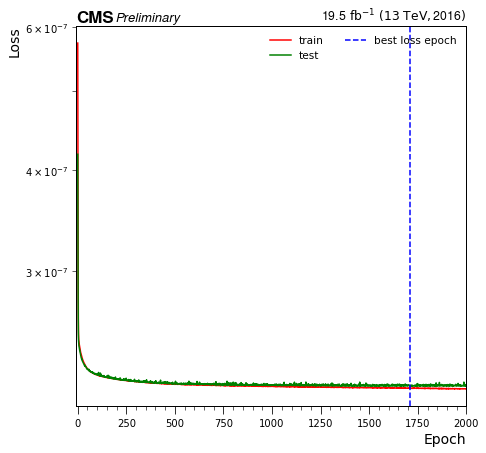

In [10]:
# Variables
try:
    train_loss = np.array(history.history["loss"])
    test_loss = np.array(history.history["val_loss"])
    best_epoch = np.argmin(test_loss)
except:
    # In case we try to manipulate the plot without re-training the model we can load the training log
    df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
    train_loss = np.array(df["loss"])
    test_loss = np.array(df["val_loss"])
    best_epoch = np.argmin(test_loss)
    
print("best_epoch", best_epoch)
print("train_loss on best_epoch", train_loss[best_epoch])
print("test_loss on best_epoch", test_loss[best_epoch])

# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(train_loss, label="train", color="red")
ax1.plot(test_loss, label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.savefig(f"{figures_path}/MLP_score_keras-loss_history-{model_name}.png", dpi=200, facecolor='white')
plt.show()
plt.close()

# Plot model accuracy history

best_epoch 1710
train_acc on best_epoch 0.8470144271850586
test_acc on best_epoch 0.8496904969215393


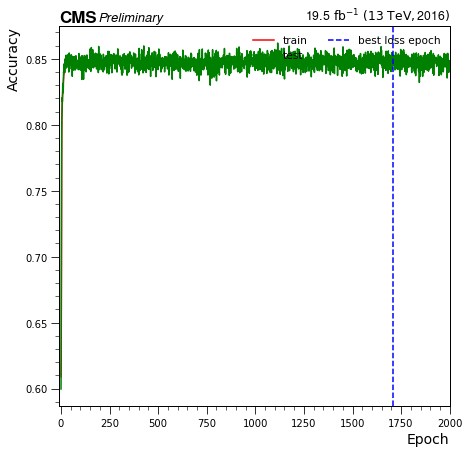

In [11]:
try:
    train_acc = np.array(history.history["accuracy"])
    test_acc = np.array(history.history["val_accuracy"])
except:
    # In case we try to manipulate the plot without re-training the model we can load the training log
    df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
    train_acc = np.array(df["accuracy"])
    test_acc = np.array(df["val_accuracy"])

print("best_epoch", best_epoch)
print("train_acc on best_epoch", train_acc[best_epoch])
print("test_acc on best_epoch", test_acc[best_epoch])
    
# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(train_acc, label="train", color="red")
ax1.plot(test_acc, label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Accuracy", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.savefig(f"{figures_path}/MLP_score_keras-acc_history-{model_name}.png", dpi=200, facecolor='white')
plt.show()
plt.close()

# Teste do plot das métricas usando EOD callback

In [12]:
# # Variables
# train_loss = np.array(history.history["eval_train_loss"])
# test_loss = np.array(history.history["eval_test_loss"])
# best_epoch = np.argmin(test_loss)

# # Plot config
# fig = plt.figure(figsize=(7,7))
# grid = [1,1] # number of rows, number of cols
# gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# # Plot code
# ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
# ax1.plot(train_loss, label="train", color="red")
# ax1.plot(test_loss, label="test", color="green")
# ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
# ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
# ana.style(
#     ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
#     ylog=False, legend_ncol=2
# )
# plt.savefig(f"{figures_path}/MLP_score_keras-eval_loss_history-{model_name}.png", dpi=200, facecolor='white')
# plt.show()
# plt.close()


# # Variables
# train_acc = np.array(history.history["eval_train_acc"])
# test_acc = np.array(history.history["eval_test_acc"])

# # Plot config
# fig = plt.figure(figsize=(7,7))
# grid = [1,1] # number of rows, number of cols
# gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# # Plot code
# ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
# ax1.plot(train_acc, label="train", color="red")
# ax1.plot(test_acc, label="test", color="green")
# ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
# ana.labels(ax1, ylabel="Accuracy", xlabel="Epoch")
# ana.style(
#     ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
#     ylog=False, legend_ncol=2
# )
# plt.savefig(f"{figures_path}/MLP_score_keras-eval_acc_history-{model_name}.png", dpi=200, facecolor='white')
# plt.show()
# plt.close()

# Testando rolling mean

best_epoch 1710
train_loss on best_epoch 2.1543503692100785e-07
test_loss on best_epoch 2.1673955075129925e-07


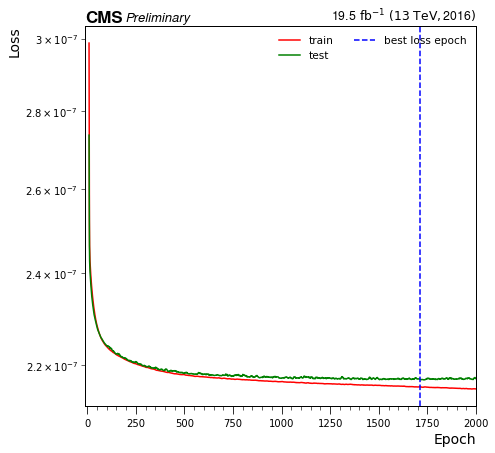

In [13]:
# Variables
df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
train_loss = np.array(df["loss"])
test_loss = np.array(df["val_loss"])
best_epoch = np.argmin(test_loss)
    
print("best_epoch", best_epoch)
print("train_loss on best_epoch", train_loss[best_epoch])
print("test_loss on best_epoch", test_loss[best_epoch])

## Rolling
df["rolling_loss_10"] = df.loss.rolling(10).mean()
df["rolling_val_loss_10"] = df.val_loss.rolling(10).mean()

# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(df["rolling_loss_10"], label="train", color="red")
ax1.plot(df["rolling_val_loss_10"], label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=True, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.show()
plt.close()

best_epoch 1710
train_acc on best_epoch 0.8470144271850586
test_acc on best_epoch 0.8496904969215393


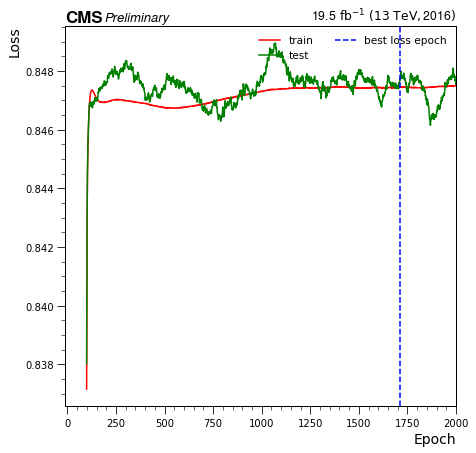

In [14]:
# Variables
df = pd.read_csv(f"{models_path}/{model_name}-training-log.csv")
train_acc = np.array(df["accuracy"])
test_acc = np.array(df["val_accuracy"])
    
print("best_epoch", best_epoch)
print("train_acc on best_epoch", train_acc[best_epoch])
print("test_acc on best_epoch", test_acc[best_epoch])

## Rolling
df["rolling_accuracy_100"] = df.accuracy.rolling(100).mean()
df["rolling_val_accuracy_100"] = df.val_accuracy.rolling(100).mean()

# Plot config
fig = plt.figure(figsize=(7,7))
grid = [1,1] # number of rows, number of cols
gspec = gs.GridSpec(grid[0], grid[1], width_ratios=[1], height_ratios=[1])

# Plot code
ax1 = plt.subplot(position(gspec, grid, main=1, sub=1)) # main is column number, sub is row number
ax1.plot(df["rolling_accuracy_100"], label="train", color="red")
ax1.plot(df["rolling_val_accuracy_100"], label="test", color="green")
ax1.axvline(x=best_epoch, label="best loss epoch", color="blue", linestyle="--")
ana.labels(ax1, ylabel="Loss", xlabel="Epoch")
ana.style(
    ax1, lumi=metadata["luminosity"].get(dataset_year), year=year_style,
    ylog=False, legend_ncol=2, xlim=[-10, len(train_loss)]
)
plt.show()
plt.close()

# Notificar quando o notebook terminar

In [15]:
from IPython.display import clear_output, display, HTML, Javascript

display(Javascript("""
  var msg = new SpeechSynthesisUtterance();
  msg.text = "Processo completo!";
  window.speechSynthesis.speak(msg);
  alert("Processo completo!")
"""))

<IPython.core.display.Javascript object>